In [150]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as alea
%matplotlib inline
from decimal import Decimal

In [151]:
from PlotFunctions import plot_signal, plot_position, plot_velocity, plot_variance

In [165]:
tau = 0.013
dt = 0.005 # step time
n = 2 # number of coordinates
k = 0.00001 # kind of accuracy parameter: the smaller k is, the more accurate is the pointing
n_try = 75
t_fix = .2
delay = .1
t_mov = .5
T_mov = int(t_mov/dt)
T_fix = int(t_fix/dt)
T_delay = int(delay/dt)
T_tot = T_mov+T_fix+T_delay

In [166]:
def fact(n): 
    """The factorial function
    Returns n!, that is n x (n-1) x (n-2) x ... x 1
    Recursive implementation
    """
    if n == 0:
        return 1
    else:
        return(n*fact(n-1))

In [167]:
# definition of A and B

A = np.zeros((n,n))
B = np.zeros(n)
for i in np.arange(n):
    for j in np.arange(i,n):
        A[i,j] = dt**(j-i)/fact(j-i)
A[n-1, n-1] = 1-dt/tau
B[n-1] = dt

In [168]:
def power(A, n): 
    """
    renvoie A puissance n où A est une matrice carrée
        
    """
    if n == 0:
        return(np.eye(int(np.sqrt(np.size(A)))))
    elif n == 1:
        return A
    else:
        if n % 2 == 0:
            A_half = power(A, n//2)
            return(A_half.dot(A_half))
        else:
            A_half = power(A, (n-1)//2)
            return(A.dot(A_half.dot(A_half)))

def A_pow(A):
    A_pow_array = np.zeros((T_mov+1,n,n))

    for i in np.arange(T_mov+1):
        A_pow_array[i] = power(A,i)
    return A_pow_array

A_pow_array = A_pow(A)

def pow_fast(n):
    return A_pow_array[n]

ci0_array = np.zeros(T_mov+1)

for i in np.arange(T_mov+1):
    ci0_array[i] = (pow_fast(i).dot(B))[0]

ci1_array = np.zeros(T_mov+1)

for i in np.arange(T_mov+1):
    ci1_array[i] = (pow_fast(i).dot(B))[1]
    
#ci2_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci2_array[i] = (pow_fast(i).dot(B))[2]
    
#ci3_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci3_array[i] = (pow_fast(i).dot(B))[3]

ci = np.array([ci0_array, ci1_array])#, ci2_array])

In [169]:
time = np.linspace(-t_fix, delay+t_mov, T_tot+1)
time_ms = time*1000

In [170]:
counter_right = np.zeros(n_try)
counter_left = np.zeros(n_try)
window = 15
proba = 0.8
distribution = (2*(alea.binomial(1, proba, n_try)-0.5)).astype(int) # binomial(1,p,n_try) : random selection of 1  with probability p and 0 with probability 1-p

In [171]:
n_iter = 5000
eta = 5000

In [172]:
u_rec = np.zeros((n_try, T_tot+1))
pos_rec = np.zeros((n_try, T_tot+1))
vel_rec = np.zeros((n_try, T_tot+1))

In [173]:
v = 10
xT = 0

In [180]:
(0.02468+0.001739*(2-0.9))/(1-0.001739*10)

0.02706353487141389

In [174]:
import time
debut = time.time()

for i in np.arange(n_try):
    if i < window:
        v_anticipation =v*((counter_right-counter_left)/window).sum()
    else:
        v_anticipation = v*((counter_right[(i-window):i]-counter_left[(i-window):i])/window).sum()
        
    u_rec[i, T_fix:(T_delay+T_fix)] = 1/tau*v_anticipation*np.ones(T_delay)
    
    pos_rec[i, T_fix:(T_delay+T_fix+1)] = np.linspace(0, v_anticipation*(delay+dt), T_delay+1)
    
    vel_rec[i, T_fix:(T_delay+T_fix)] = v_anticipation*np.ones(T_delay)

    if distribution[i] < 0:
        counter_left[i] = 1
    else:
        counter_right[i] = 1
    
    x0 = np.array([pos_rec[i,T_fix+T_delay], v_anticipation])
    target = np.array([v*distribution[i]*delay + xT, v*distribution[i]])
    
    t_Tv = 0.02468+0.001739*np.abs(target[0]-x0[0]) # see Transitioning from Saccade to SPEM using LQTC, Korentis & Enderle
    t_T =  float(round(Decimal(t_Tv),3)) #.05 # saccade duration
    t_R =  t_mov-float(round(Decimal(t_Tv),3)) # .05 # fixing / pursuit duration
    T = int(np.round(t_T/dt))
    R = int(np.round(t_R/dt))
    
    def xT_f(t):
        return np.array([target[0]+target[1]*t*dt, target[1]])
    
    def expectation(u, t):
        """Computation of the expectation of the state vector at time t, given u
        """
        if t == 0:
            return x0
        else:
            return pow_fast(t).dot(x0)+(ci[:,0:t]*np.flipud(u[0:t])).sum(axis = 1)

    mult_v = np.array([1, 1])
    
    def variance(u, t):
        """Computation of the variance of the state vector at time t, given u
        """
        return k*(np.flipud(ci0_array[0:t]**2)*u[0:t]**2).sum()
    
    def cost_deriv(u, ii):
        """Derivative of the cost function with respect to u_i
        """
        if ii < T:
            return (2*np.transpose(ci[:,(T-ii-1):(T+R-ii)])*np.array([((expectation(u,t)-xT_f(t))*mult_v).tolist() for t in (T+np.arange(R+1))])).sum() + 2*k*u[ii]*(ci0_array[(T+1-ii-1):(T+R-ii)]**2).sum()
        else:
            return (2*np.transpose(ci[:,0:(T+R-ii)])*np.array([((expectation(u,t)-xT_f(t))*mult_v).tolist() for t in (ii+1+np.arange(R+T-ii))])).sum() + 2*k*u[ii]*(ci0_array[0:(T+R-ii)]**2).sum()

    ubang = np.zeros(T+R+1)
    
    u = ubang.copy()
    for i_iter in np.arange(n_iter):
        u_old = u.copy()
        u[0:T+R] = u_old[0:T+R] - eta*np.array([cost_deriv(u_old, i) for i in np.arange(T+R)])
        
    u_rec[i, (T_tot-T_mov):(T_tot+1)] = u
    
    position = np.zeros(T+R+1)
    velocity = np.zeros(T+R+1)
    
    for j in np.arange(T+R+1):
        mean = expectation(u, j)
        position[j] = mean[0]
        velocity[j] = mean[1]
        
    pos_rec[i, (T_tot-T_mov):(T_tot+1)] = position
    vel_rec[i, (T_tot-T_mov):(T_tot+1)] = velocity
    
fin = time.time()


In [1]:
(fin-debut)/60/60

NameError: name 'fin' is not defined

In [156]:
cible = np.linspace(v*175*dt,v*275*dt,101)
pos_rec[48,200:301]-cible

array([-0.23333333, -0.23466667, -0.23356429, -0.23027727, -0.22504266,
       -0.21808504, -0.20961794, -0.19984521, -0.18896235, -0.17715771,
       -0.16461376, -0.15150822, -0.13801522, -0.12430637, -0.11055195,
       -0.09692192, -0.08358702, -0.07071992, -0.05849626, -0.04709581,
       -0.03670363, -0.02751123, -0.01971782, -0.01353157, -0.00917095,
       -0.00686615, -0.00686052, -0.00686043, -0.0068599 , -0.00685941,
       -0.00685892, -0.00685844, -0.00685797, -0.0068575 , -0.00685704,
       -0.00685659, -0.00685615, -0.00685571, -0.00685528, -0.00685485,
       -0.00685443, -0.00685402, -0.00685362, -0.00685322, -0.00685283,
       -0.00685245, -0.00685207, -0.0068517 , -0.00685134, -0.00685098,
       -0.00685063, -0.00685029, -0.00684996, -0.00684963, -0.00684931,
       -0.00684899, -0.00684868, -0.00684838, -0.00684809, -0.0068478 ,
       -0.00684752, -0.00684724, -0.00684698, -0.00684672, -0.00684646,
       -0.00684622, -0.00684598, -0.00684575, -0.00684552, -0.00

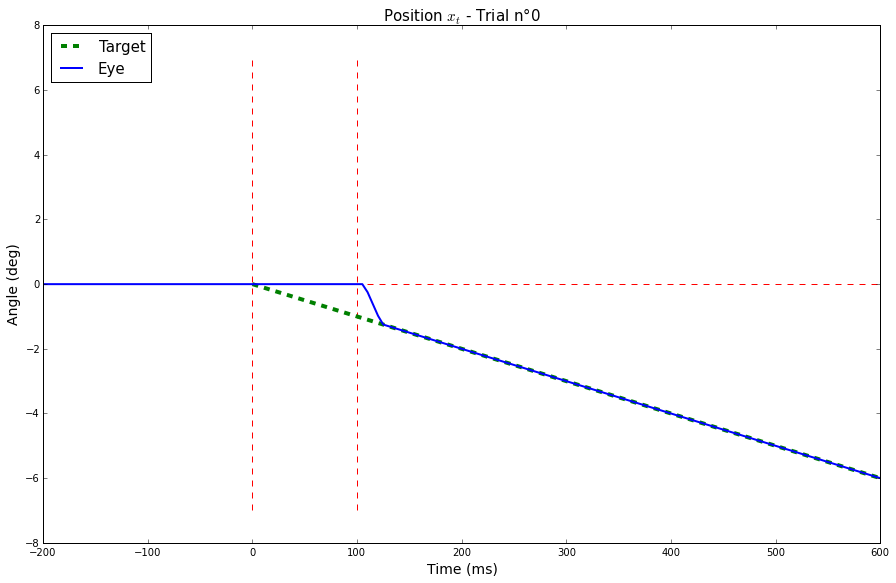

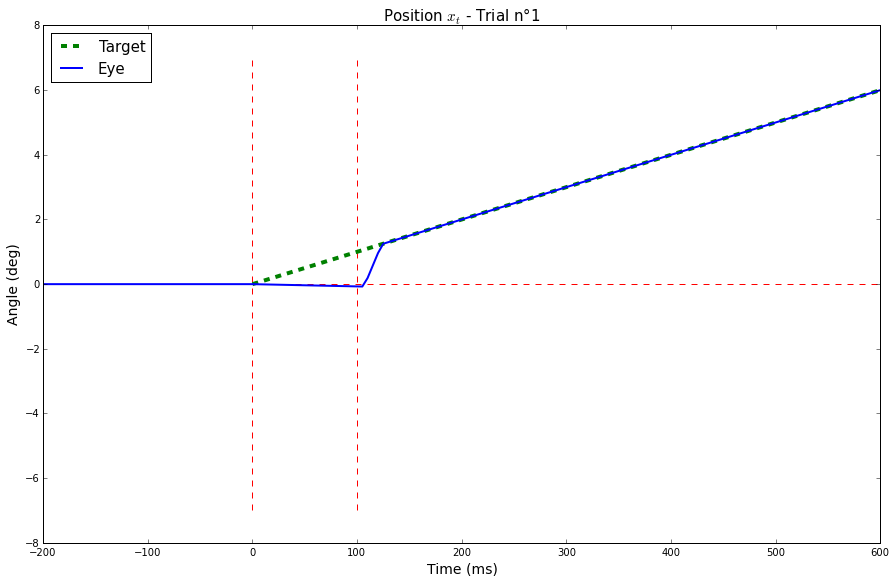

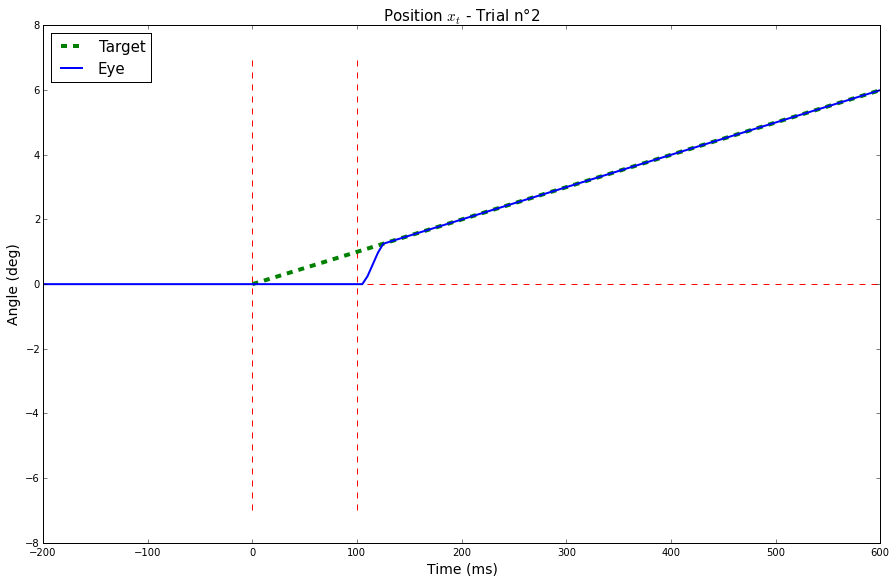

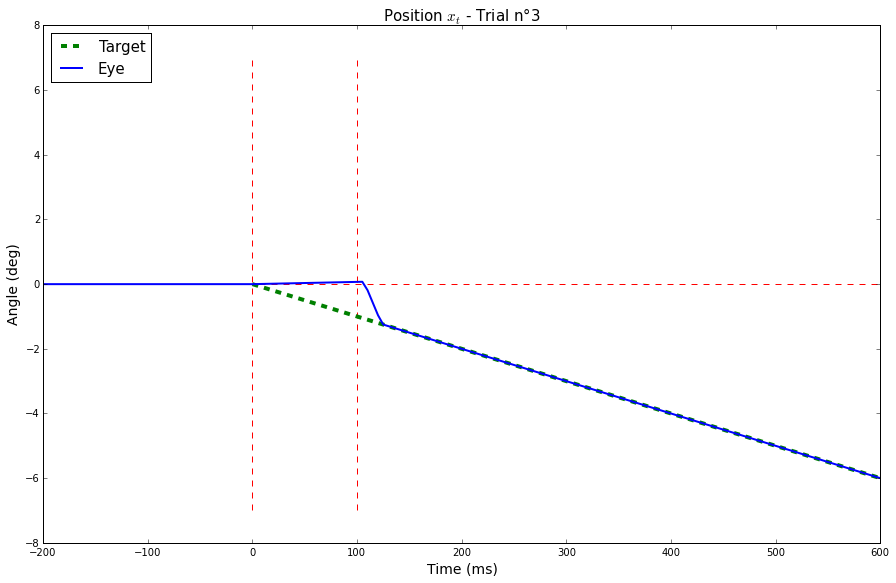

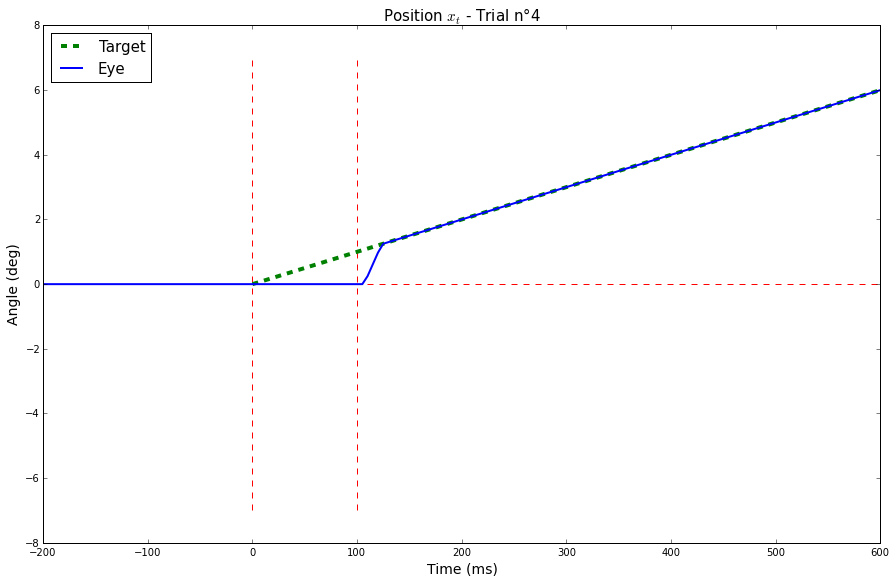

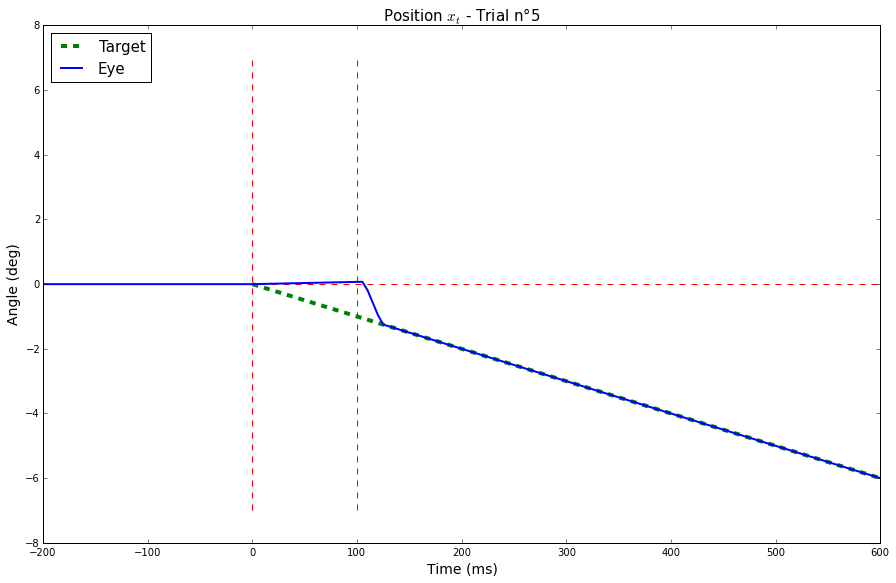

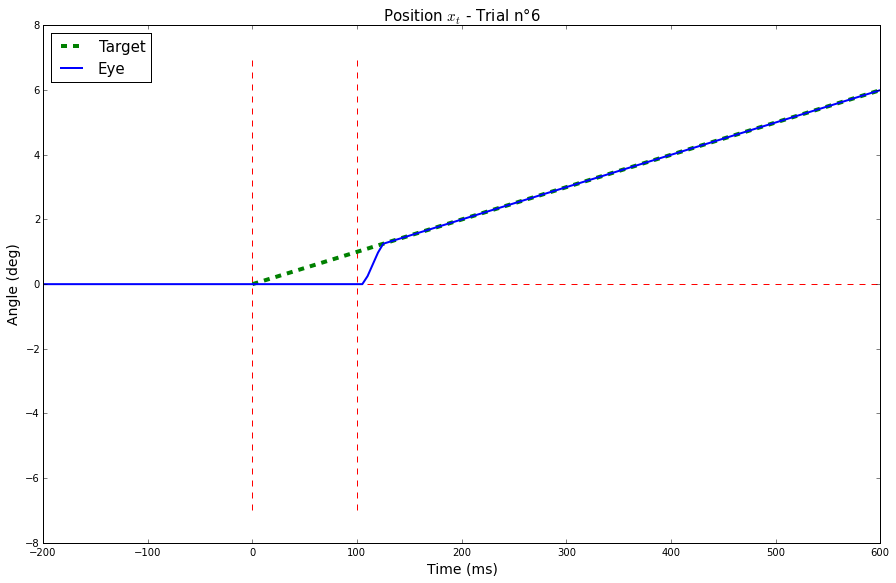

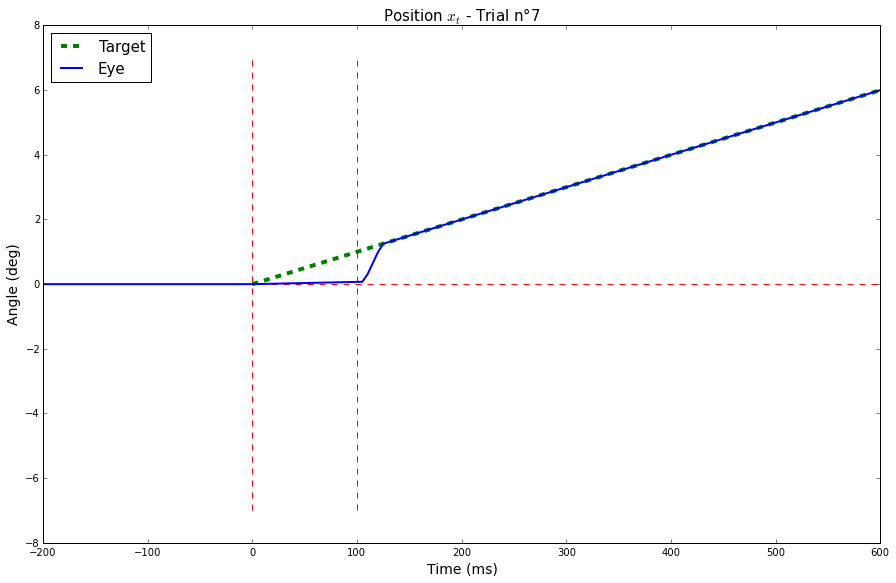

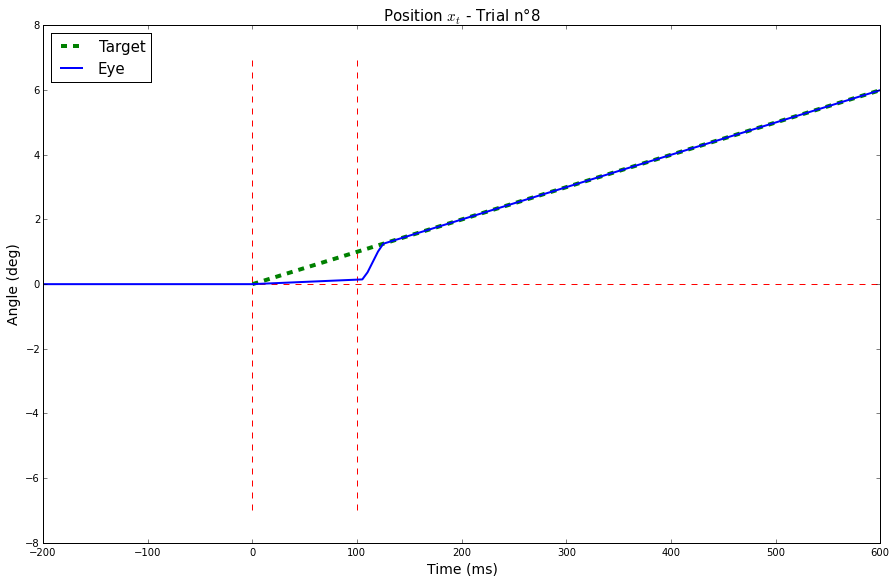

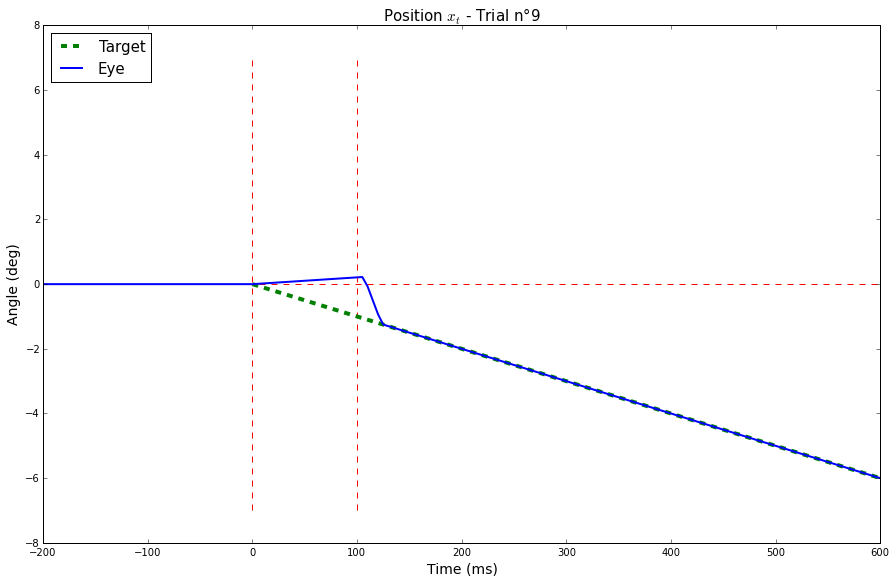

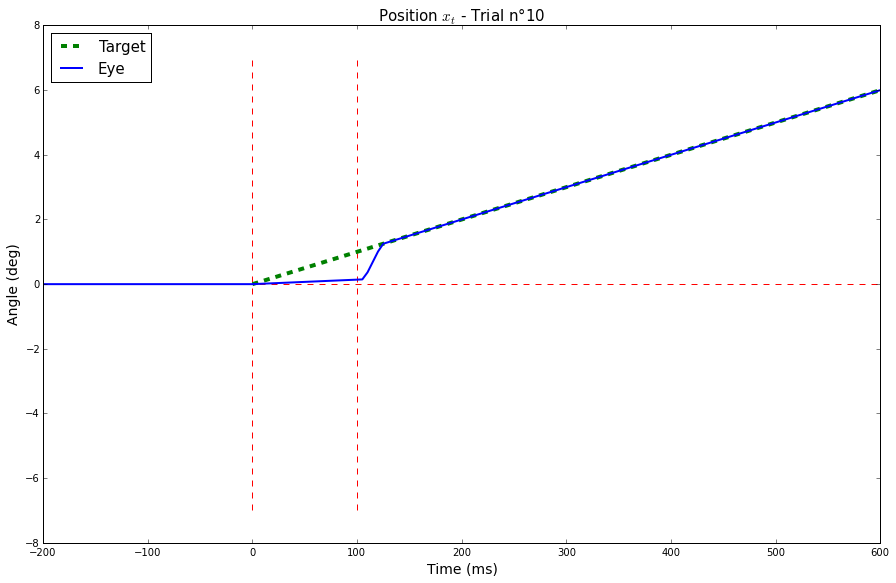

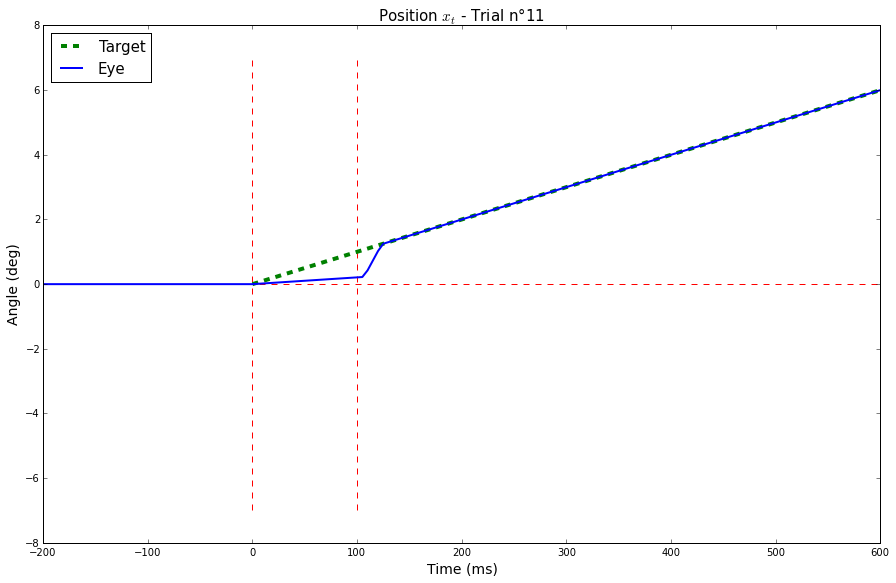

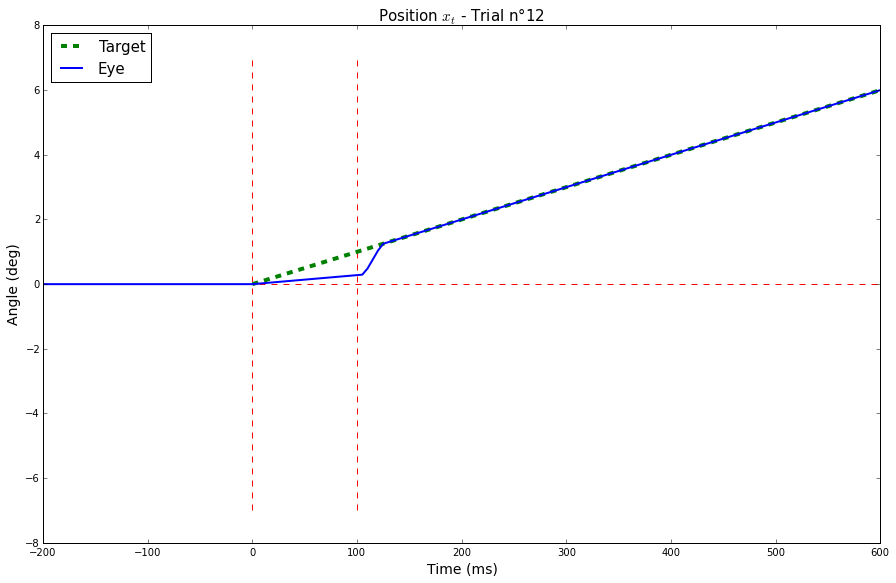

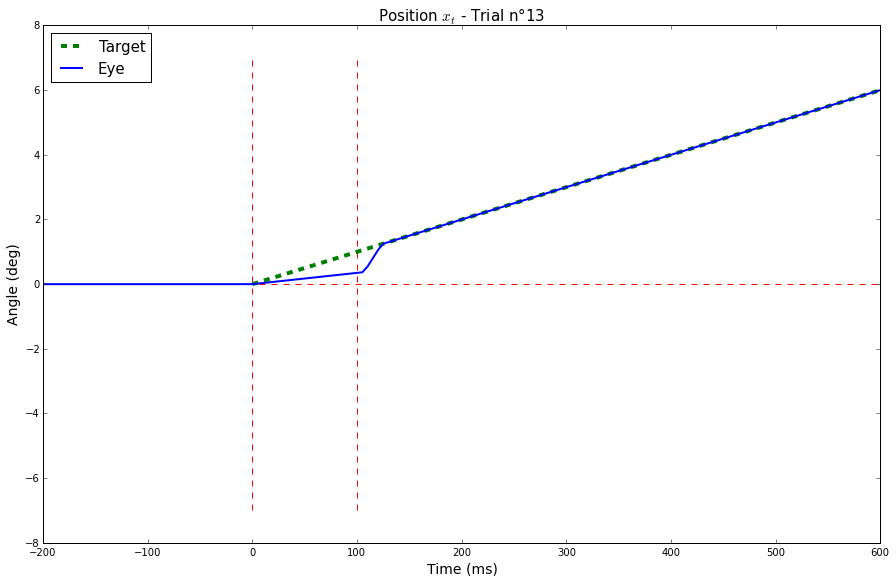

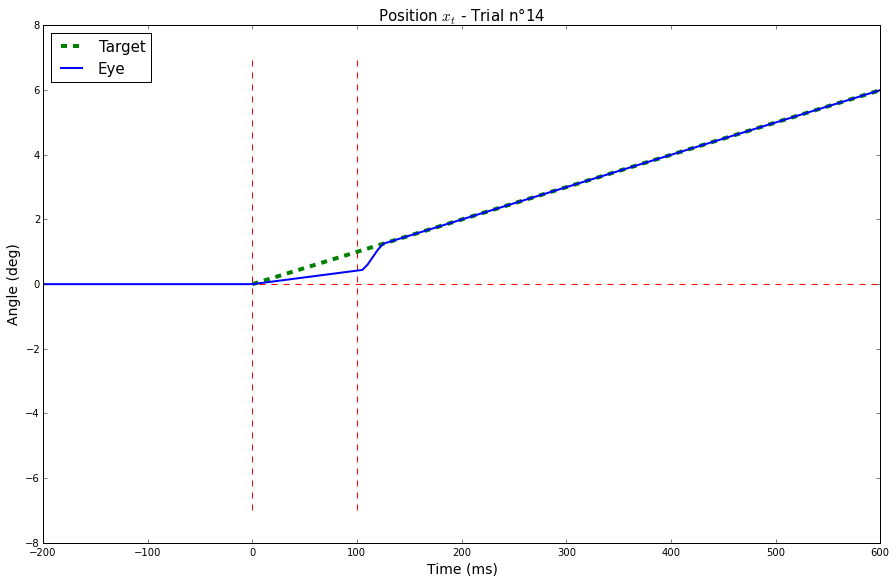

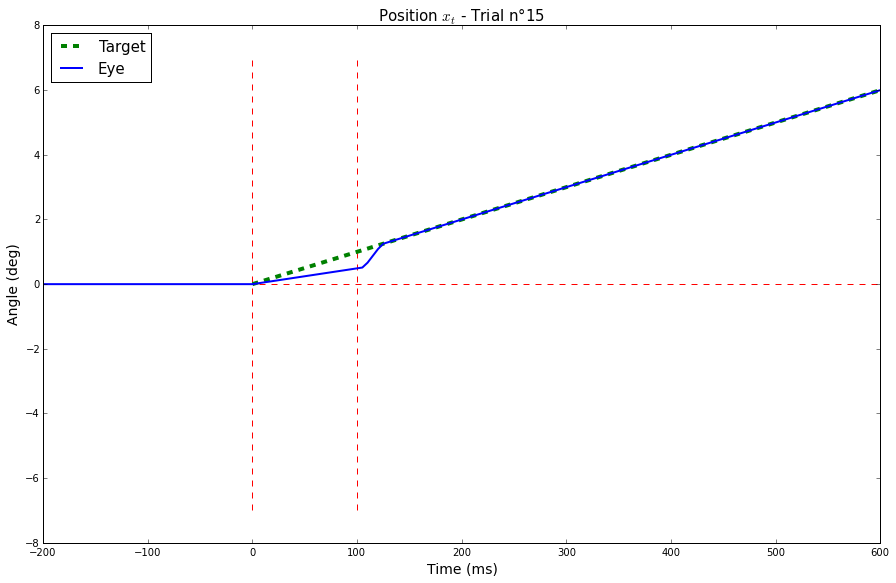

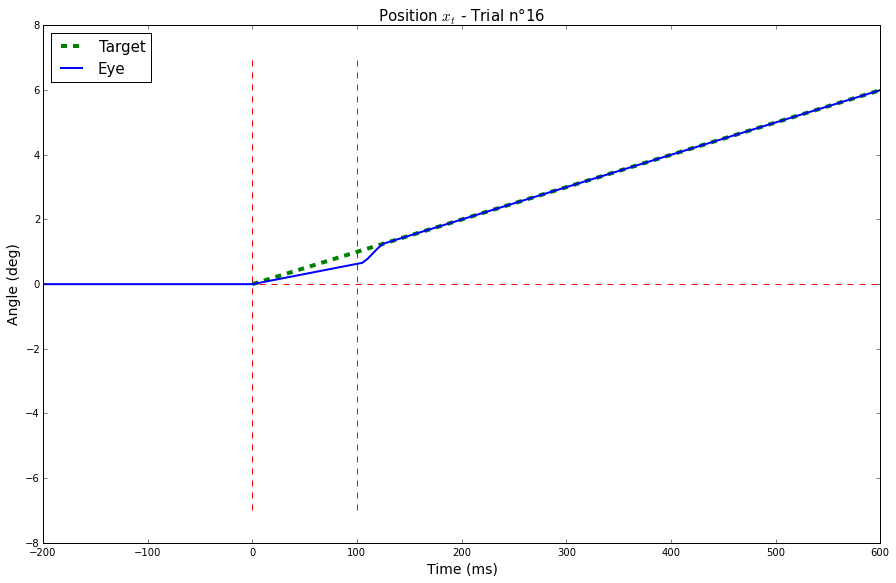

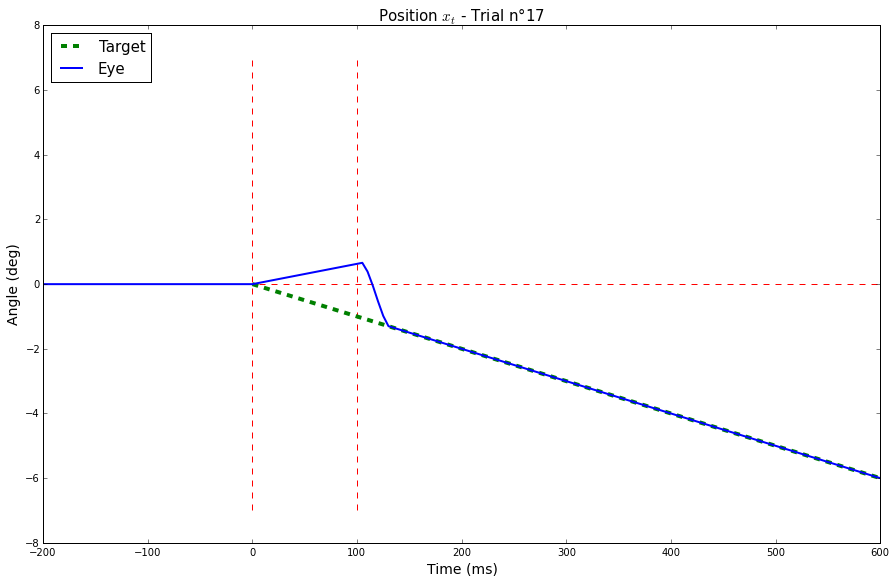

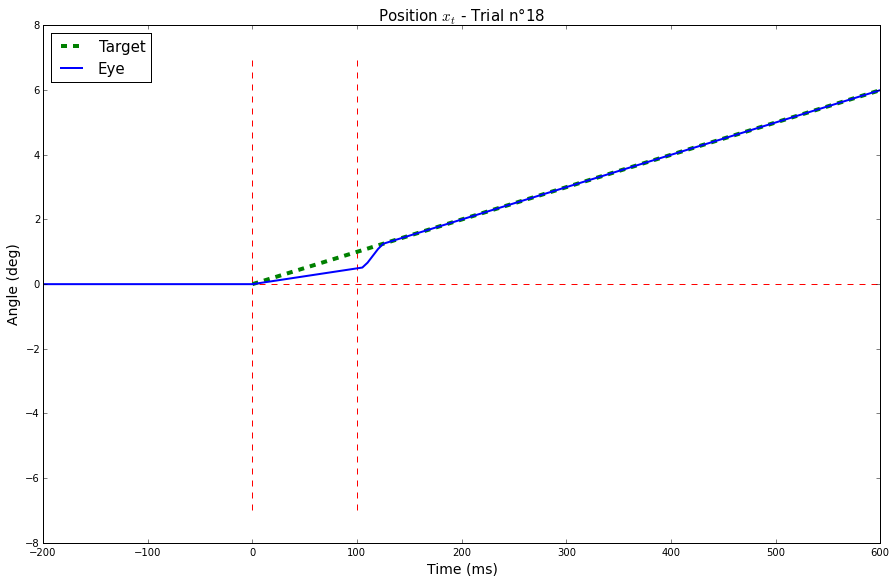

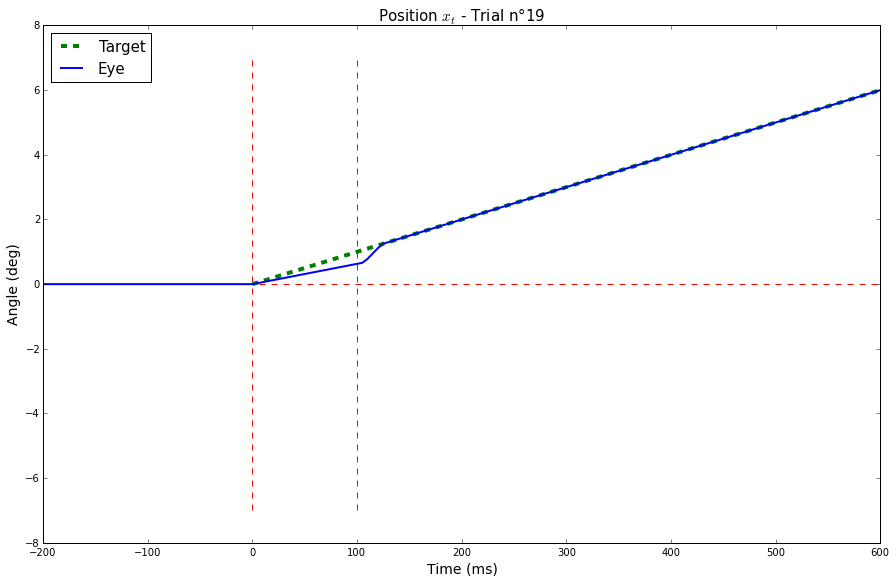

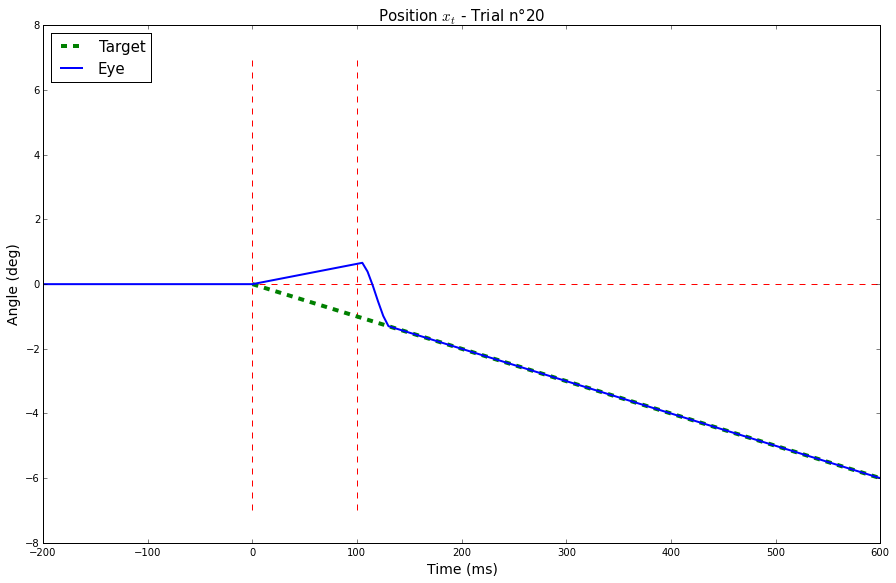

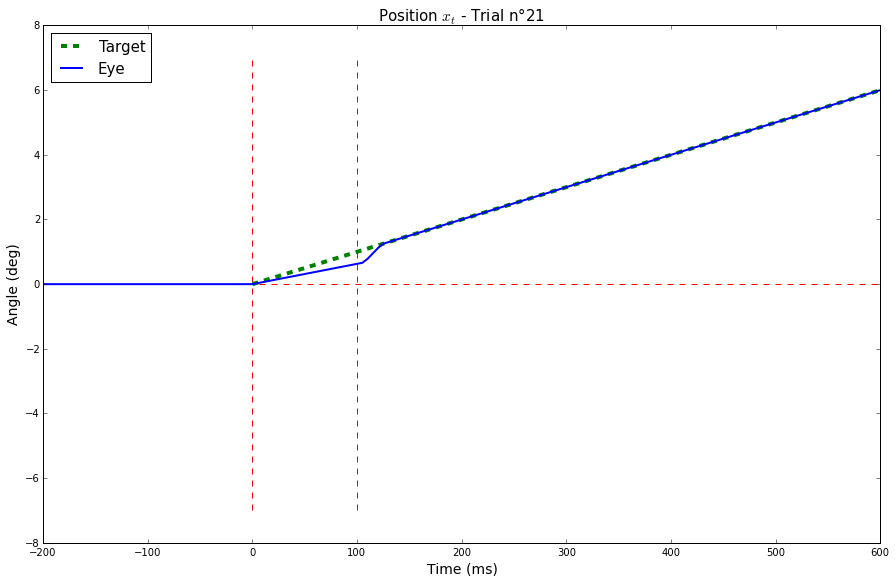

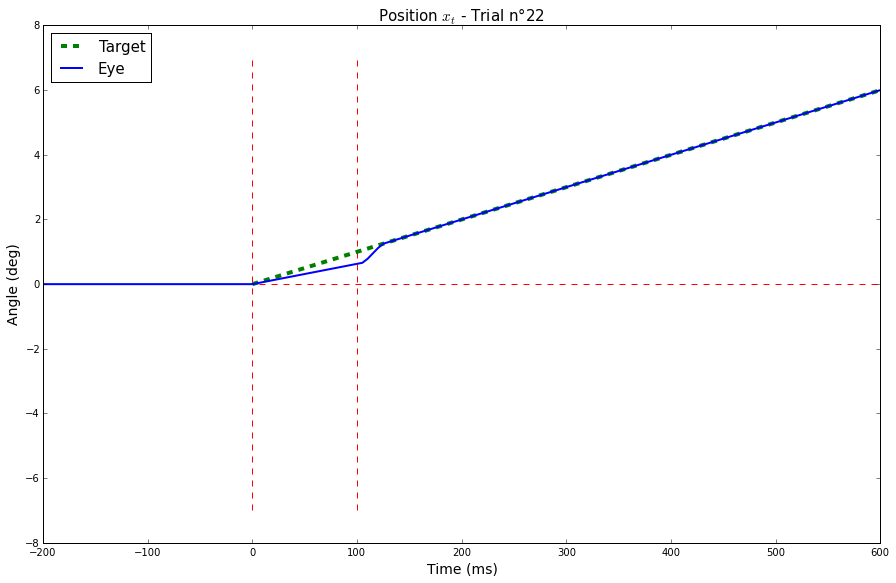

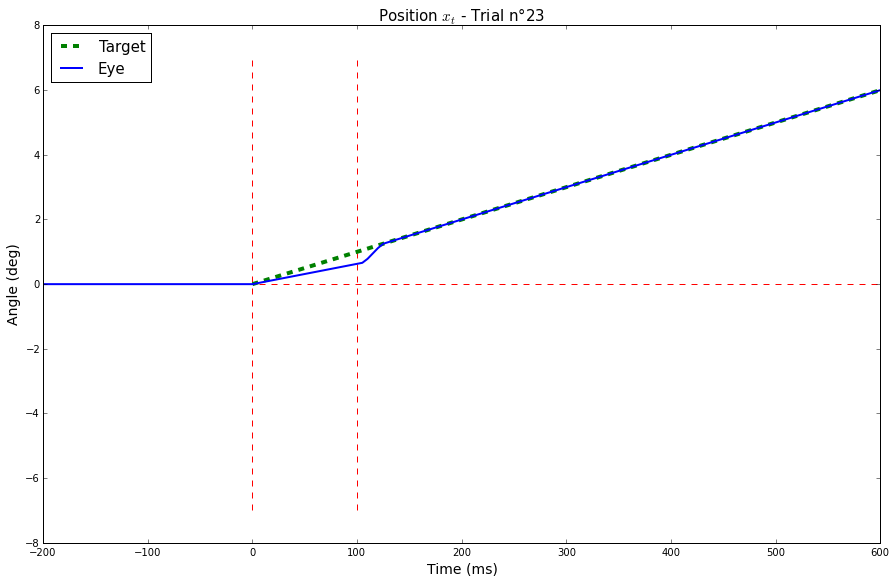

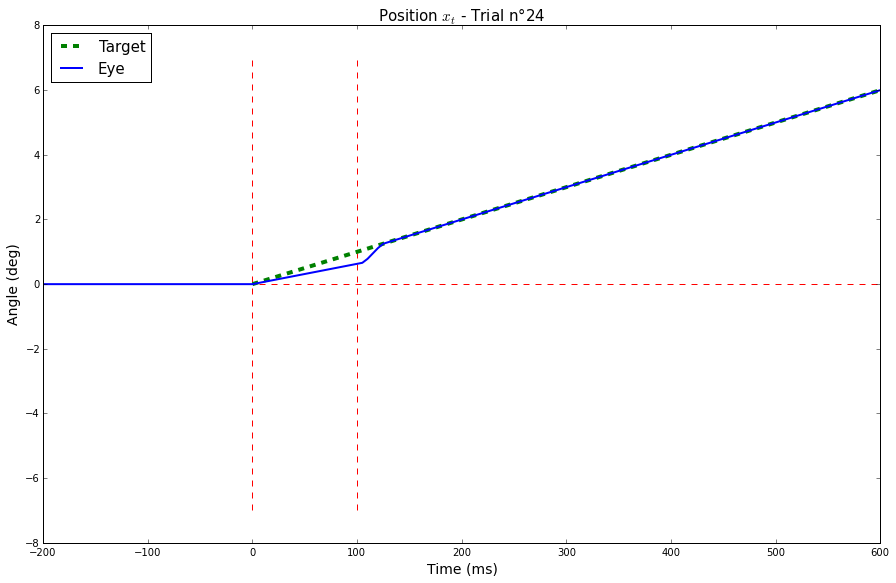

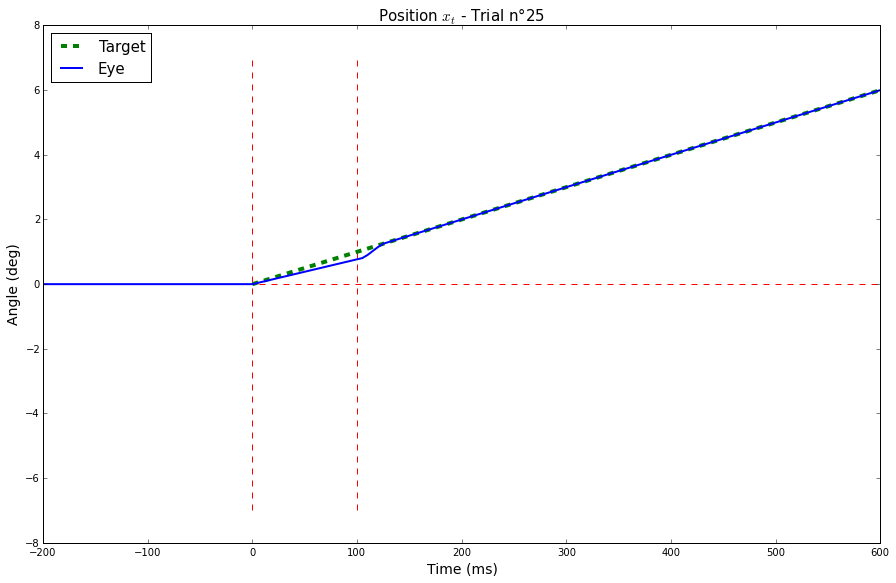

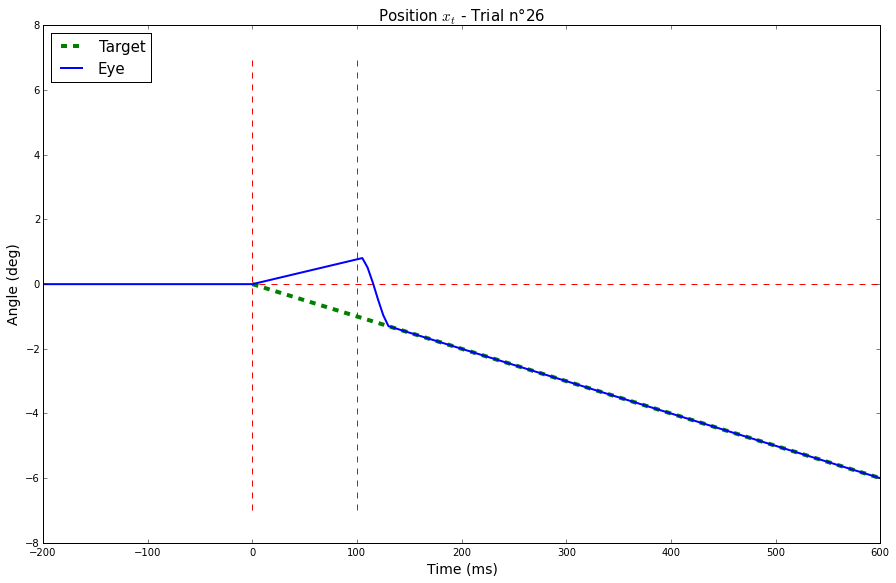

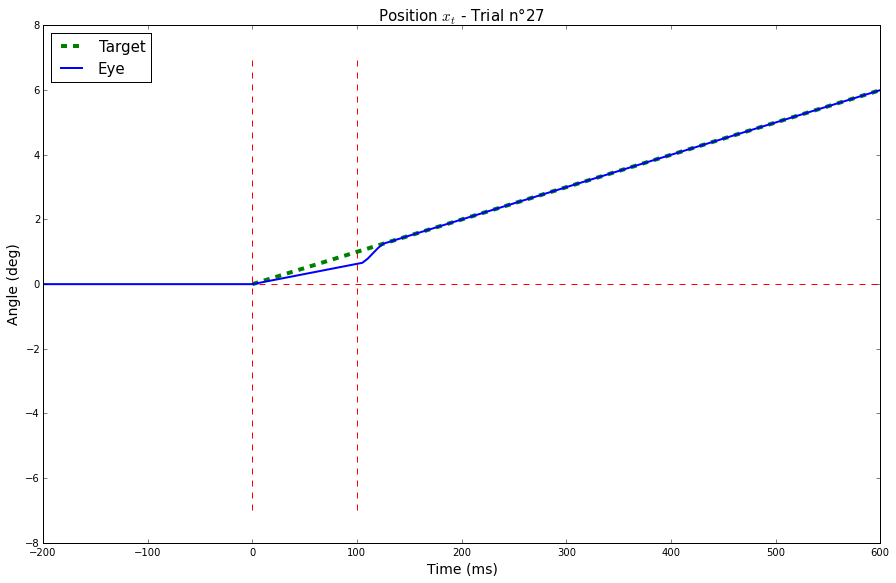

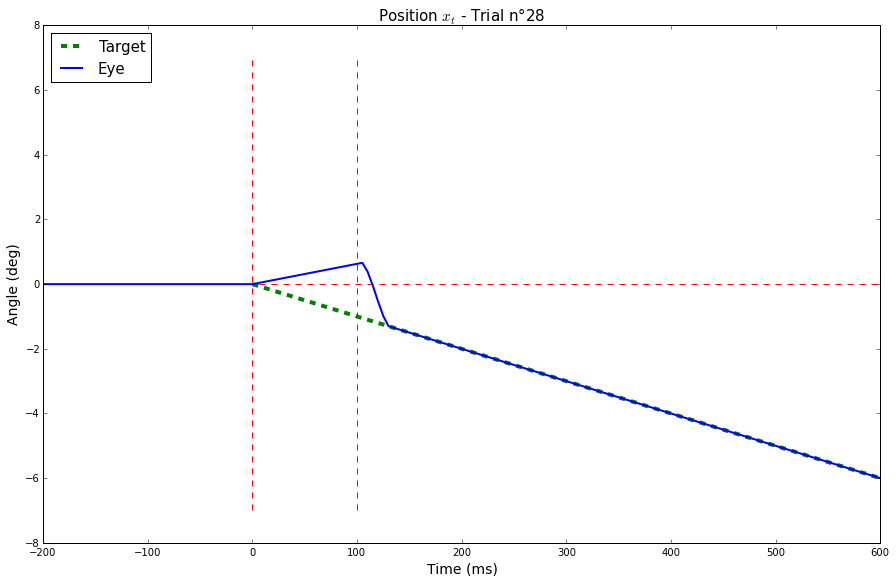

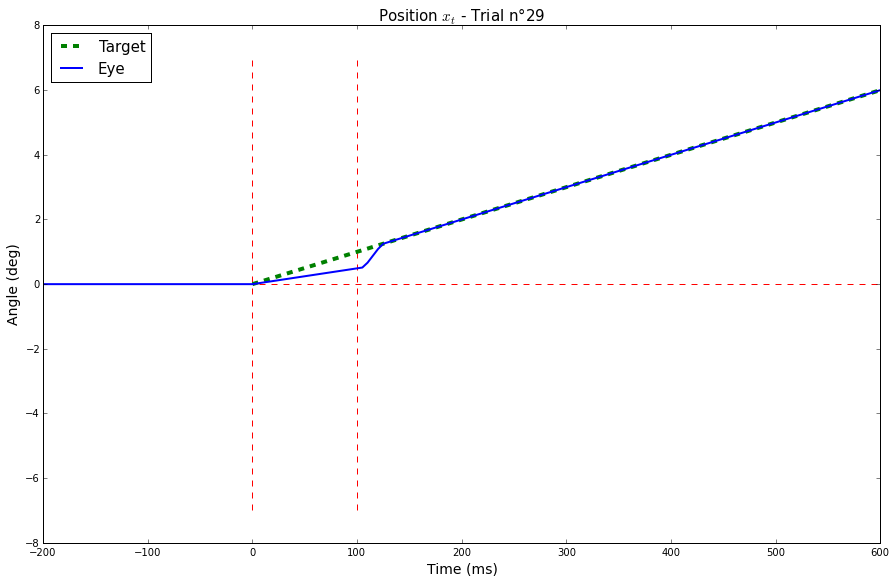

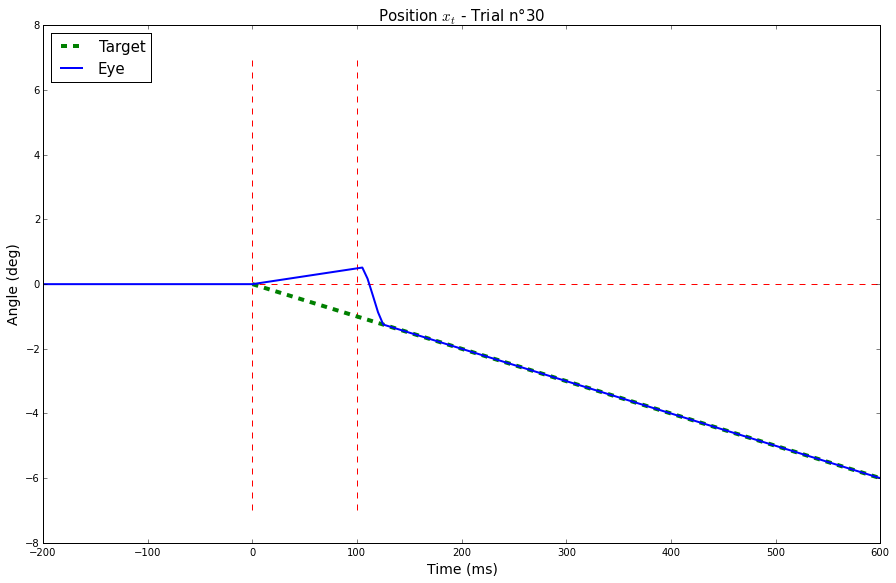

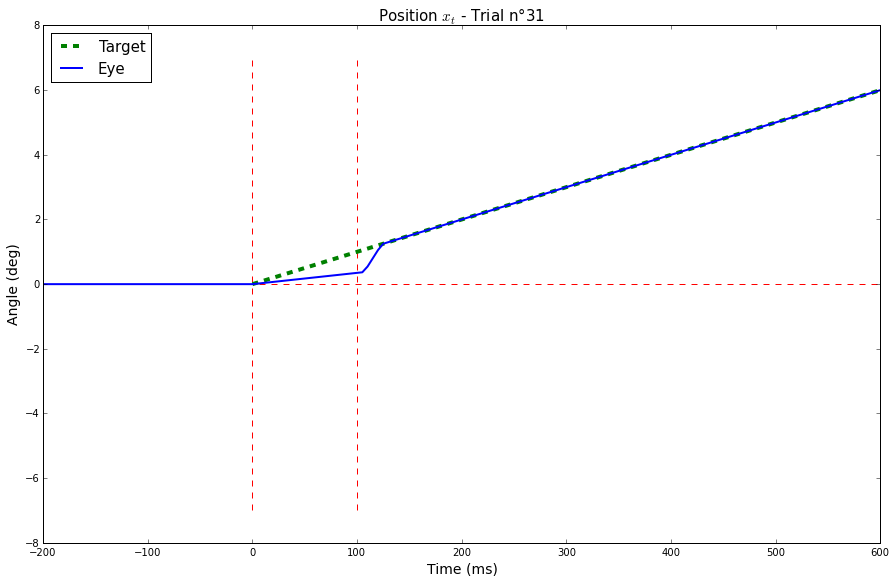

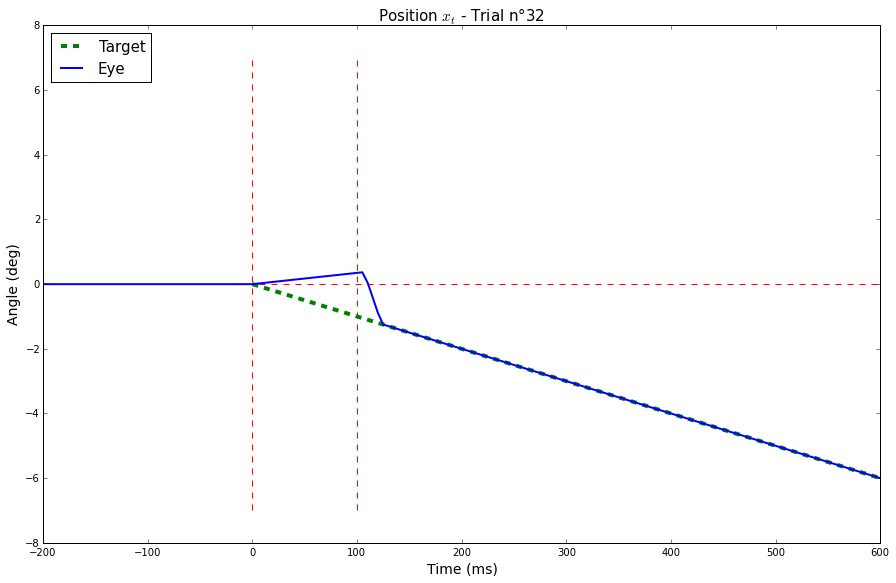

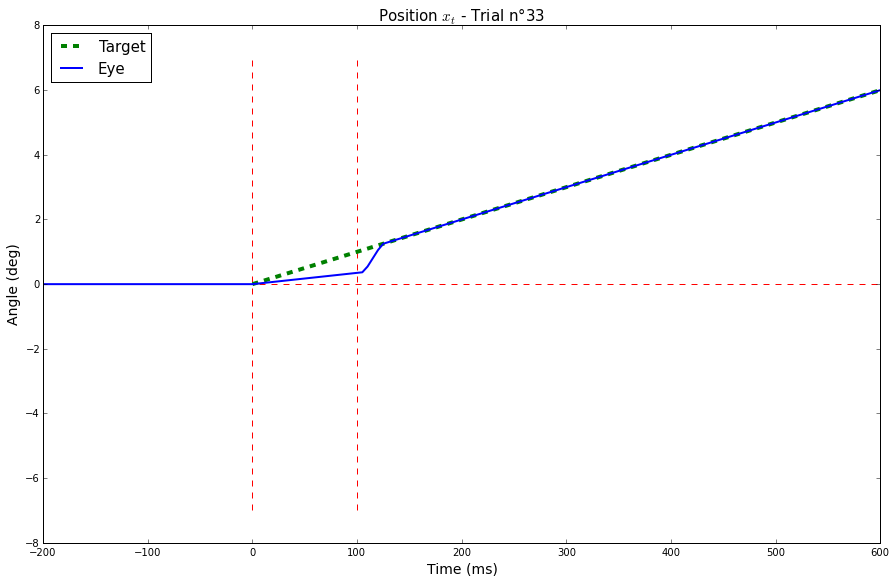

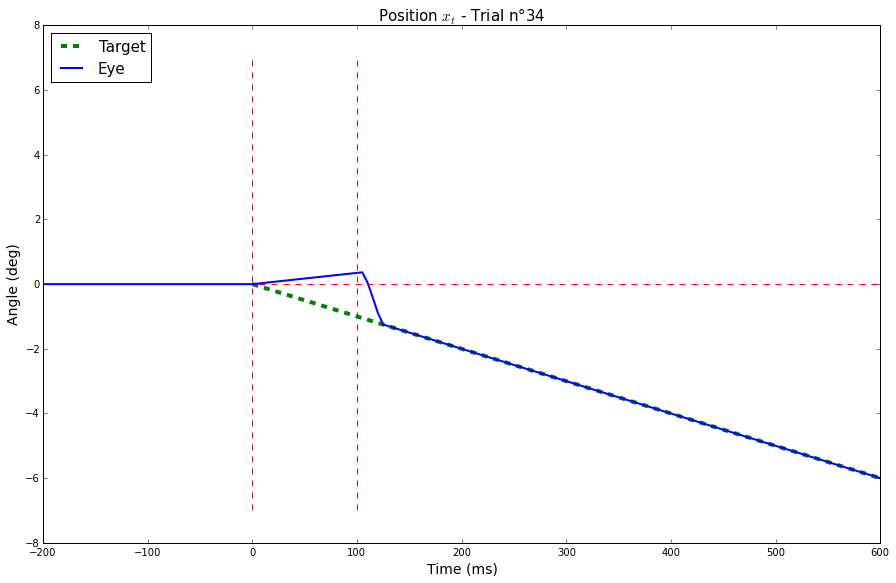

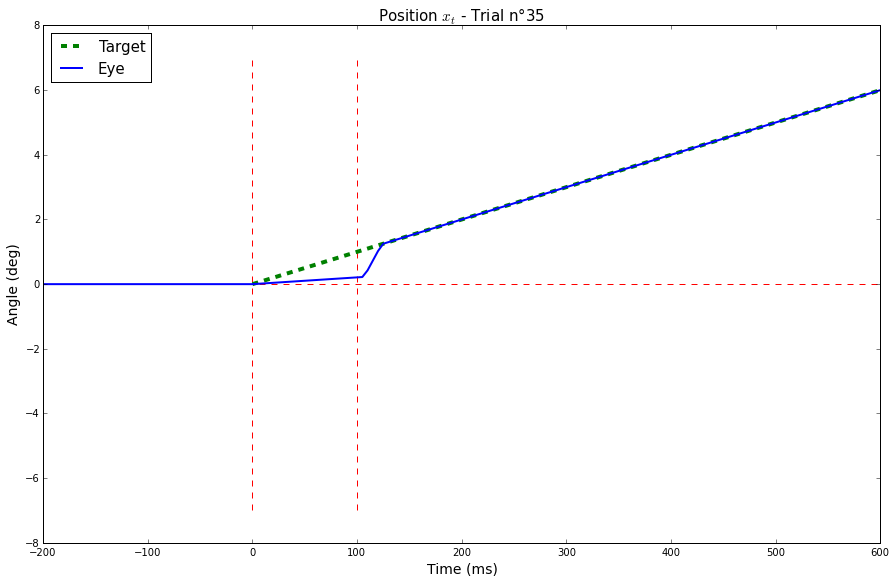

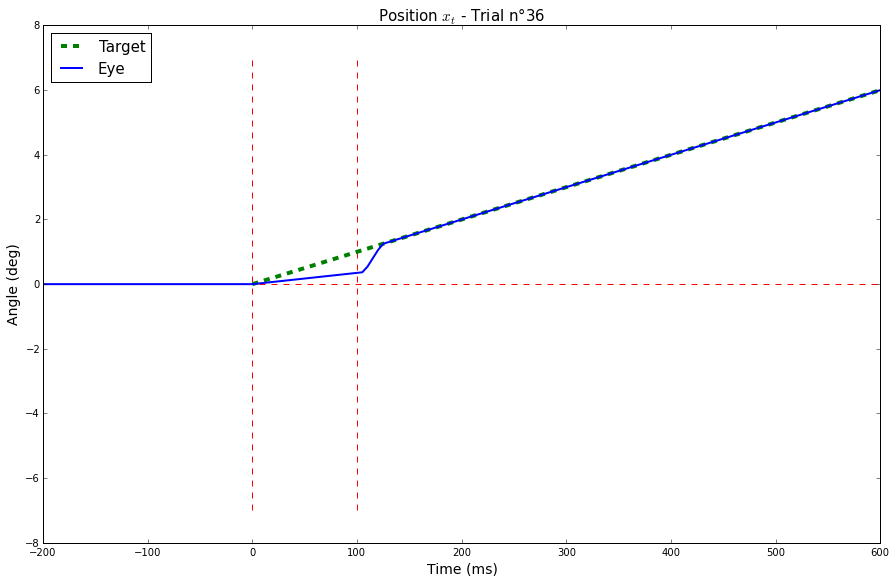

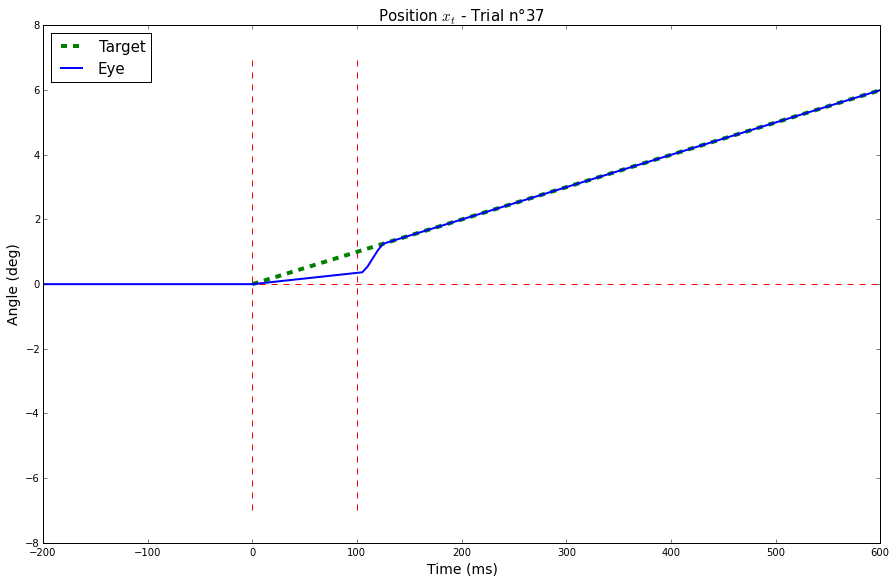

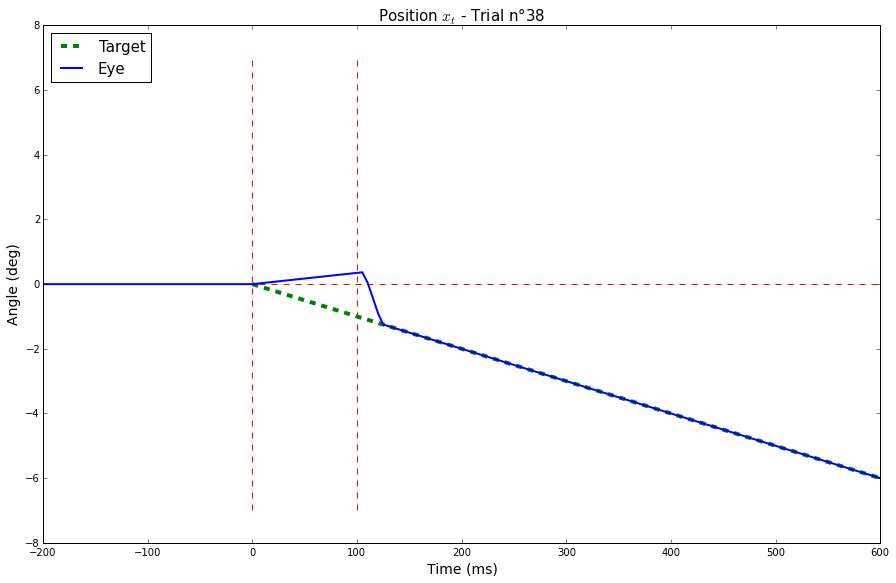

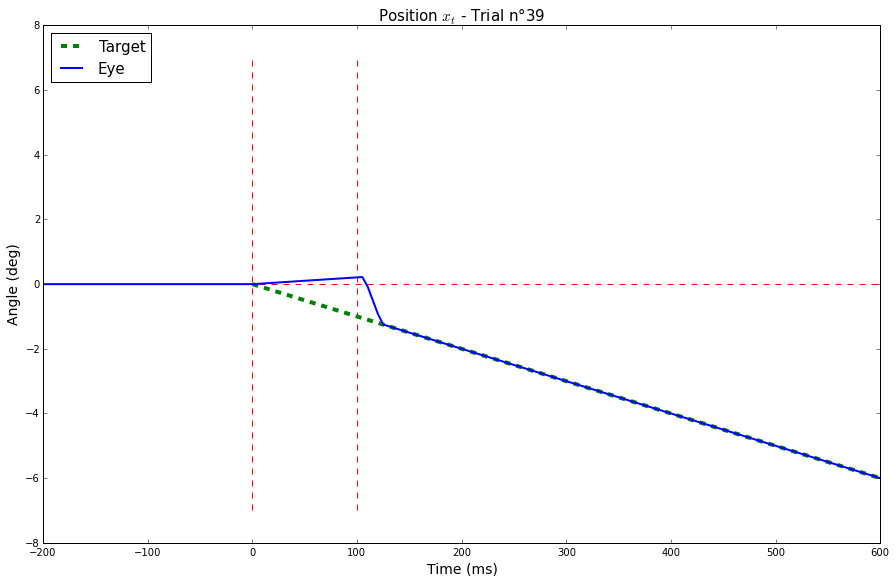

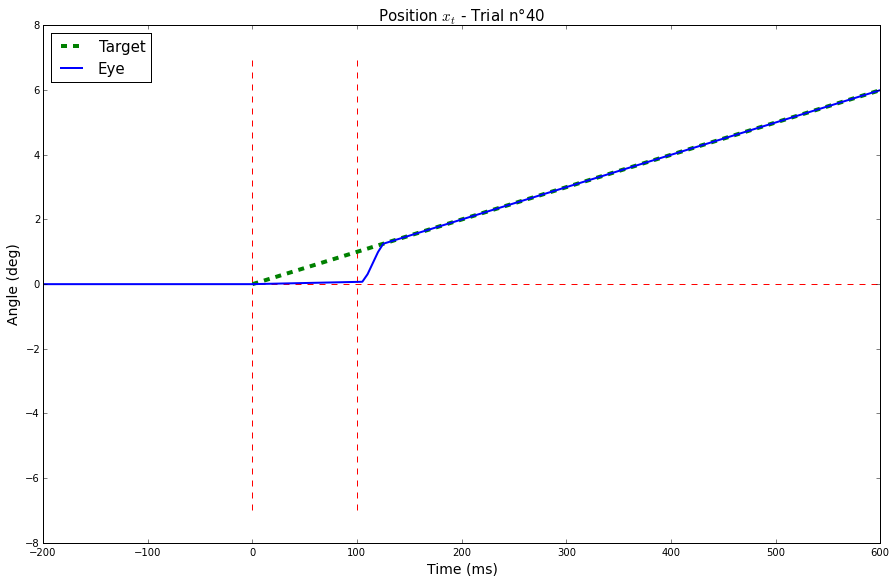

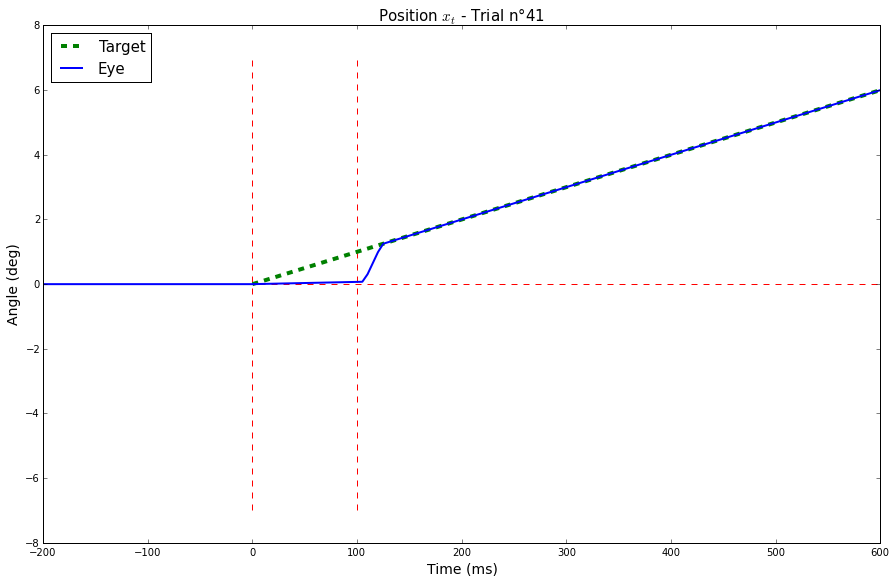

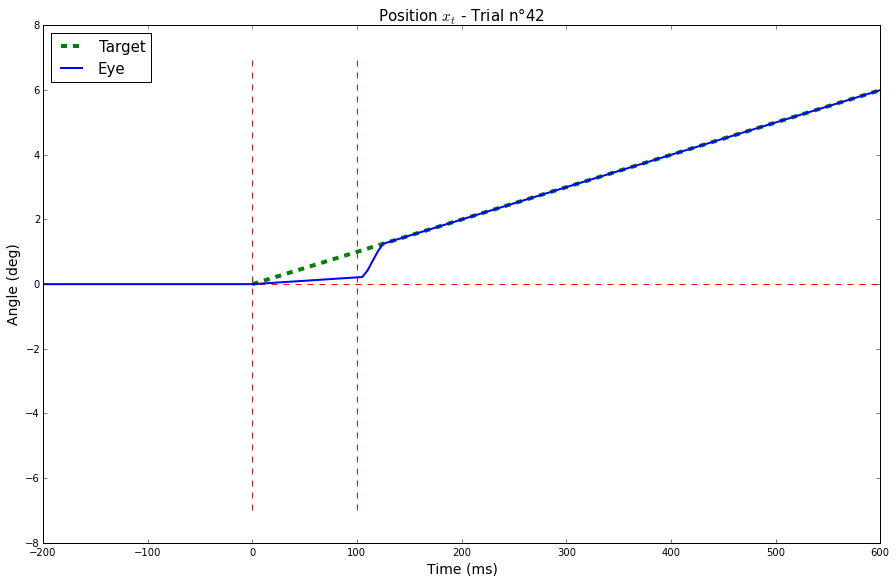

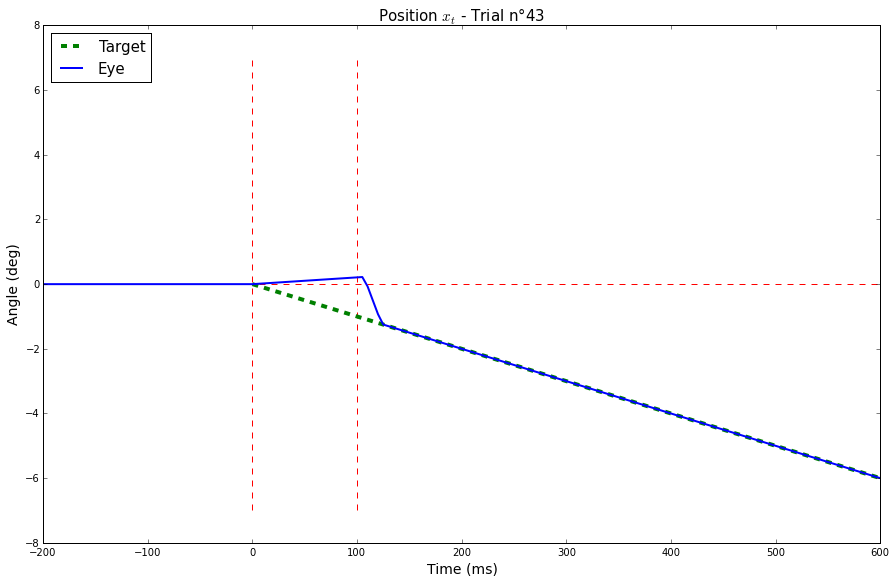

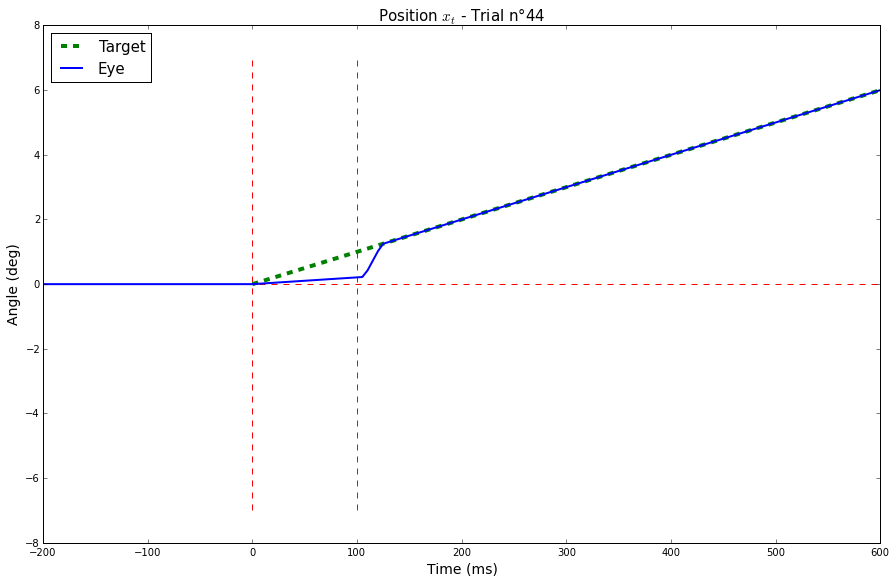

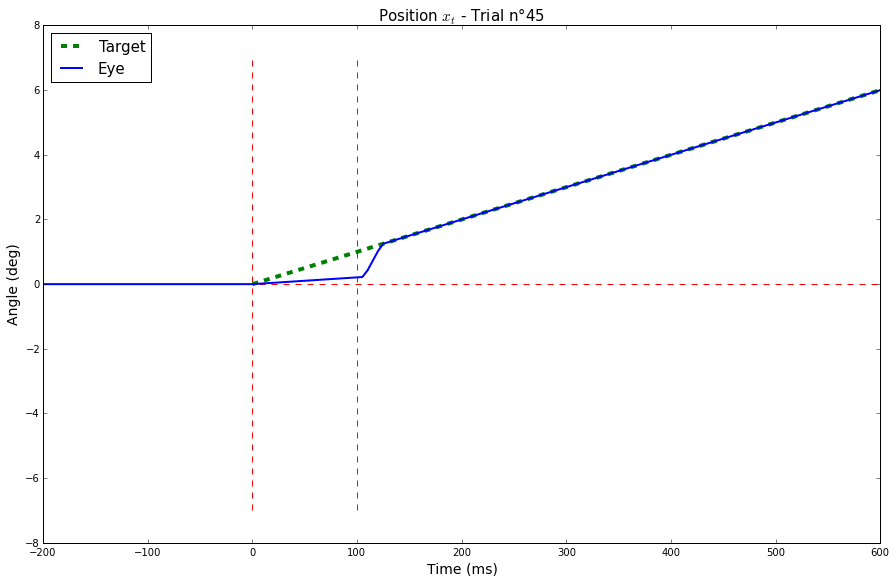

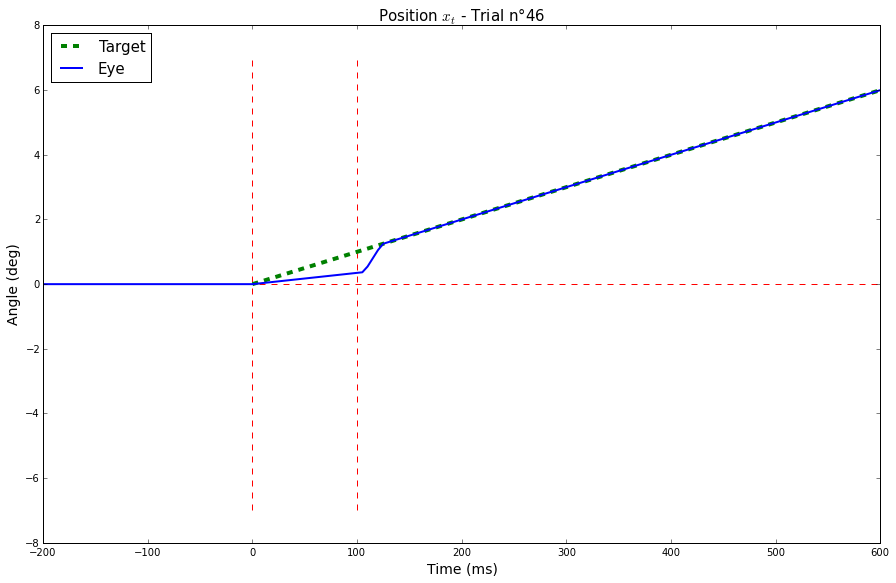

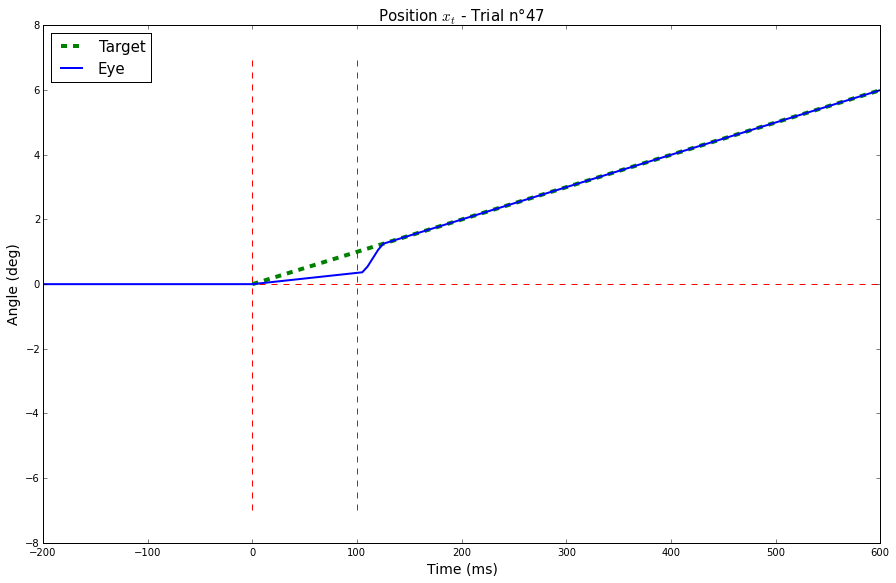

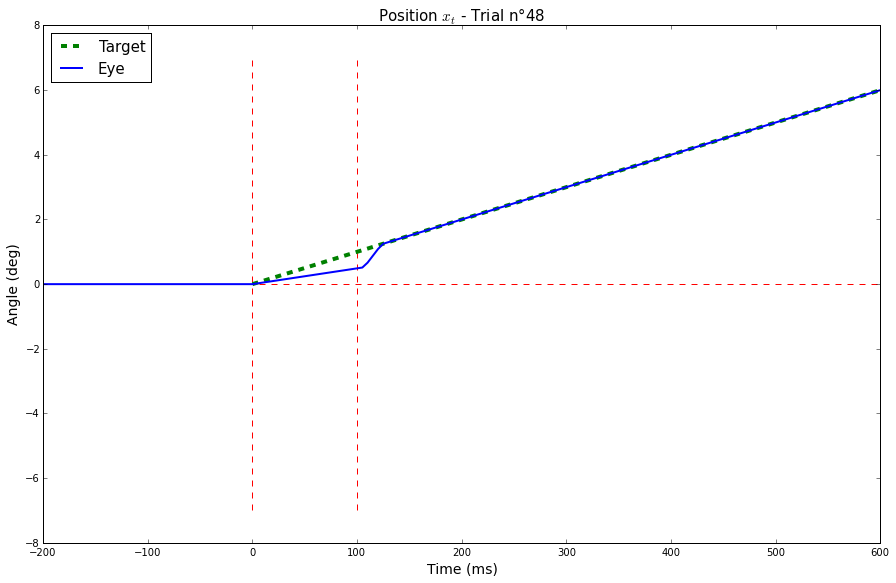

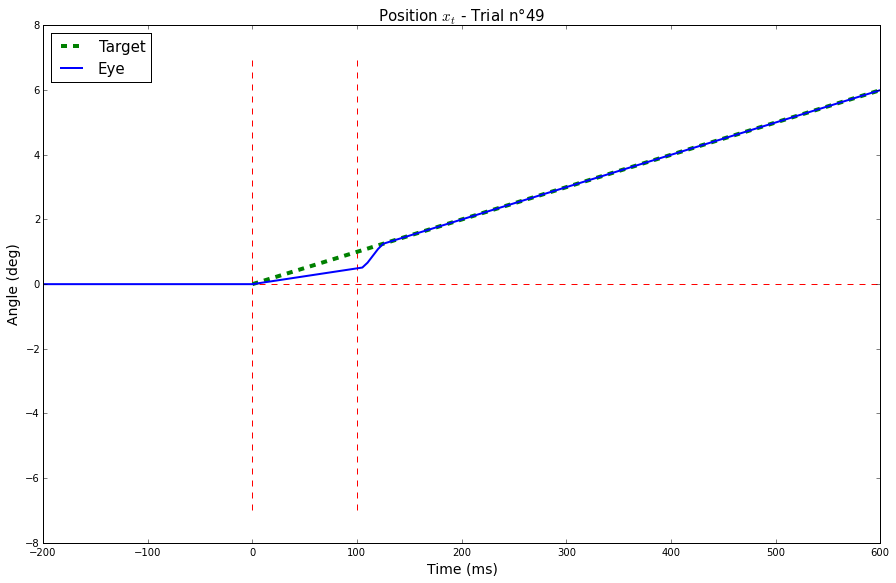

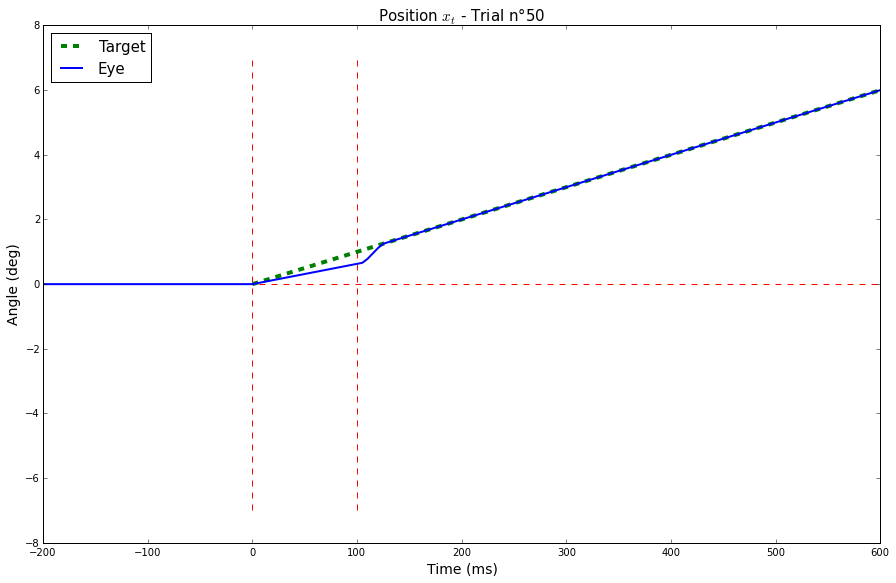

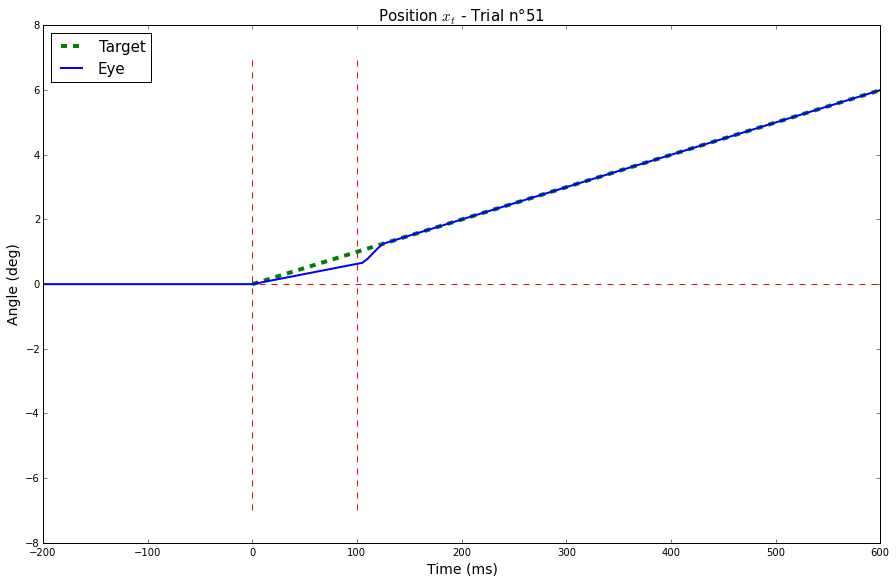

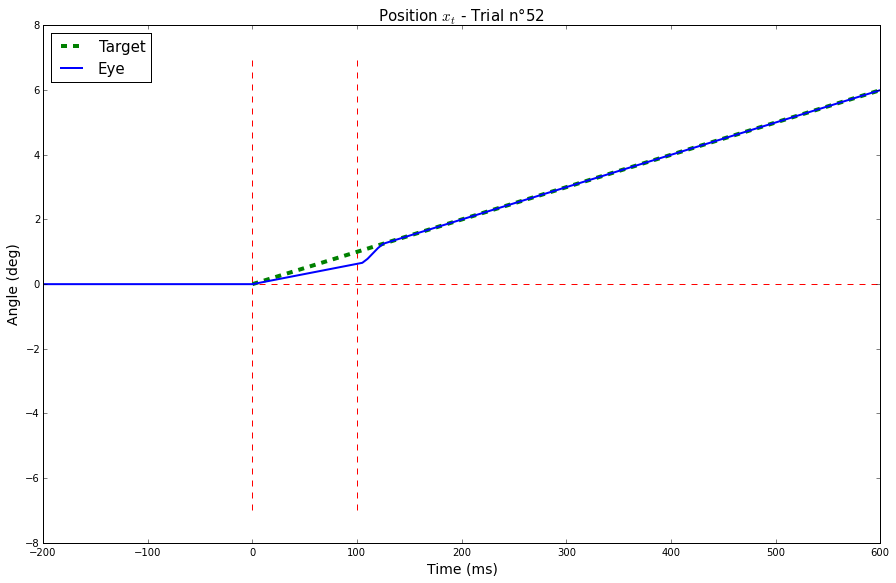

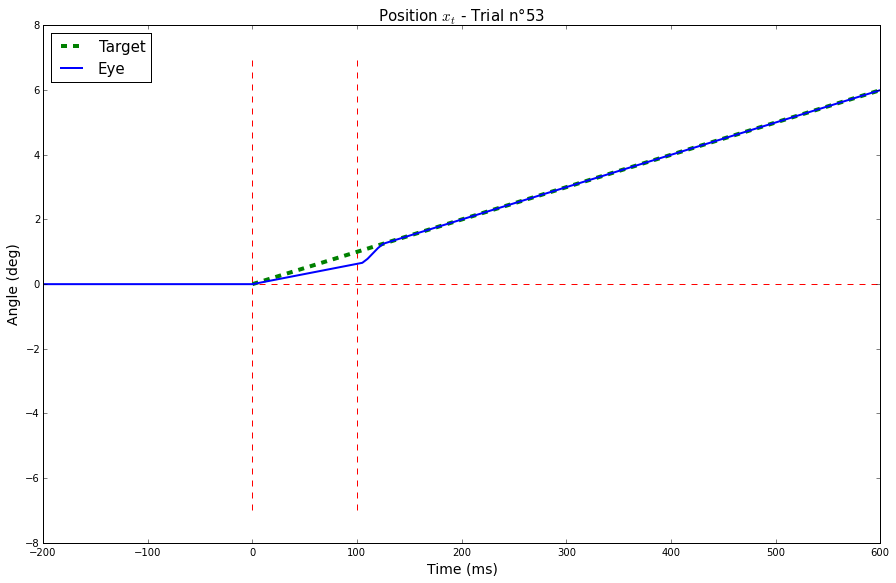

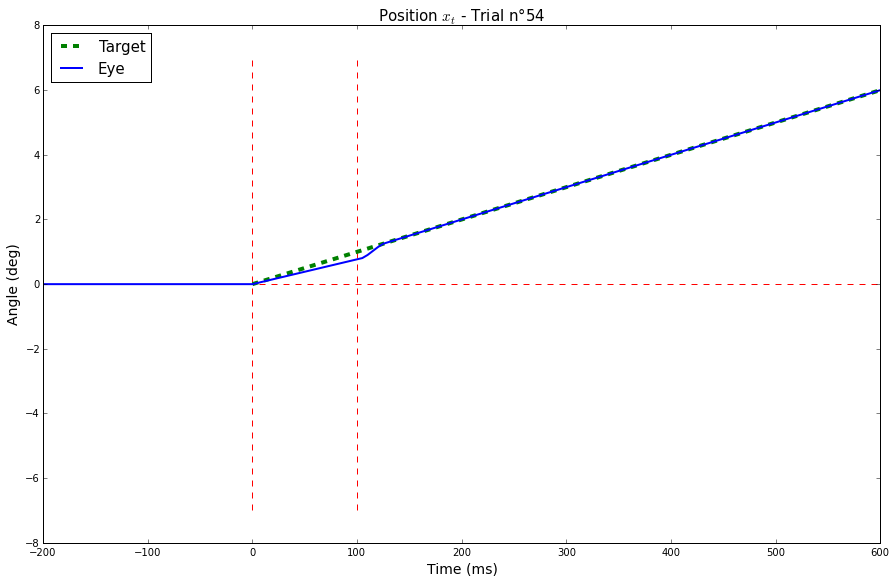

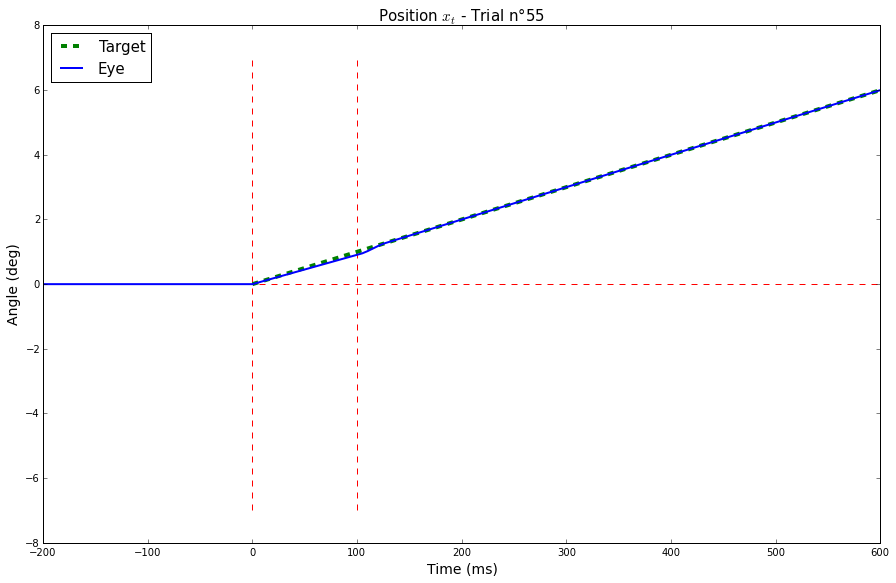

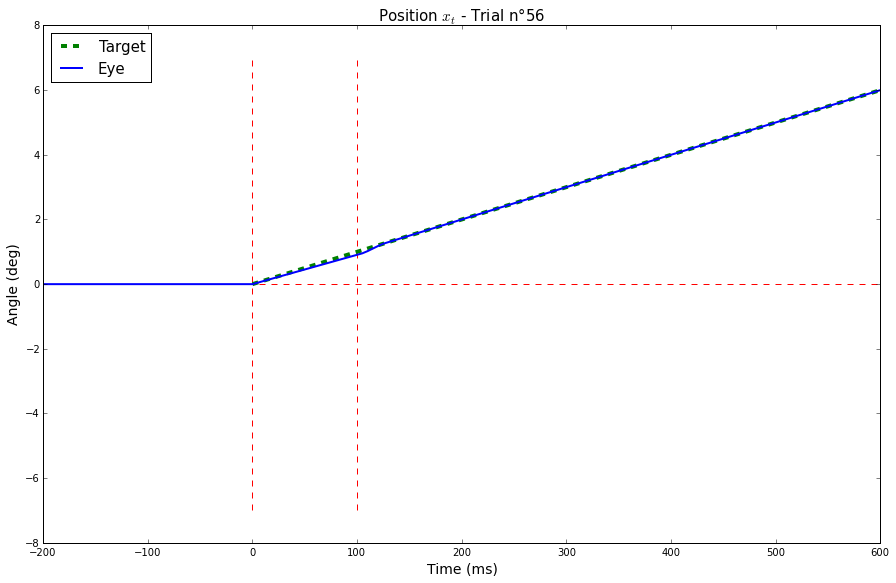

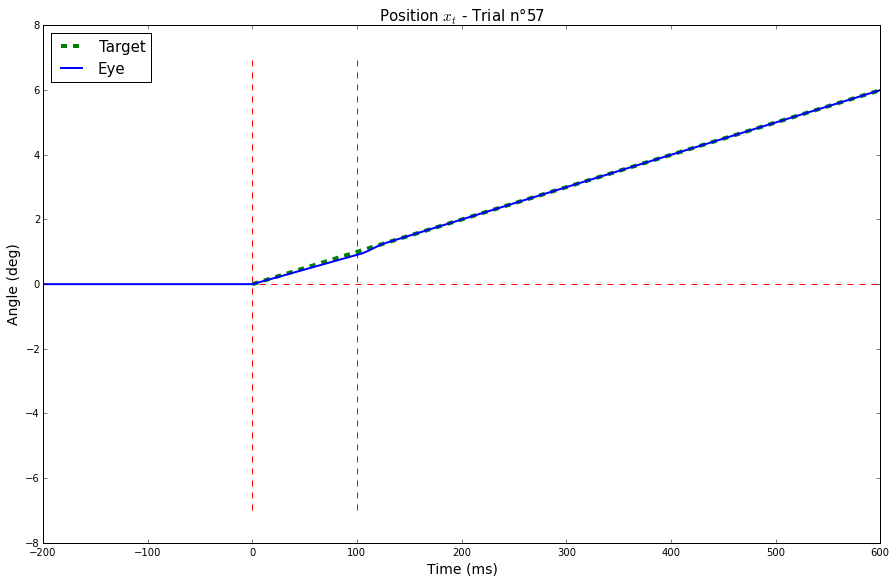

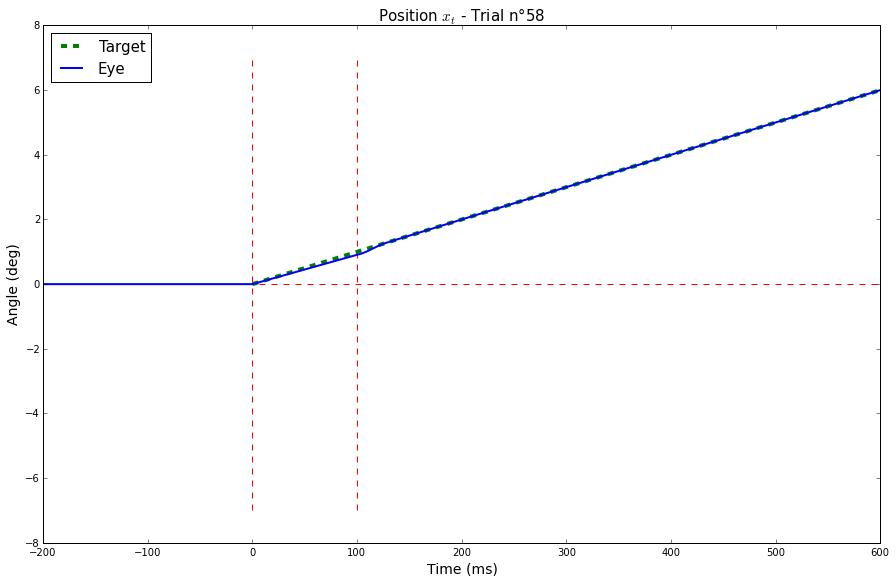

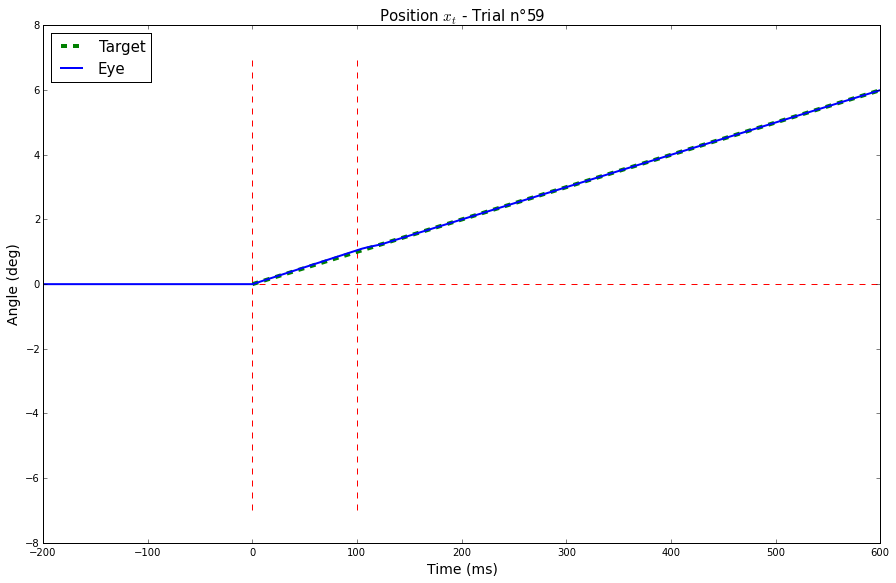

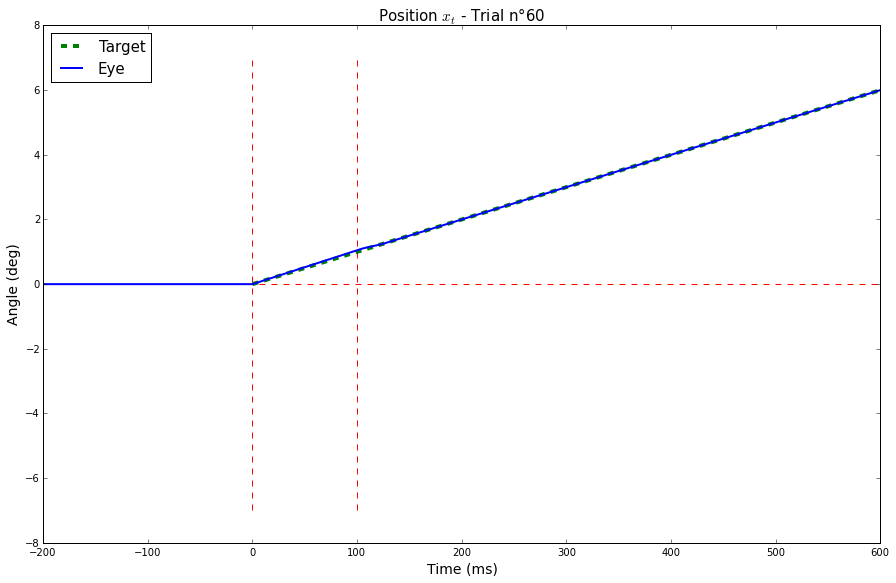

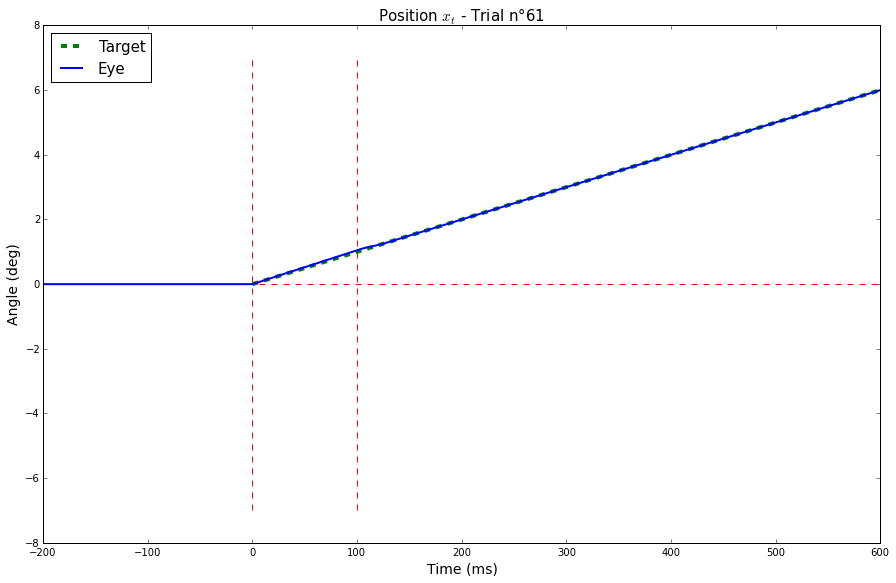

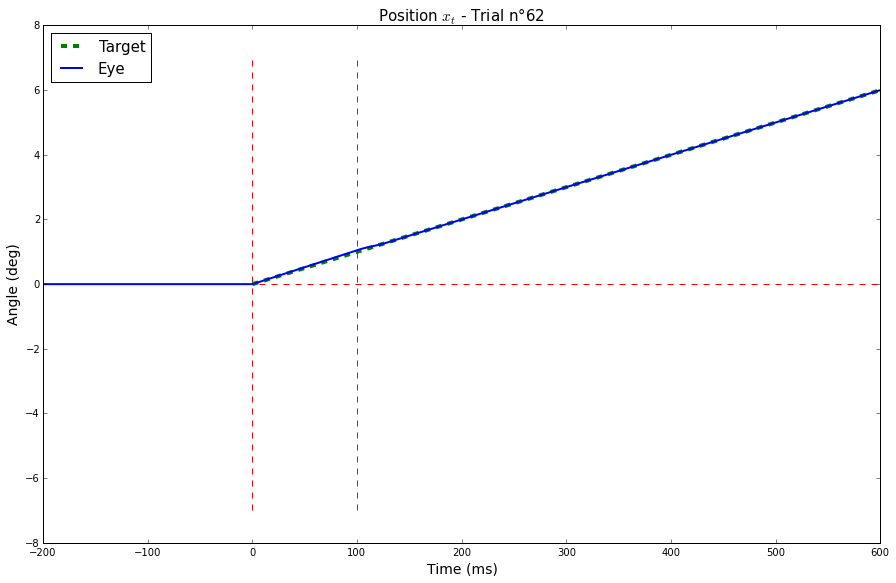

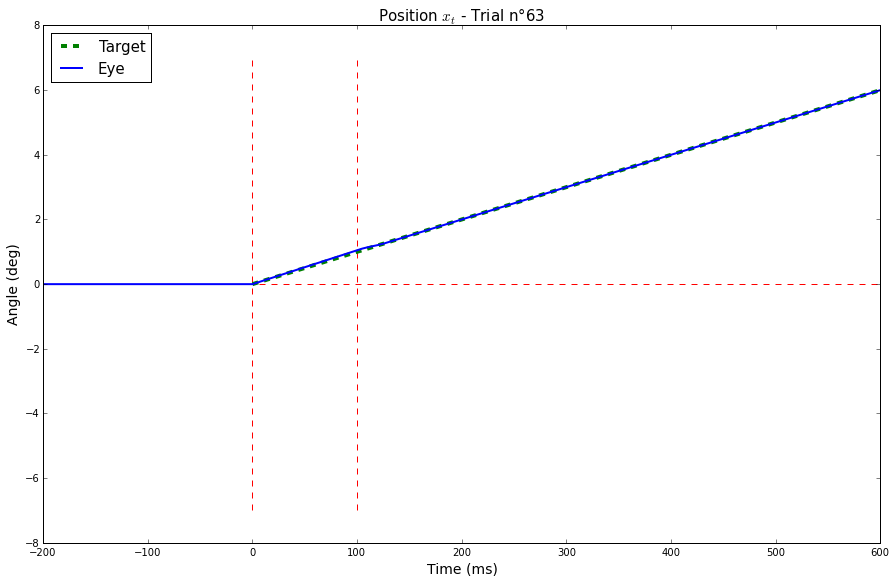

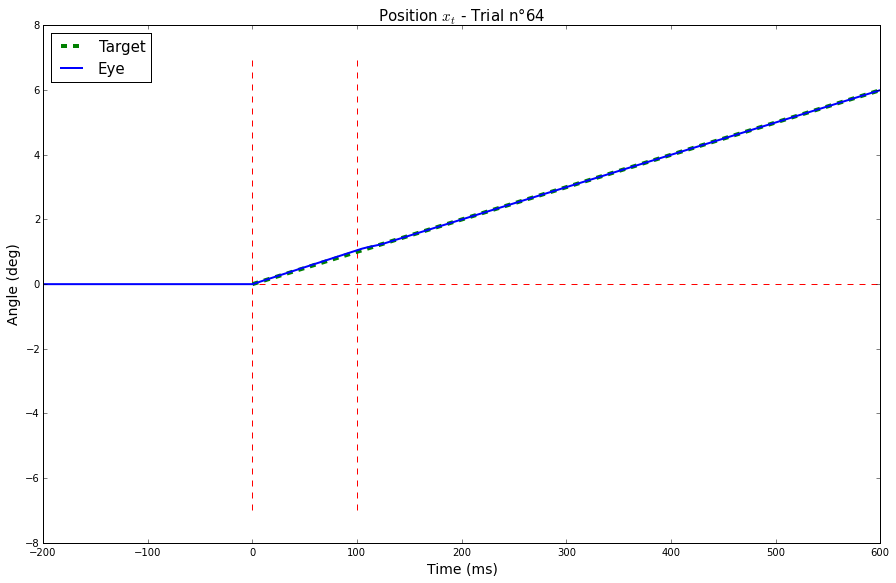

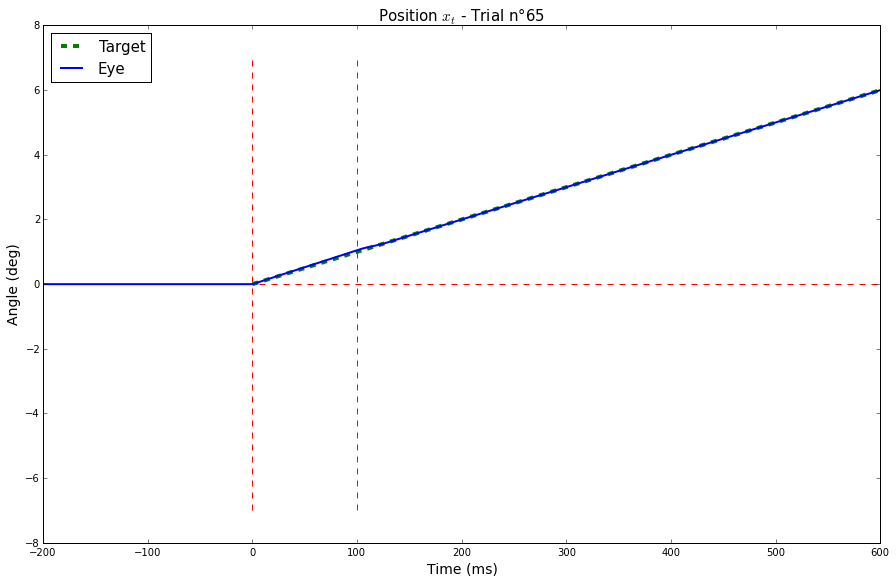

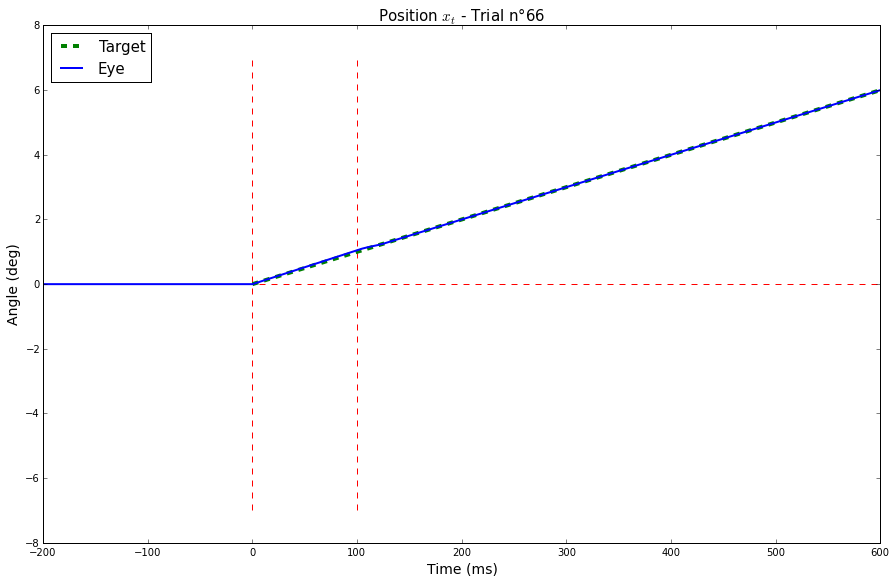

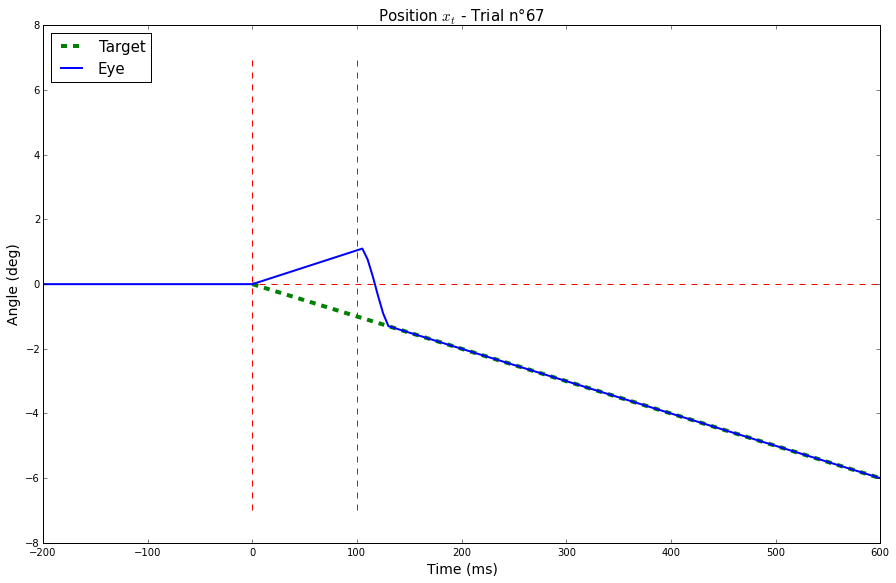

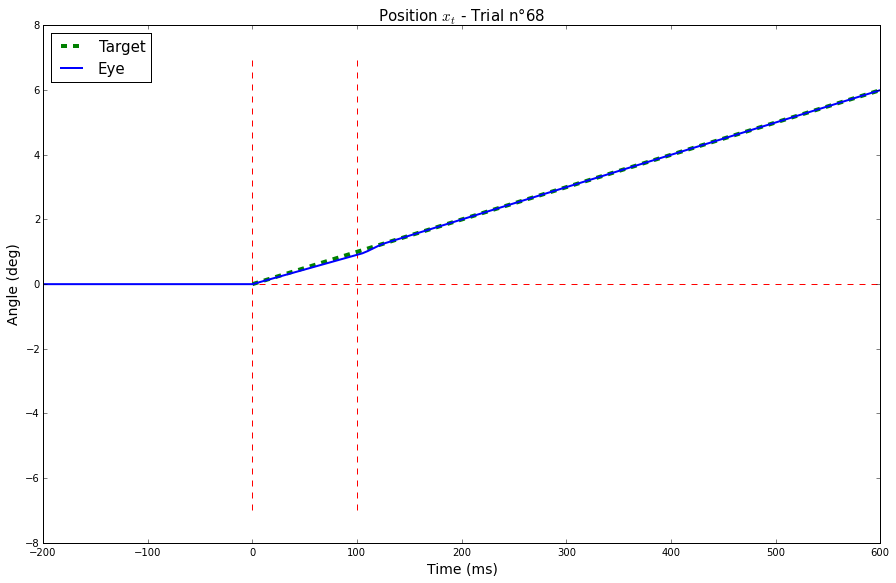

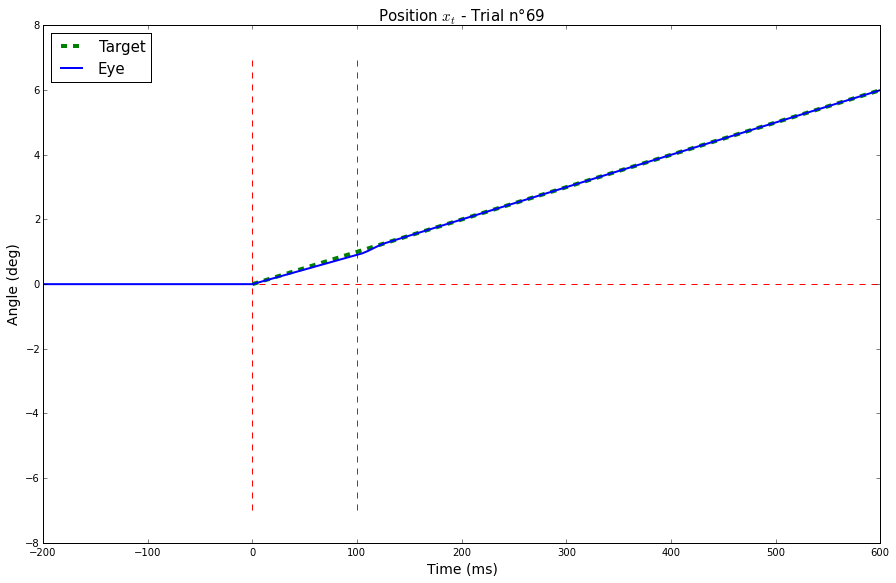

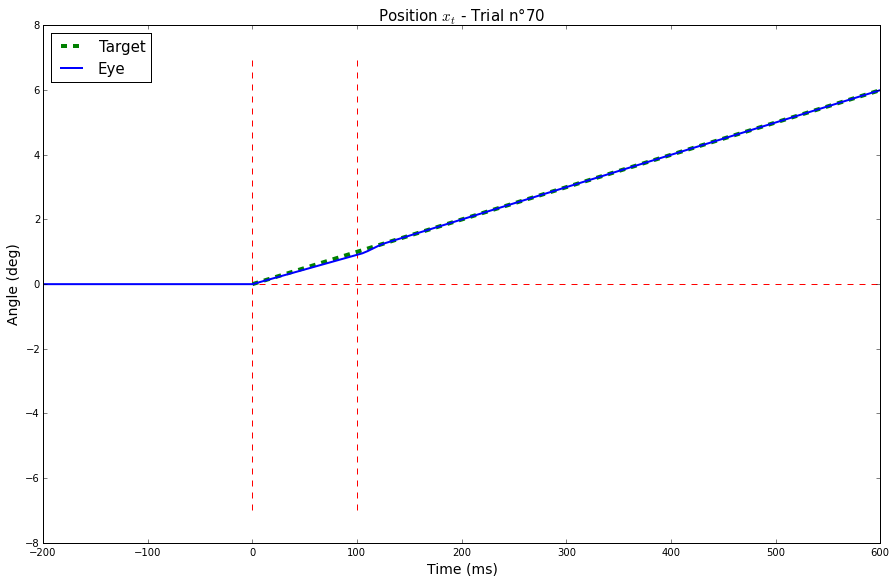

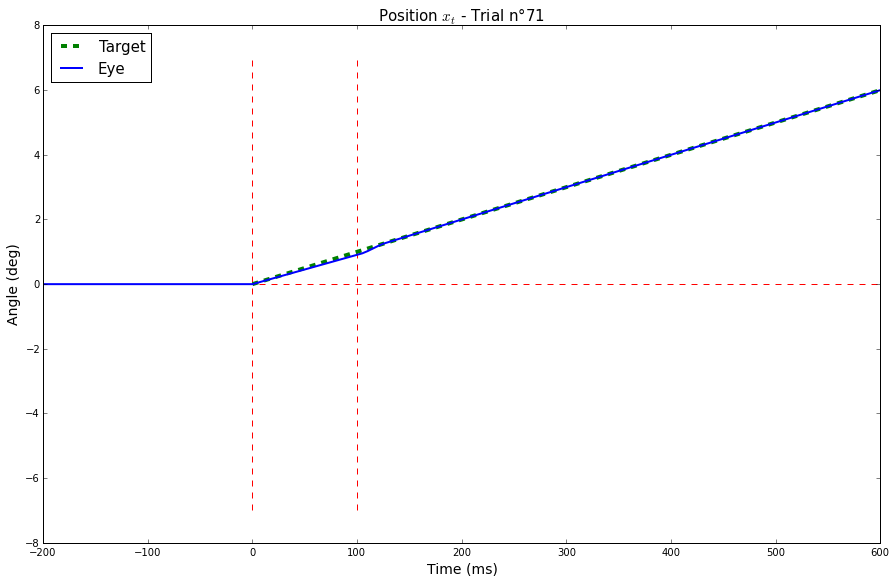

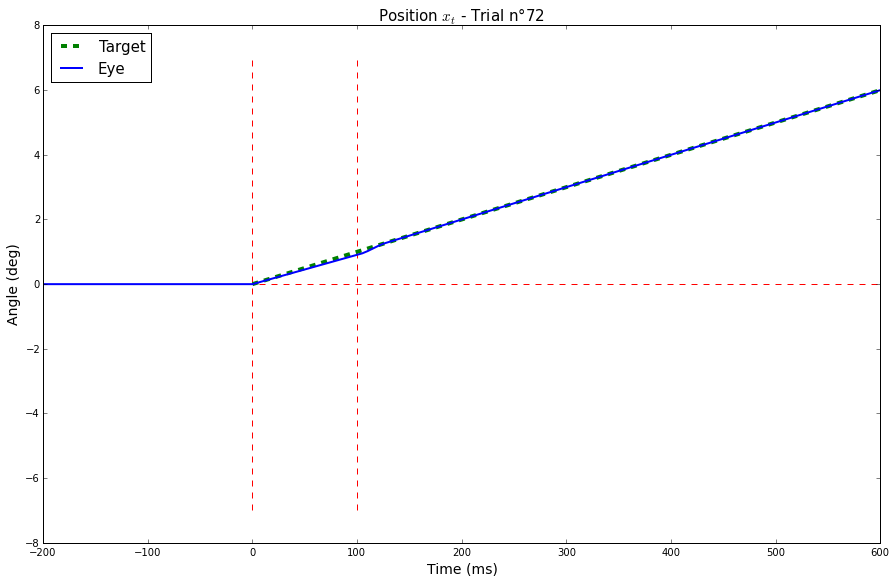

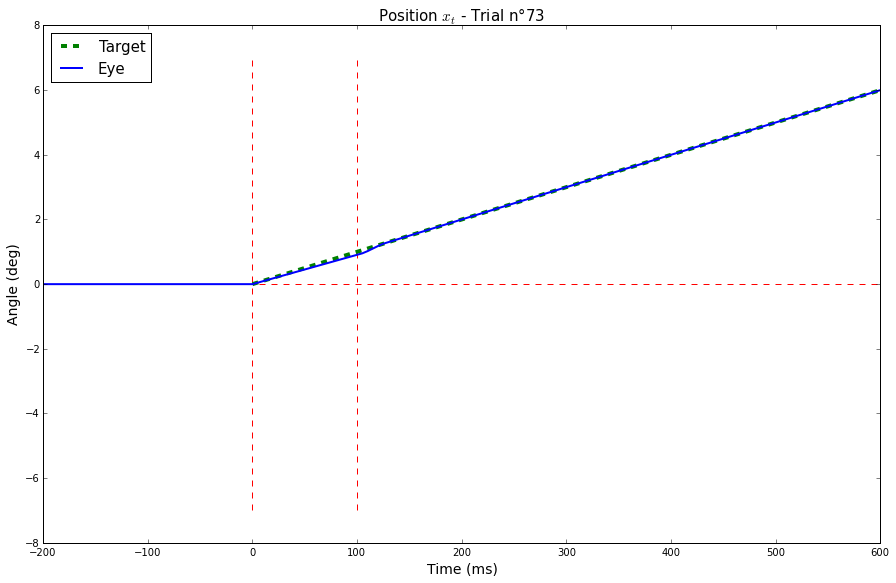

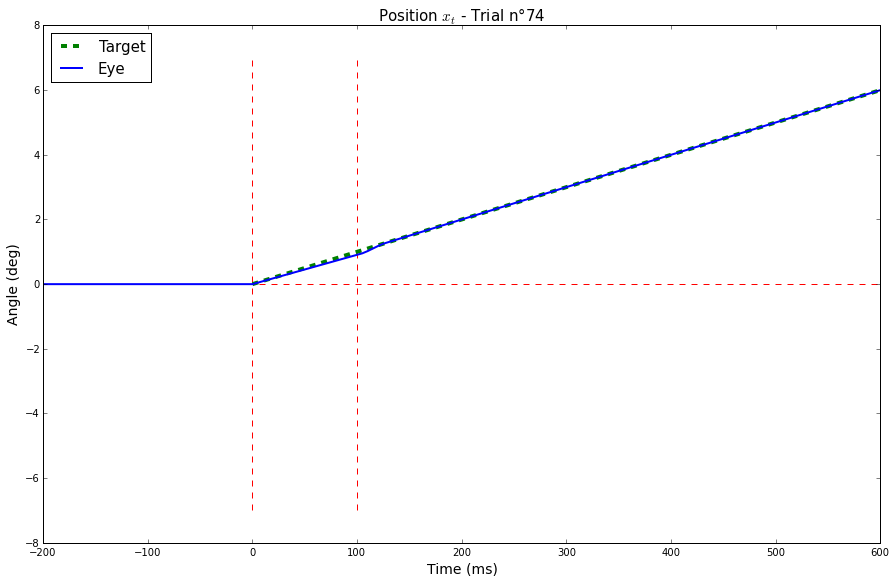

In [175]:
for i in np.arange(n_try):
    fig_width = 15
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
    plt.plot([-T_fix*5,(T_delay+T_mov)*5],[0,0],'r--')
    plt.plot([0,0],[-7,7],'r--')
    plt.plot([5*T_delay,5*T_delay],[-7,7],'r--')
    if distribution[i] > 0:
        plt.plot([0,5*(T_delay+T_mov)],[0,v*(delay+t_T+t_R)],color='g', lw=4, ls ='--', label="Target")
    else:
        plt.plot([0,5*(T_delay+T_mov)],[0,-v*(delay+t_T+t_R)],color='g', lw=4, ls ='--', label="Target")
    plt.plot(time_ms, pos_rec[i, :], lw=2, label="Eye")
    ax.set_title(r'Position $x_t$ - Trial n°'+str(i), fontsize = 15)
    ax.set_xlabel('Time (ms)', fontsize=14)
    ax.set_ylabel('Angle (deg)', fontsize=14)
    ax.set_xlim(-T_fix*5,(T_delay+T_mov)*5)
    ax.legend(loc='upper left',prop={'size':15})

    plt.show()

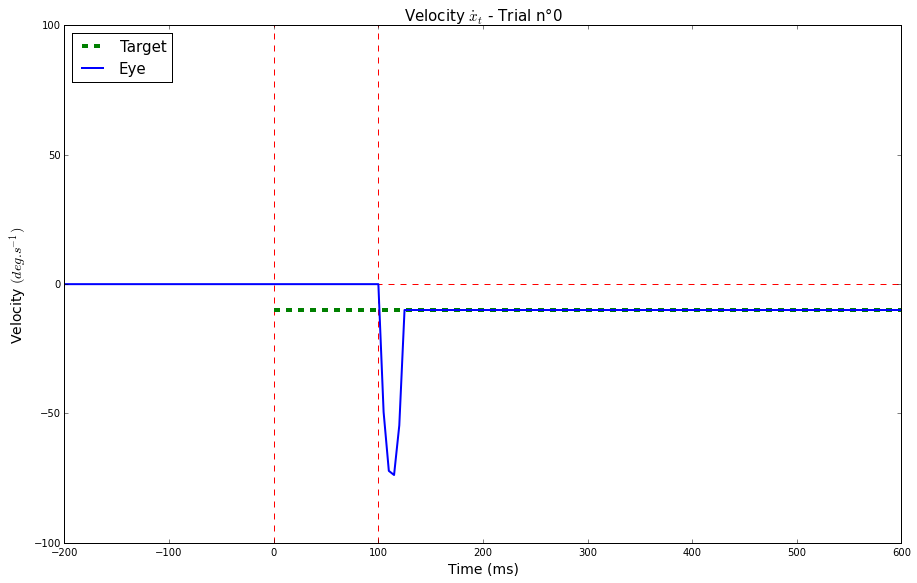

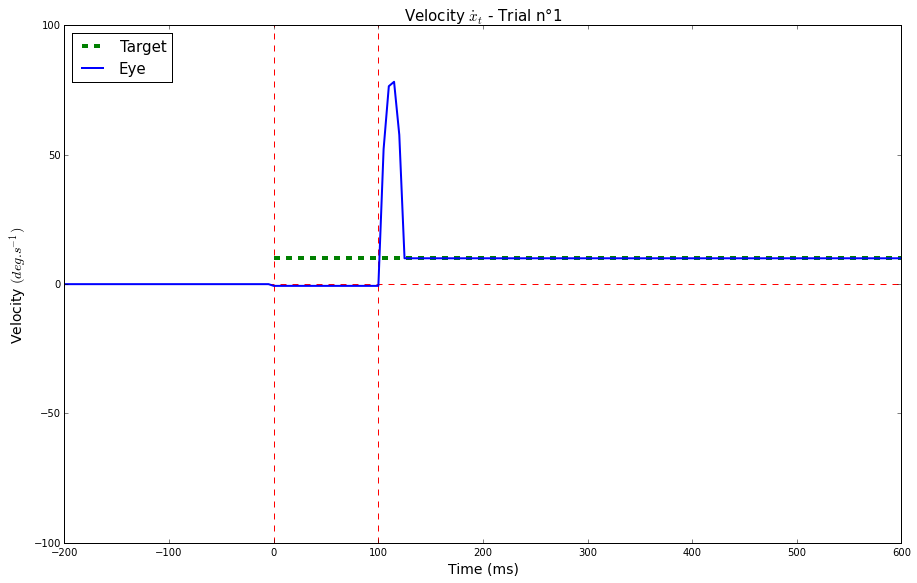

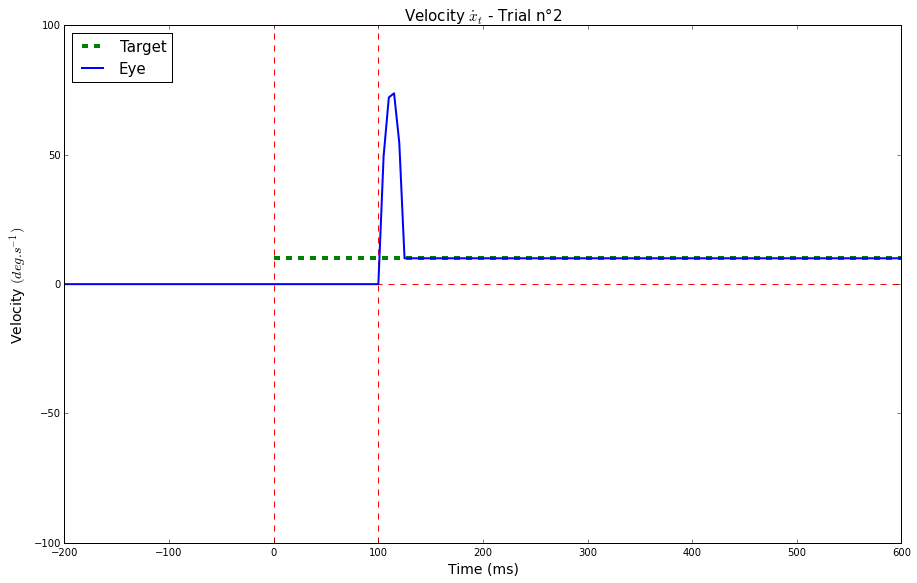

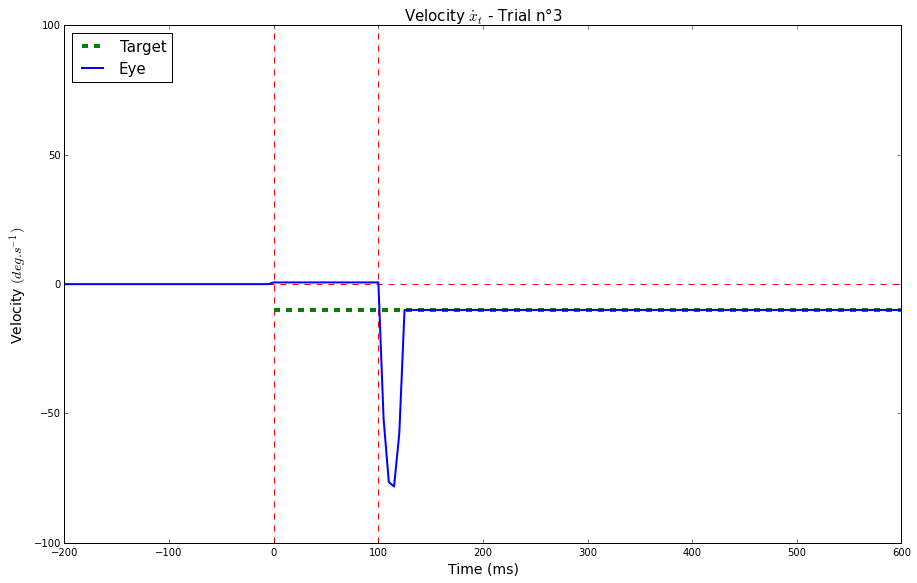

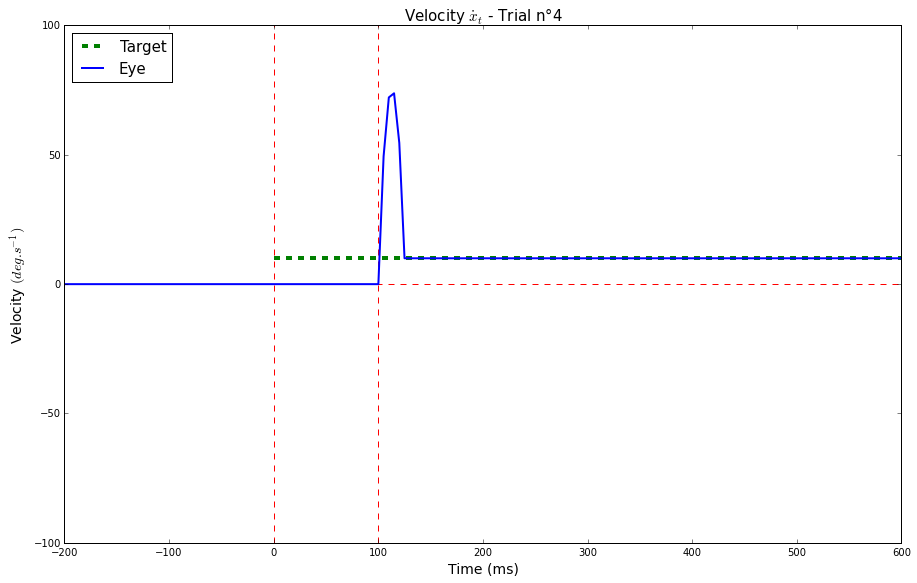

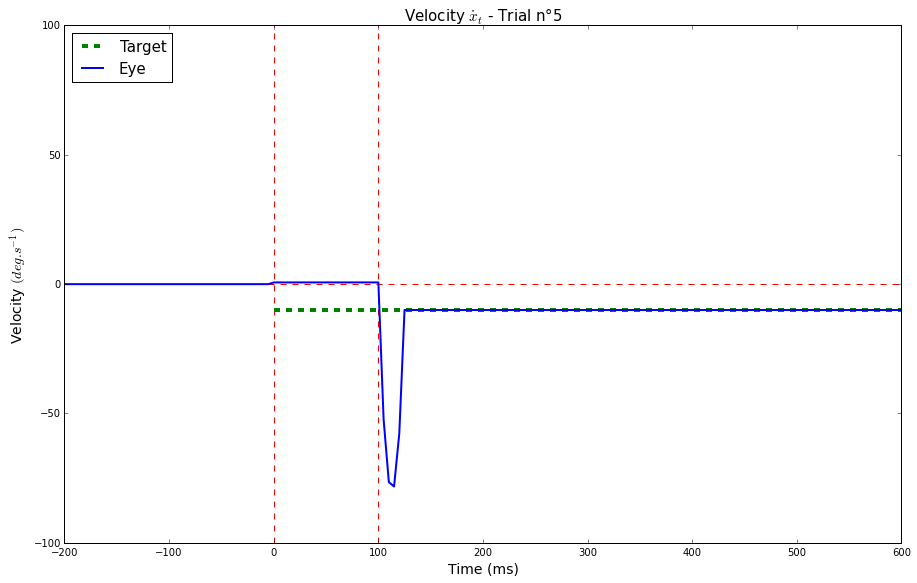

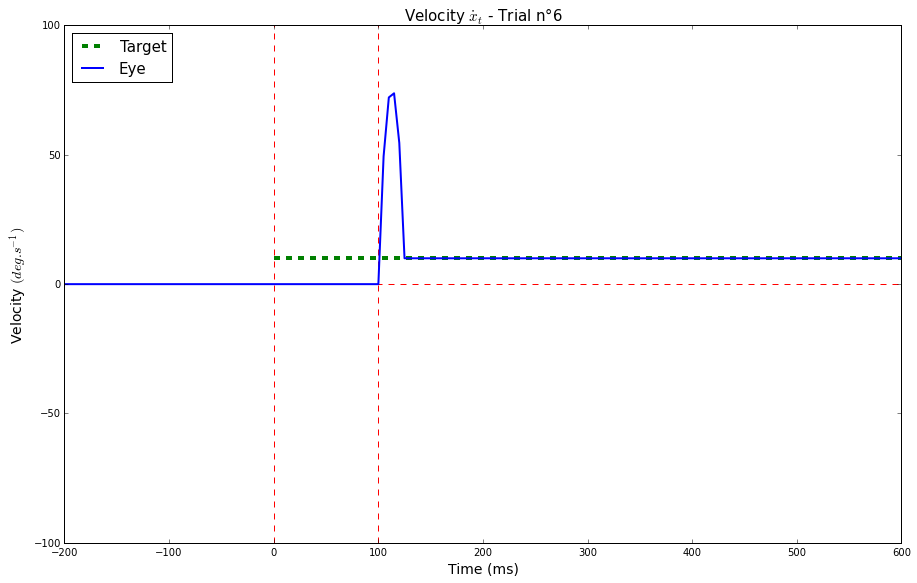

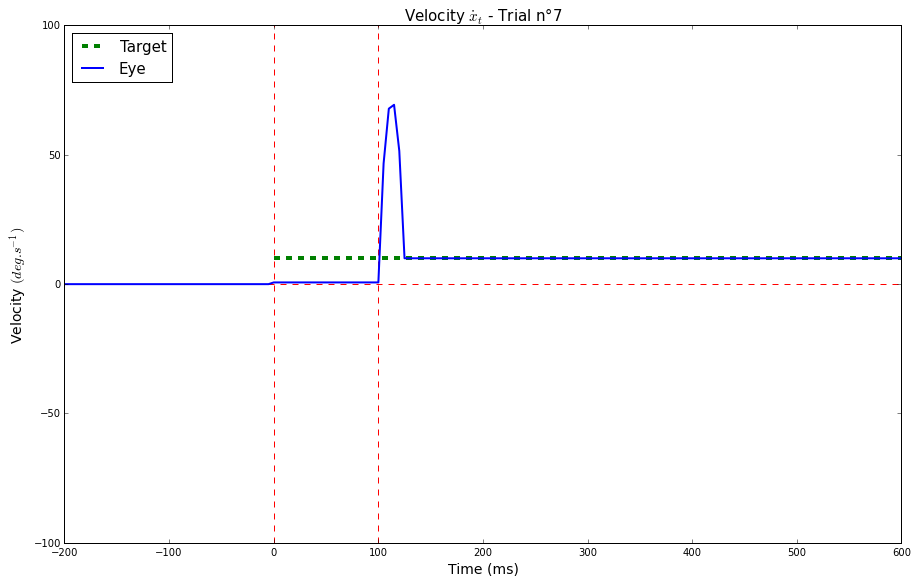

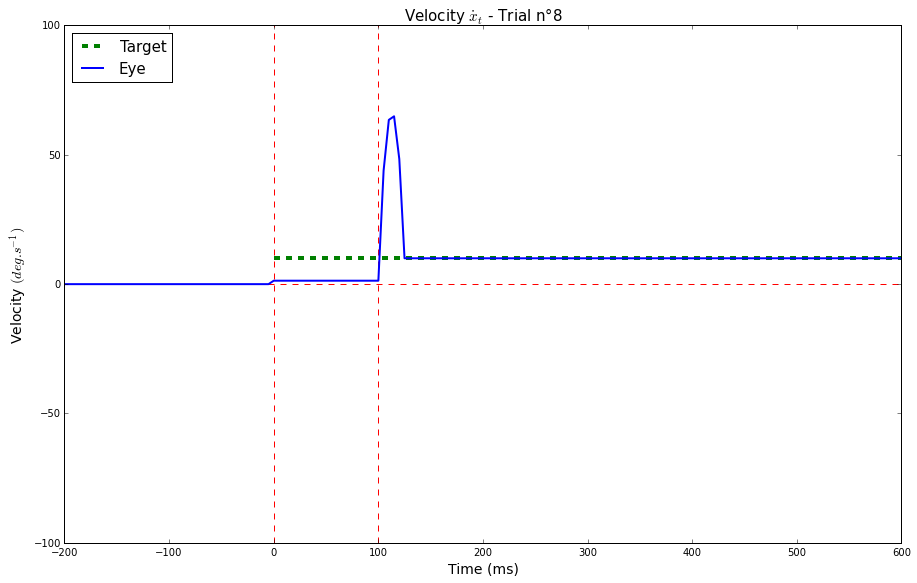

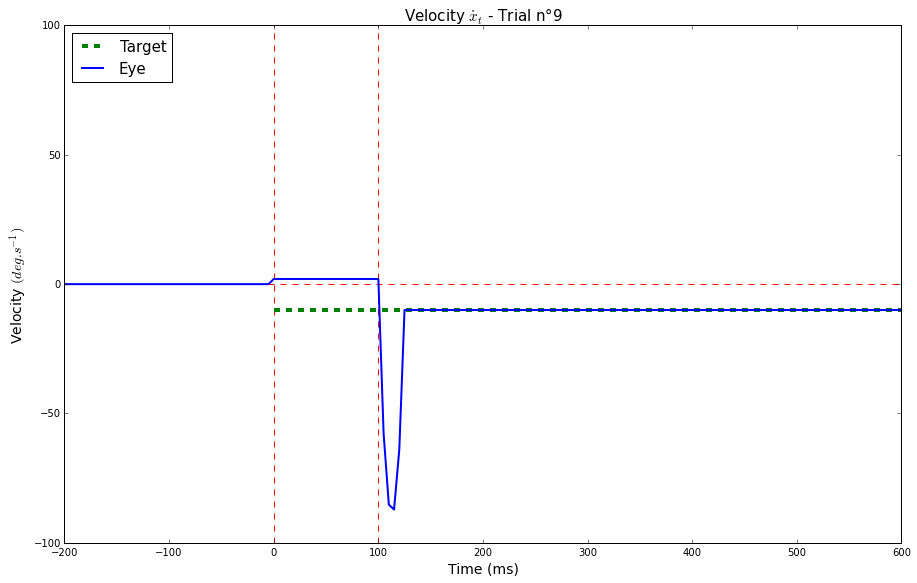

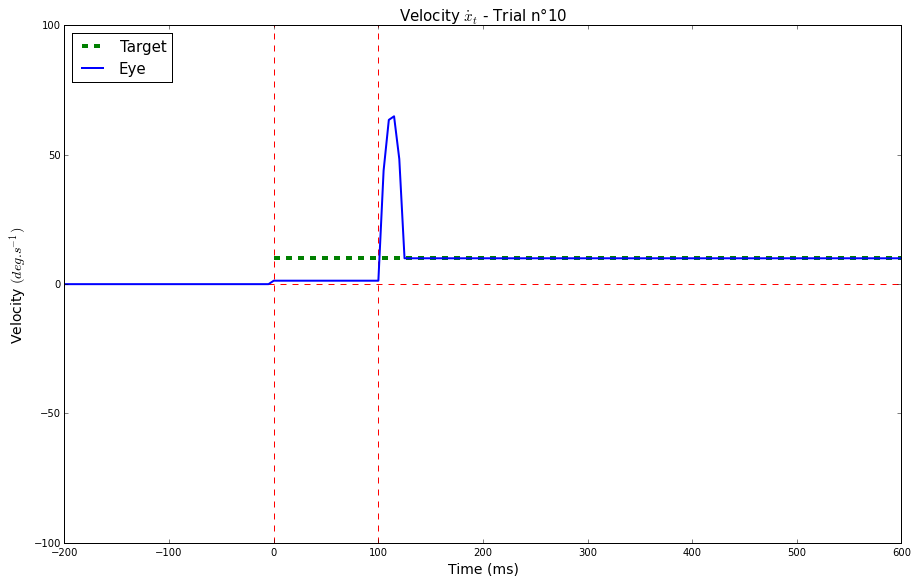

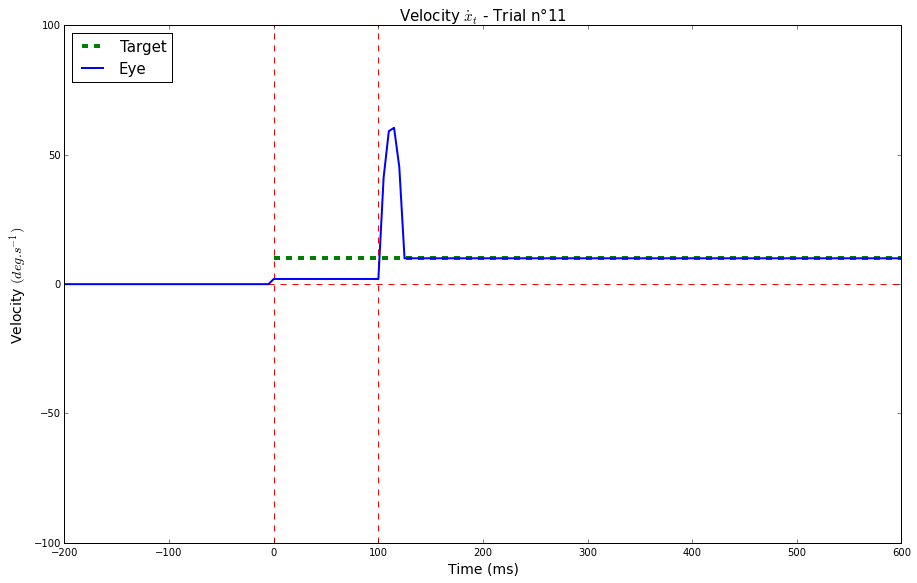

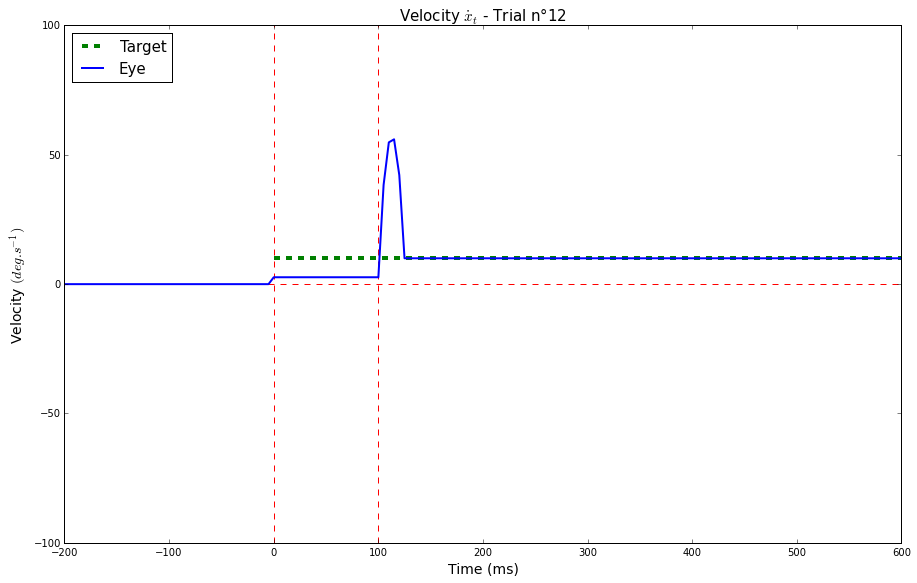

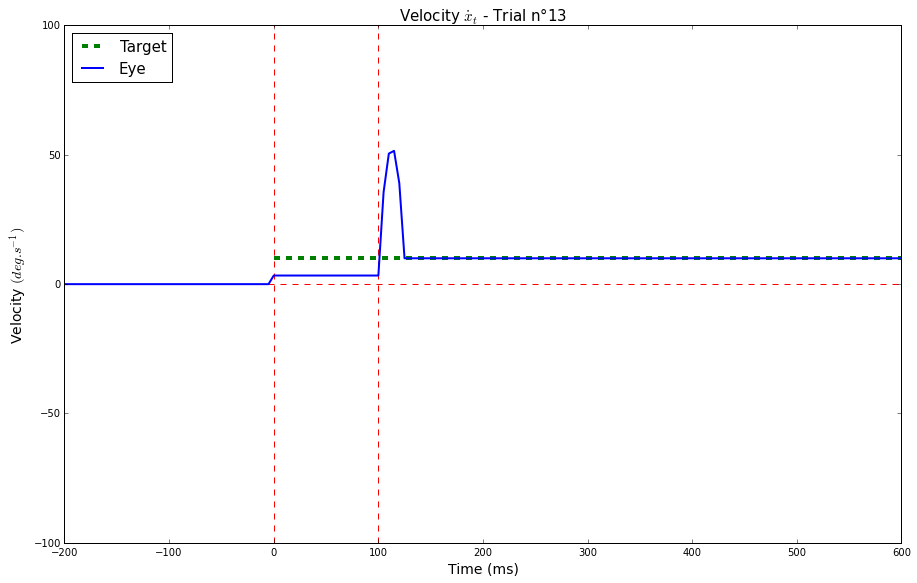

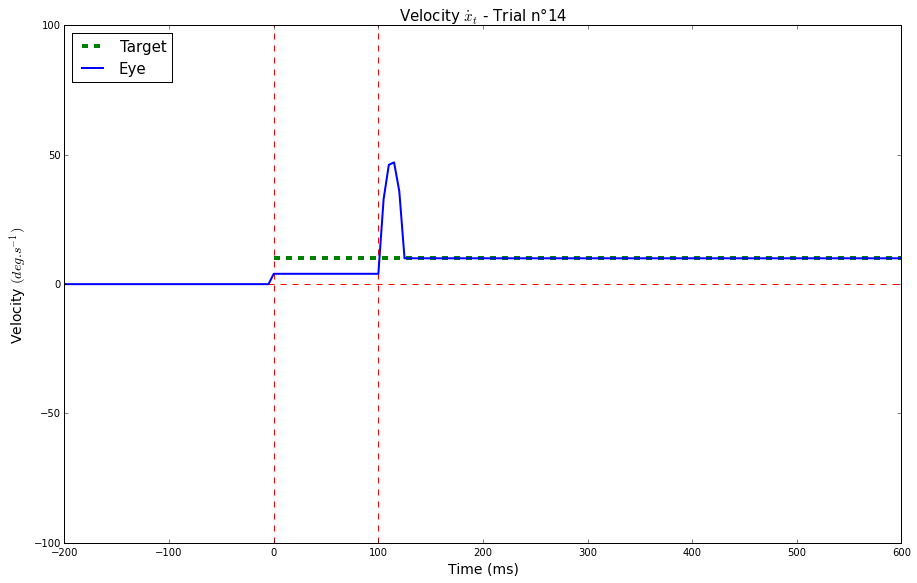

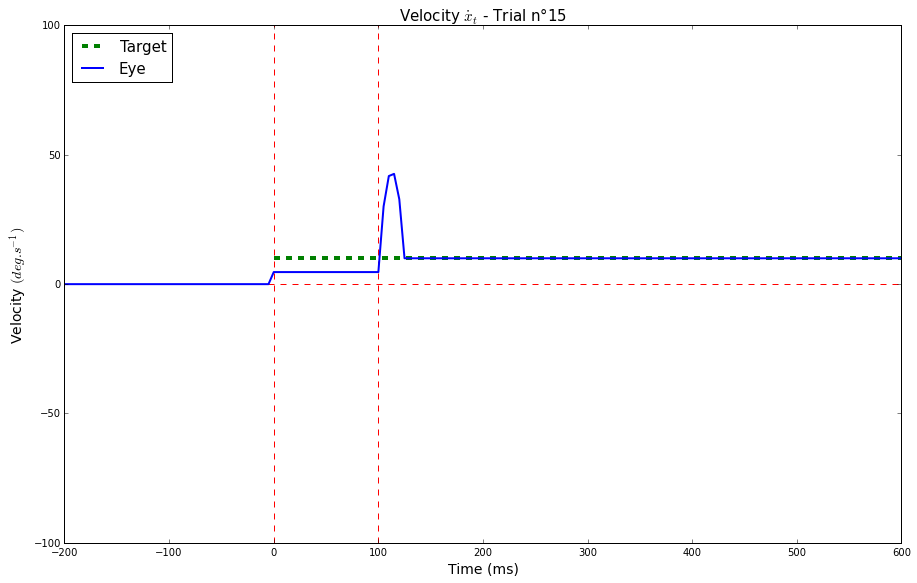

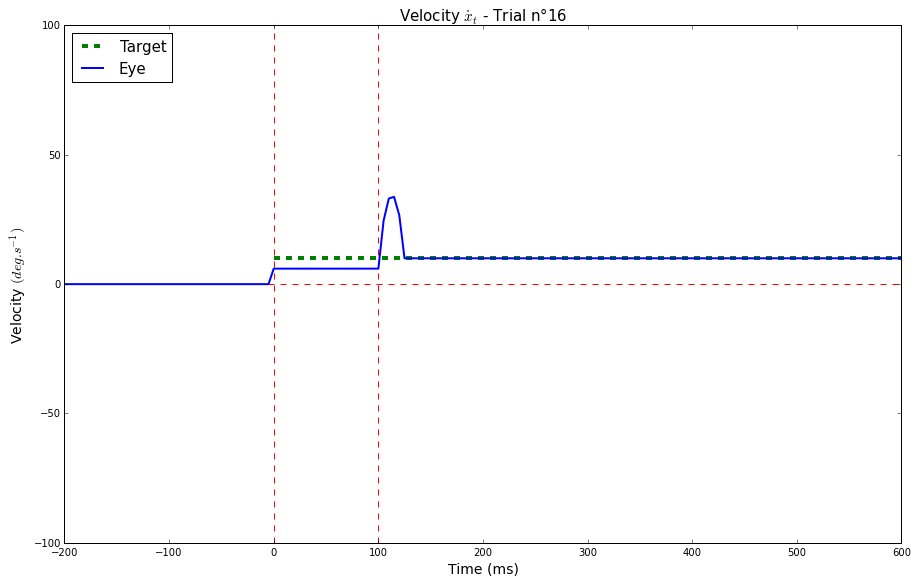

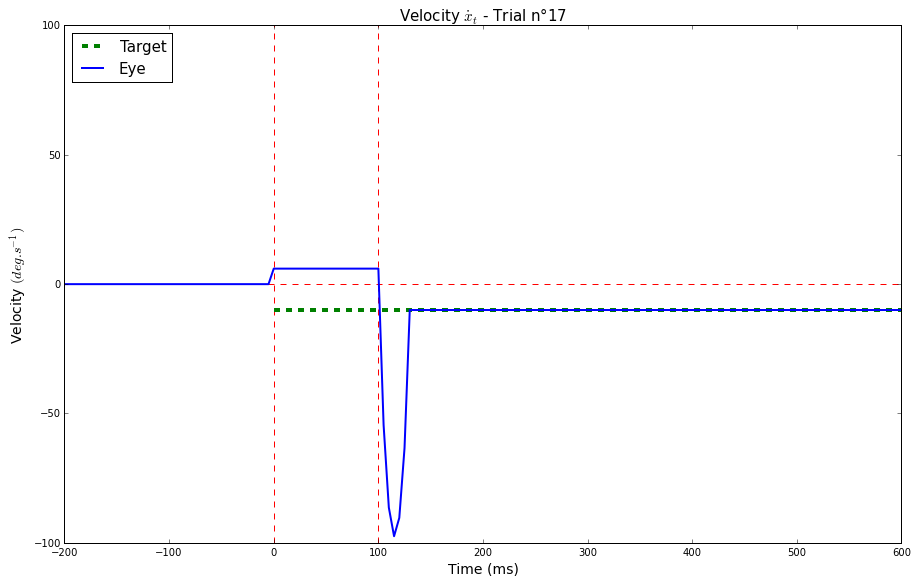

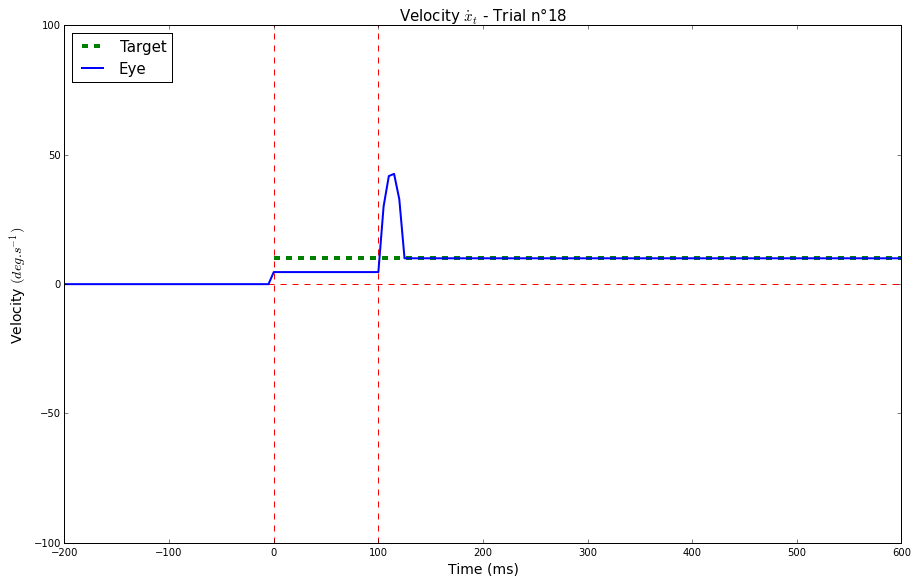

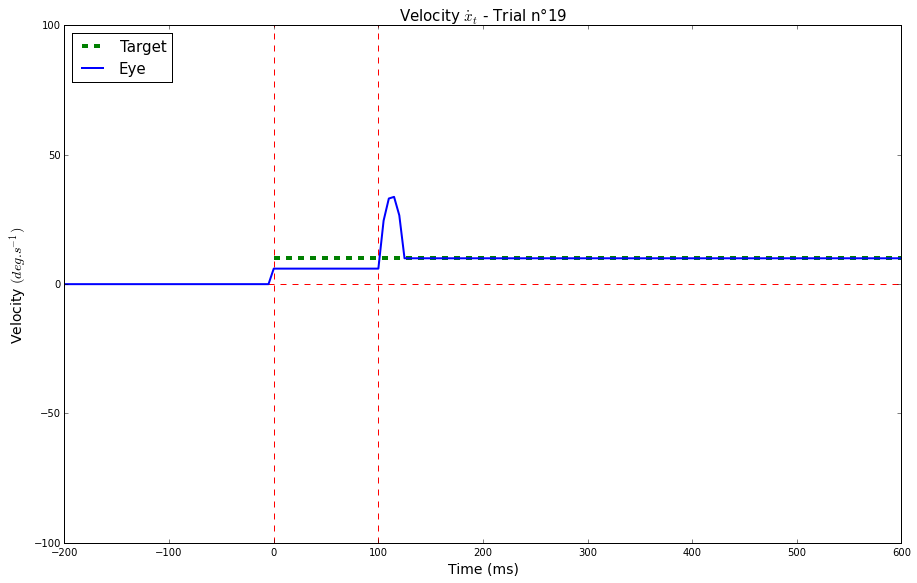

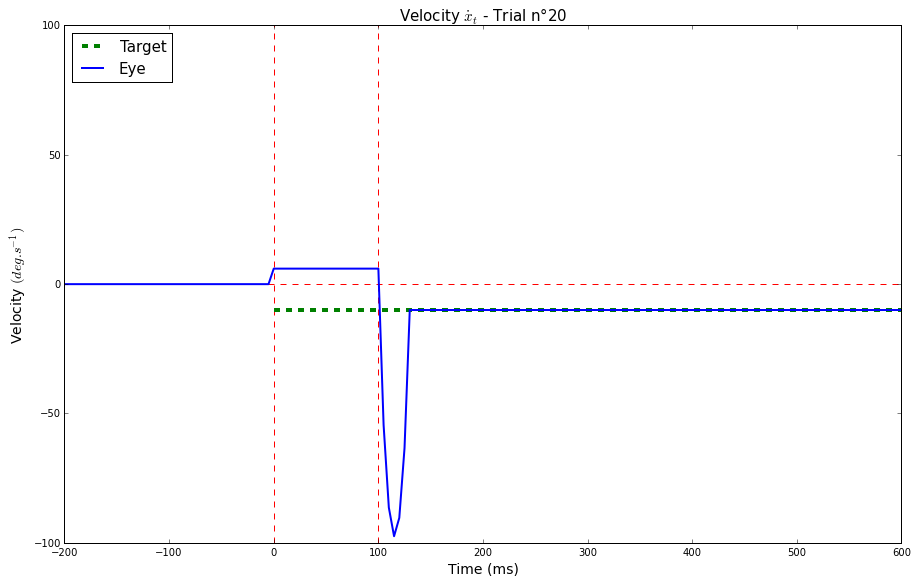

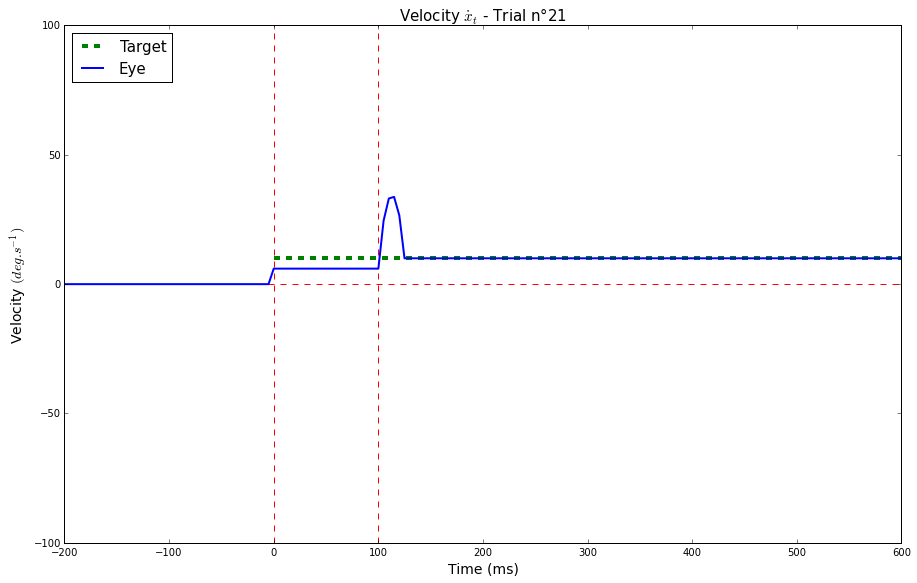

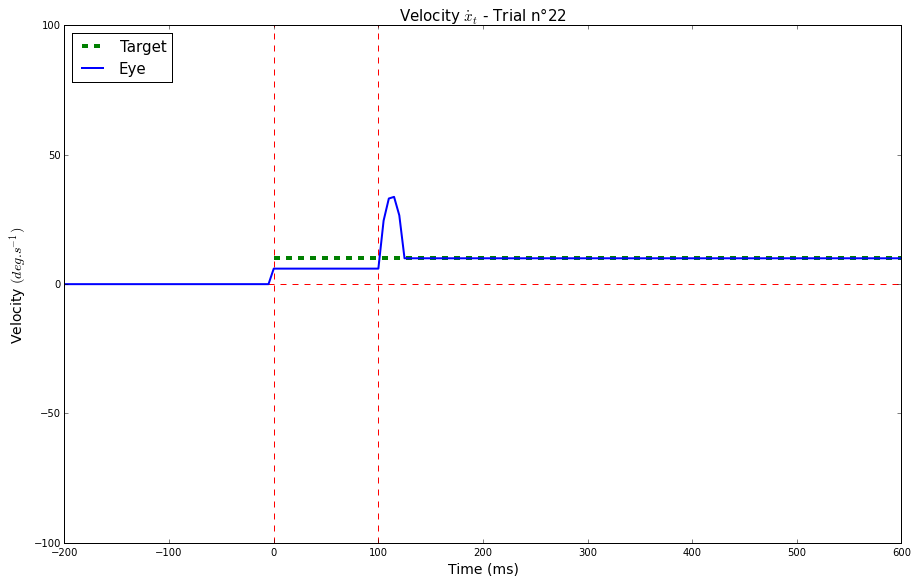

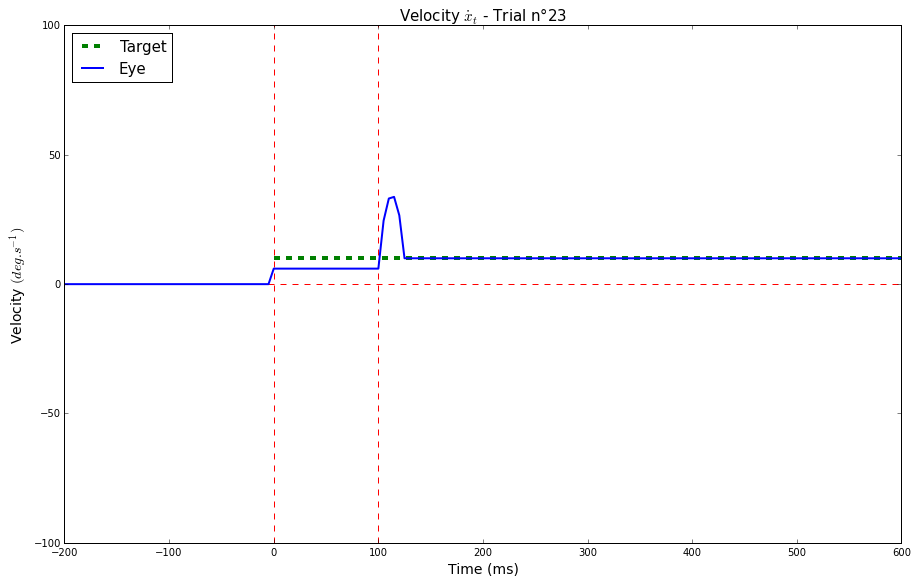

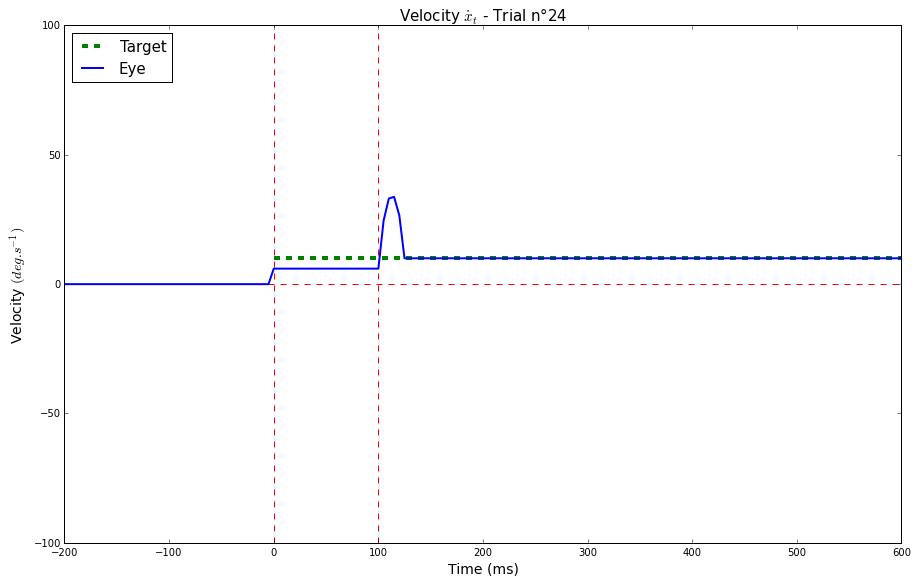

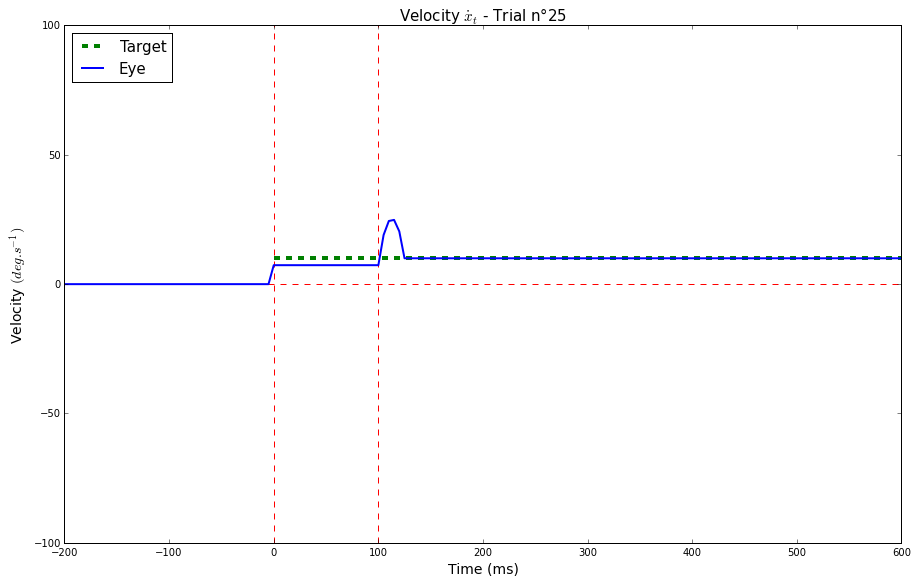

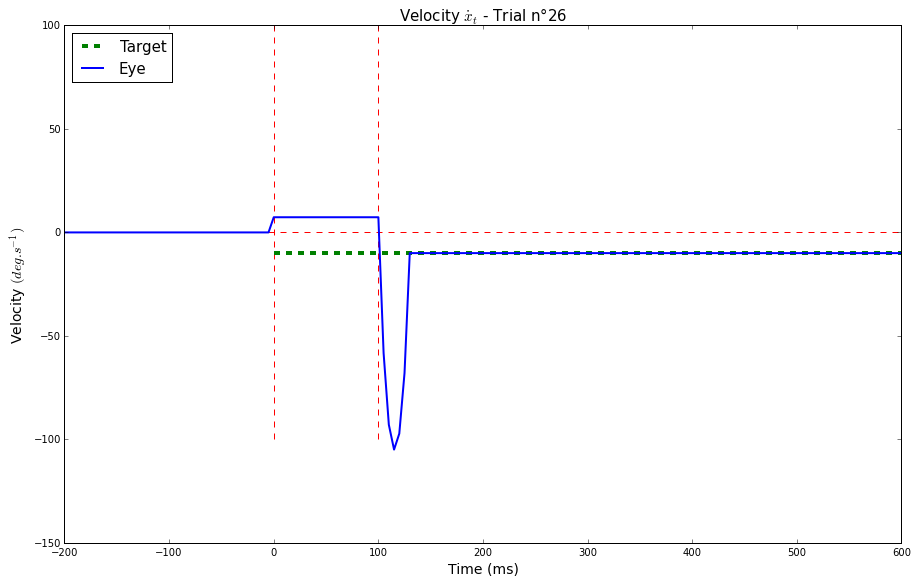

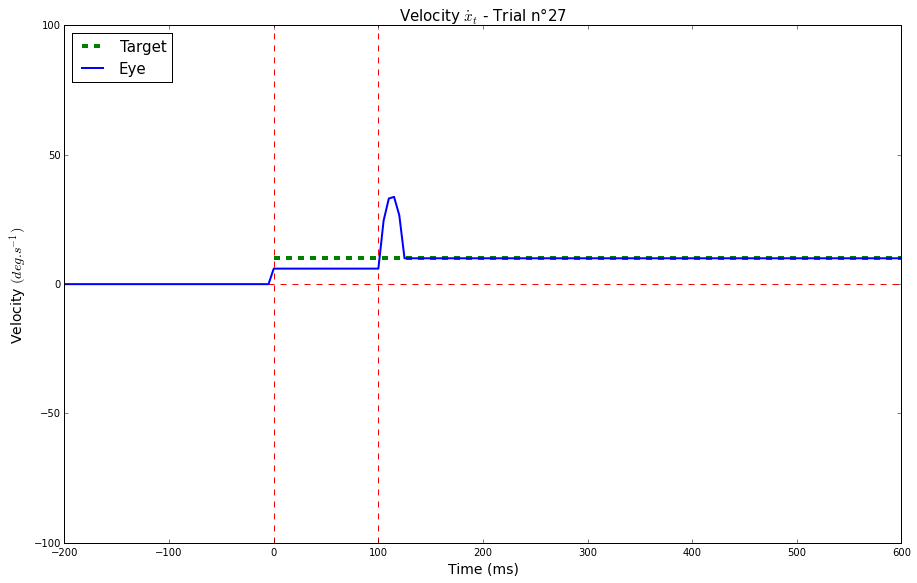

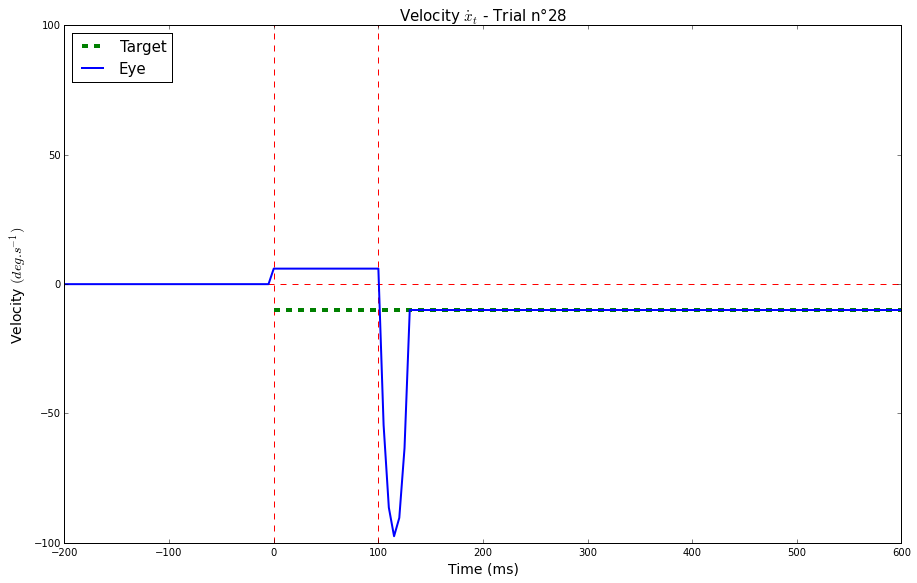

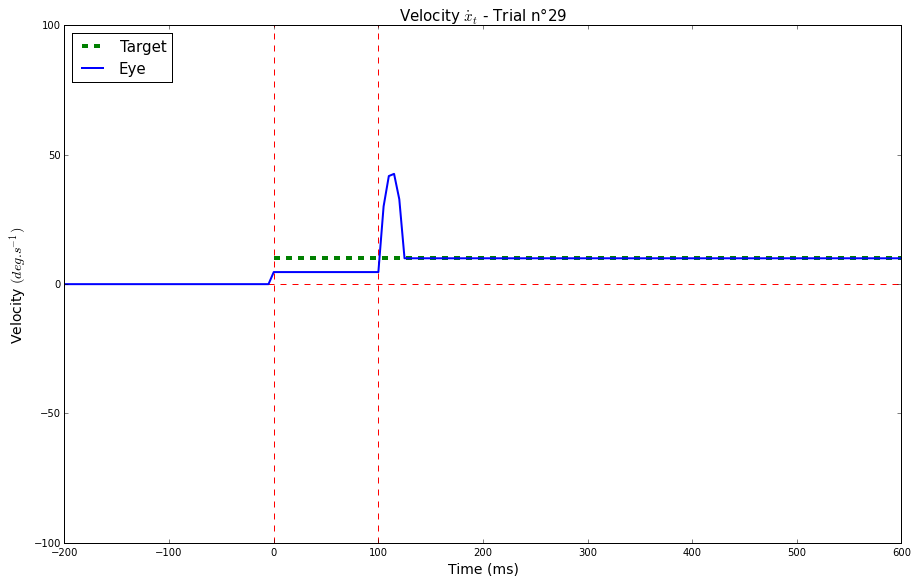

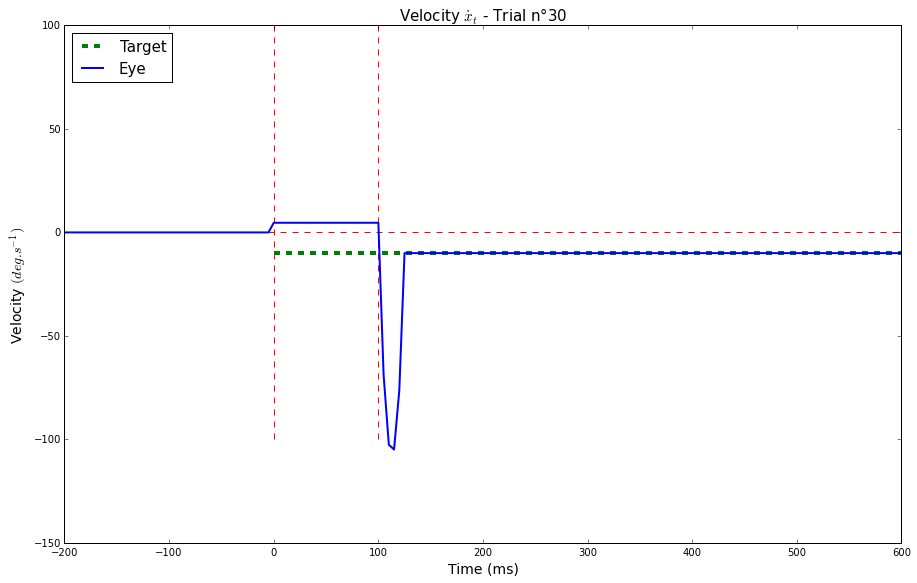

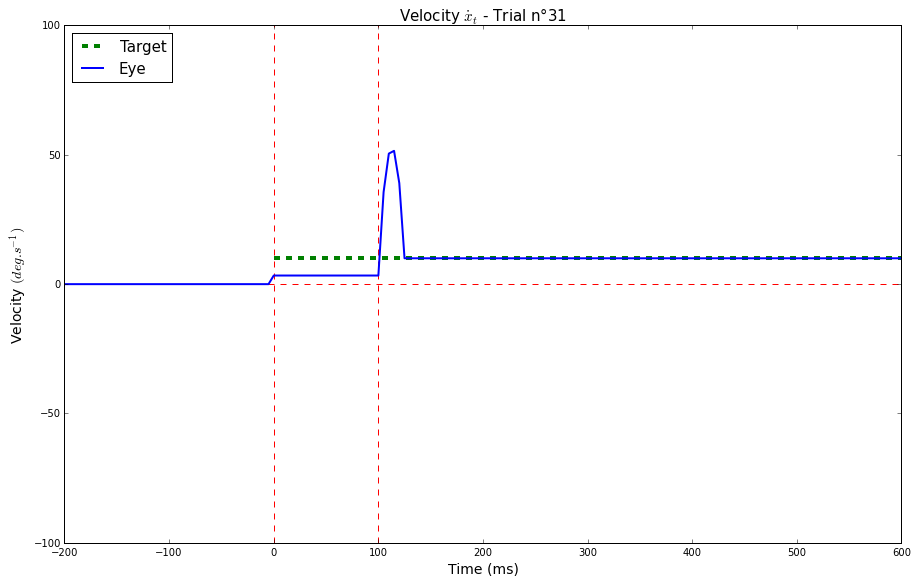

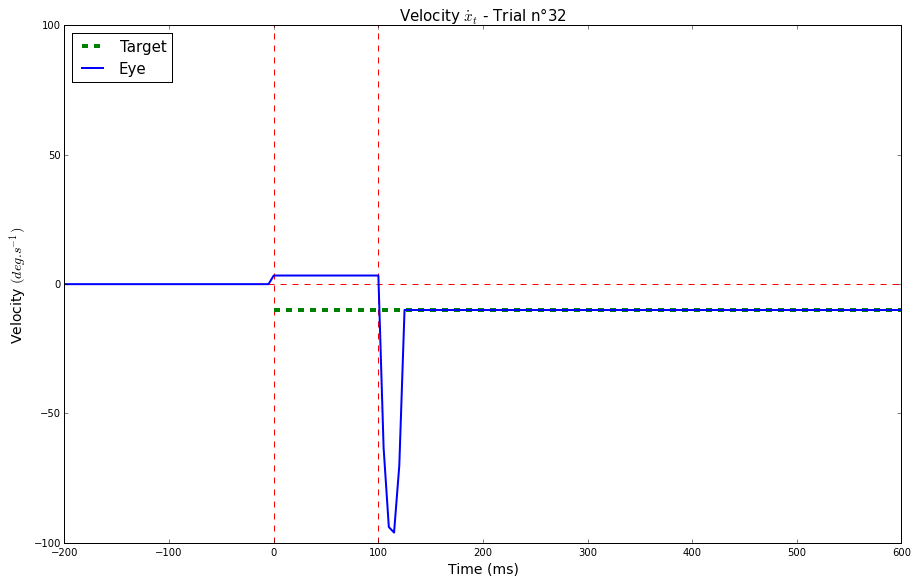

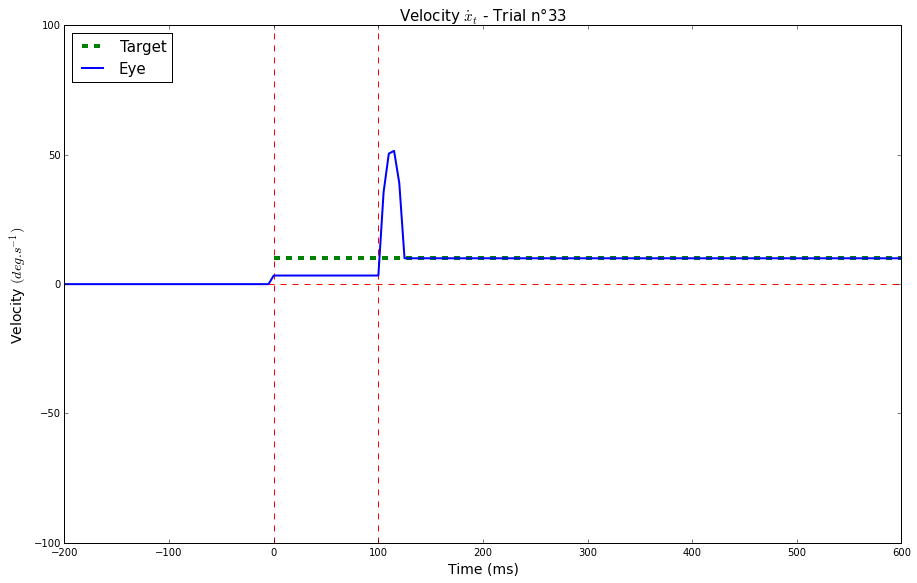

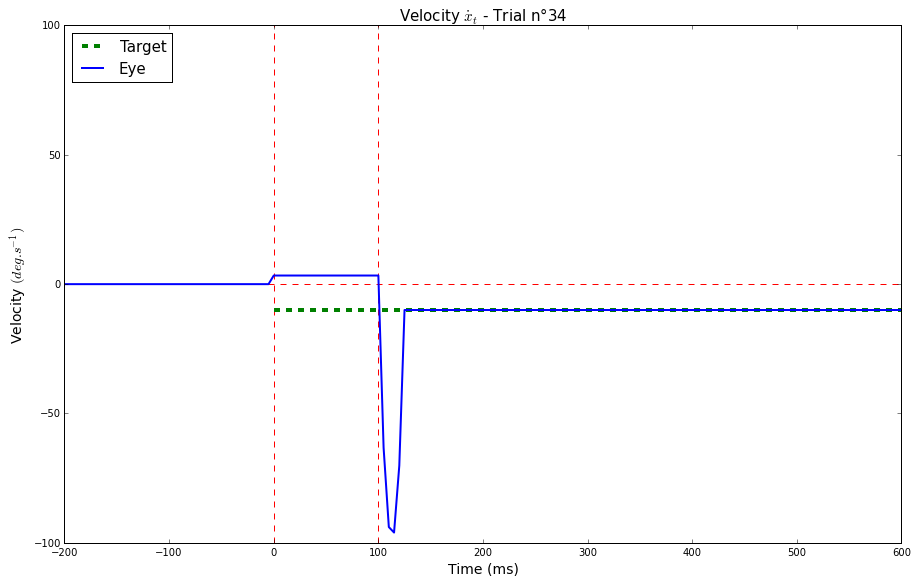

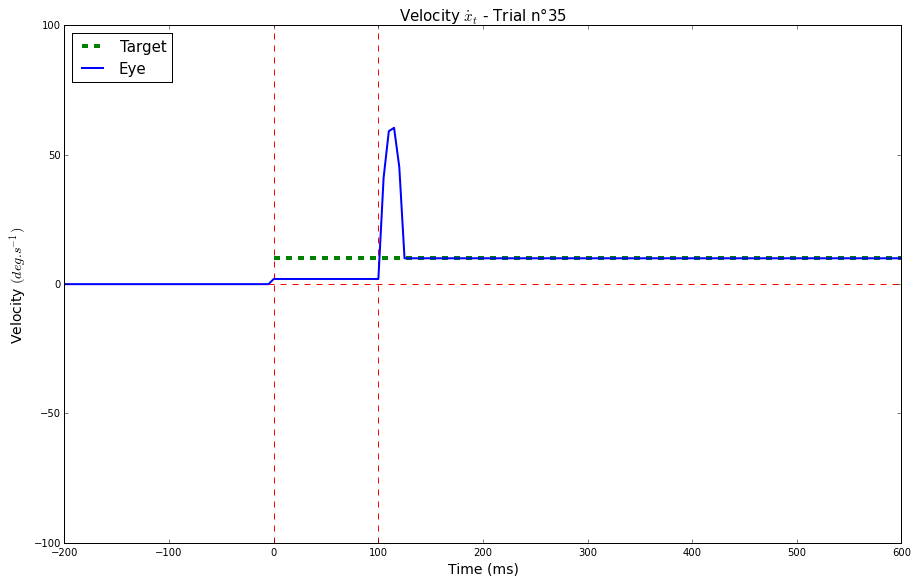

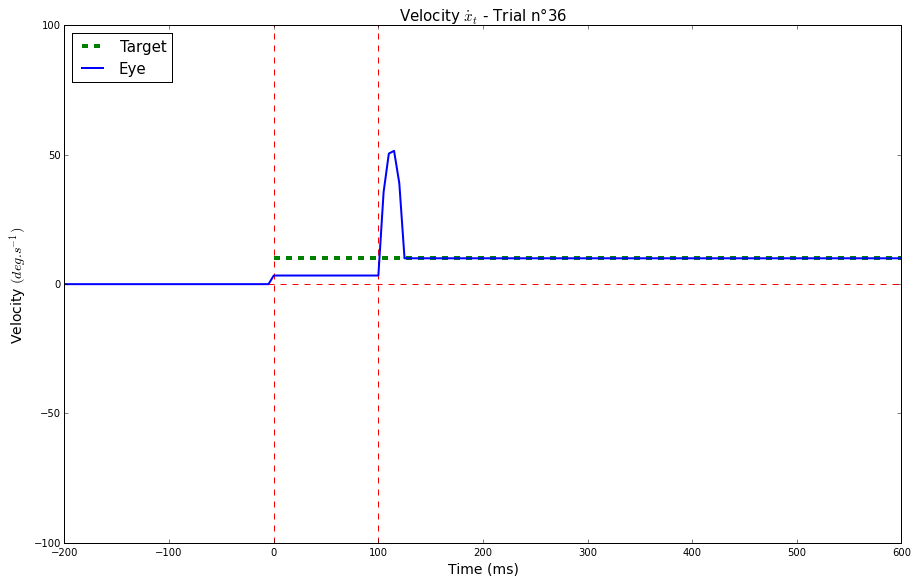

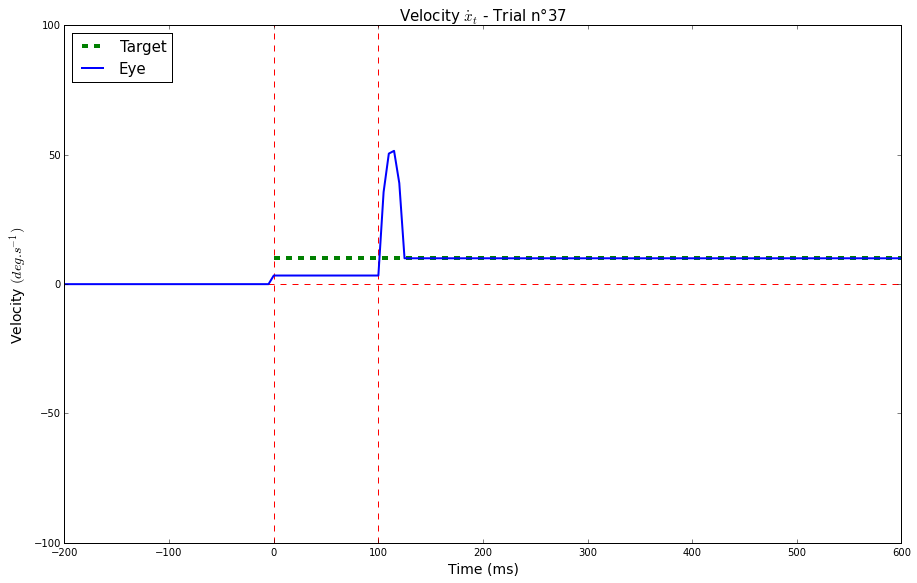

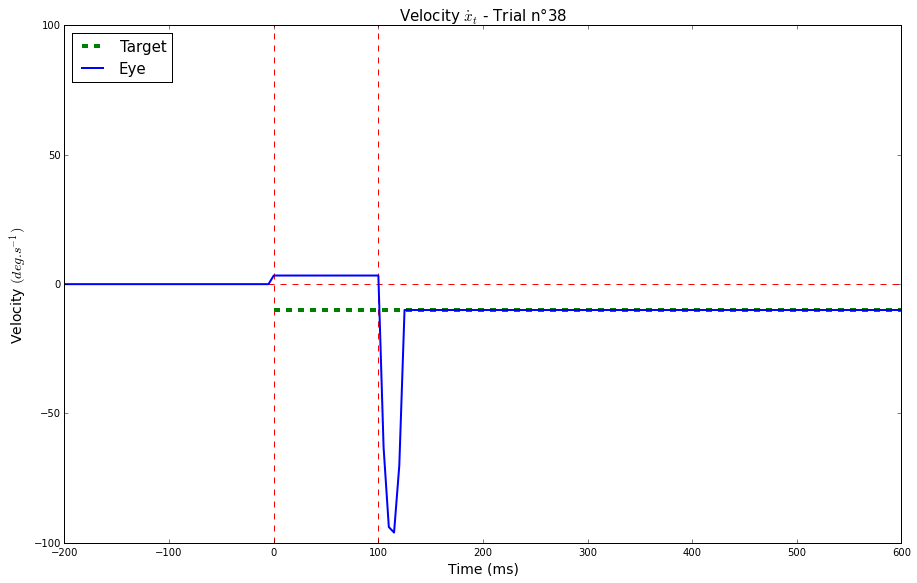

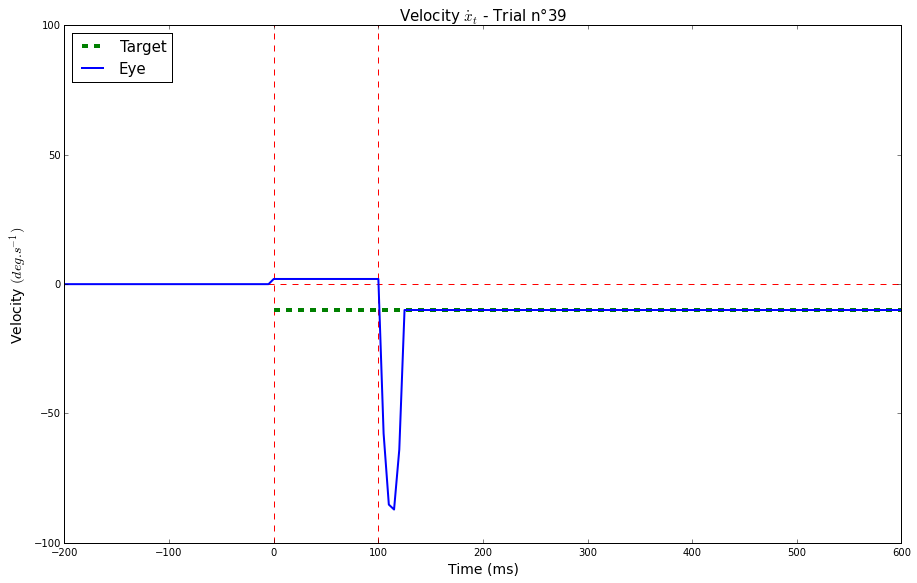

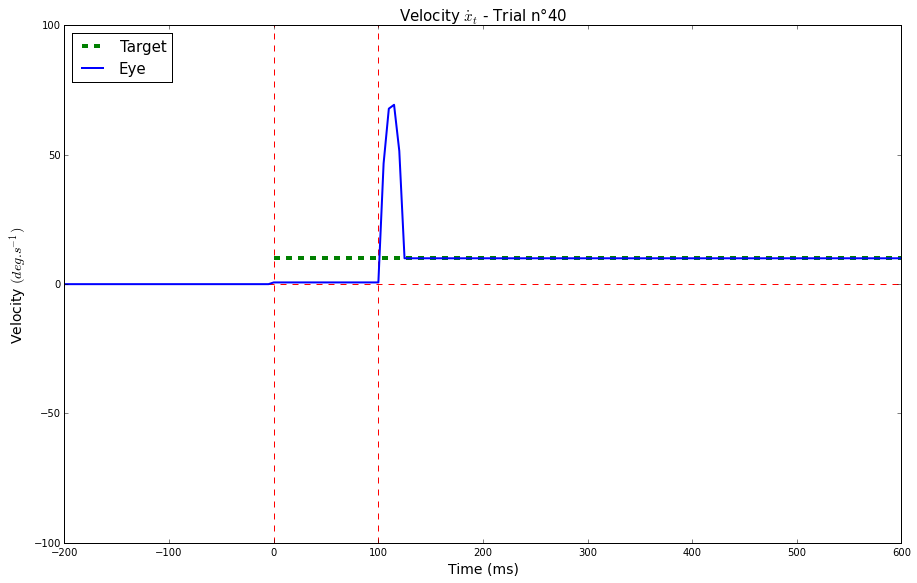

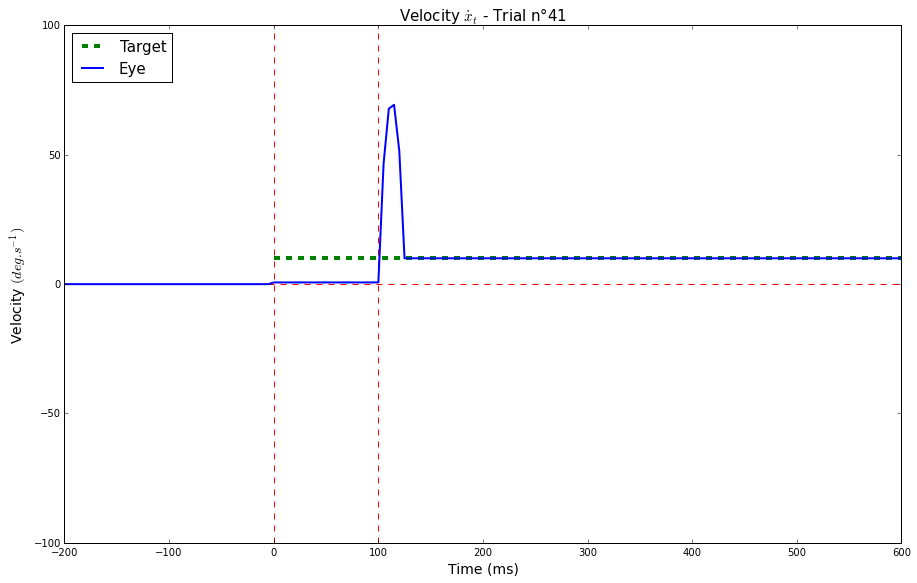

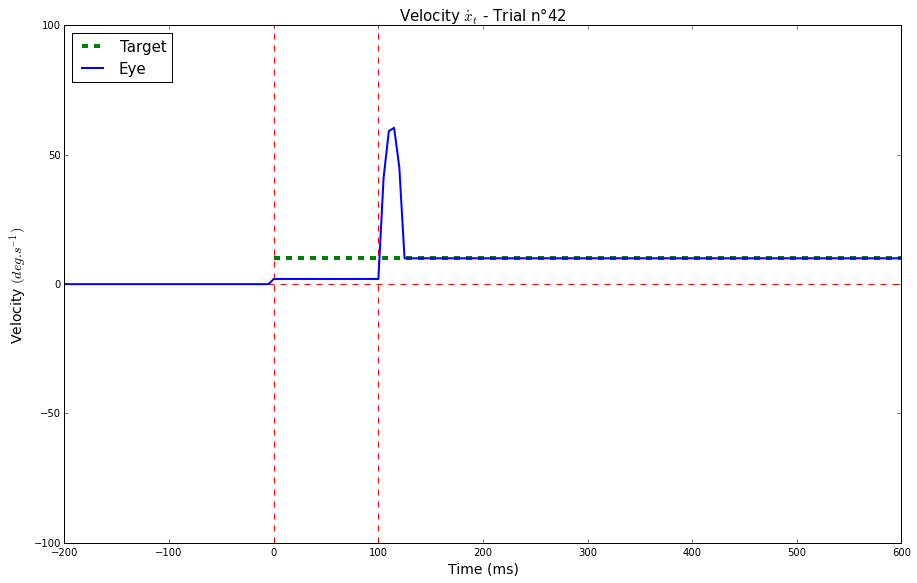

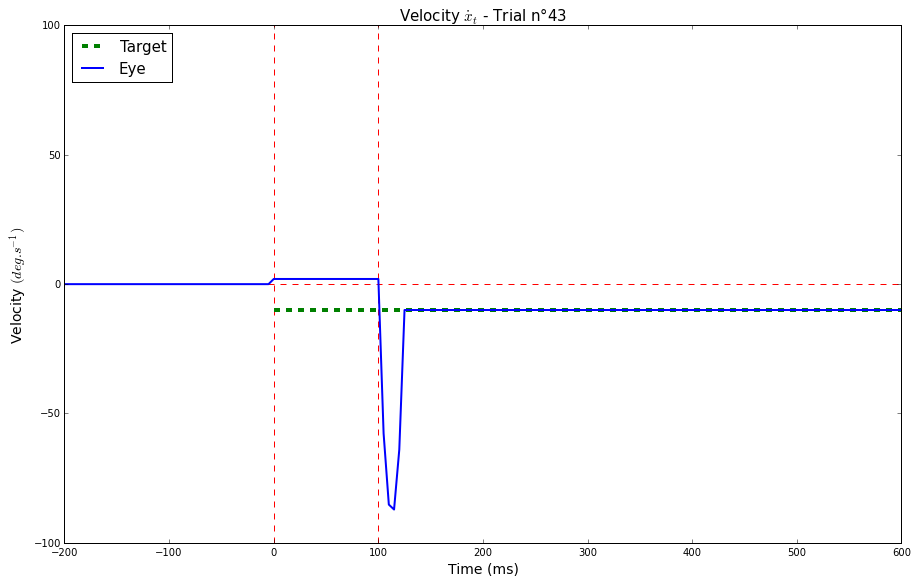

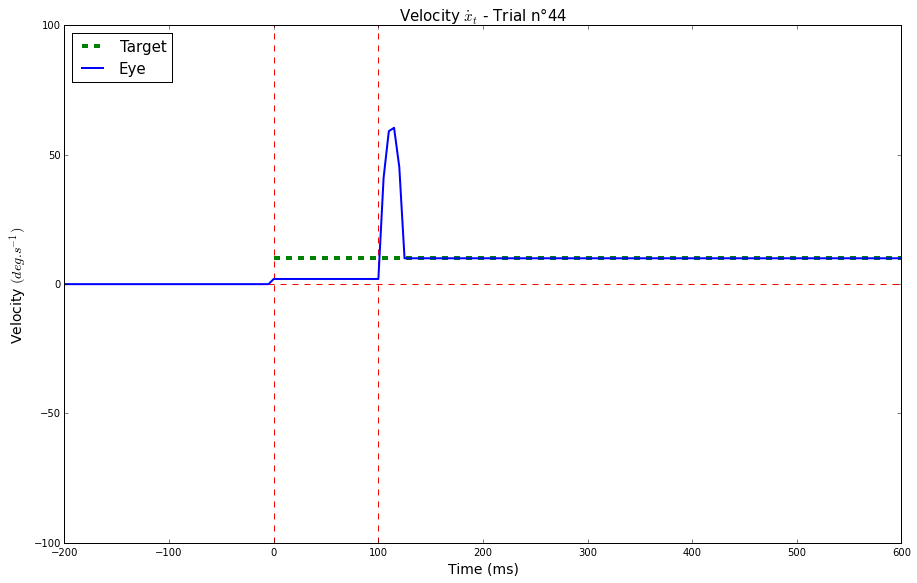

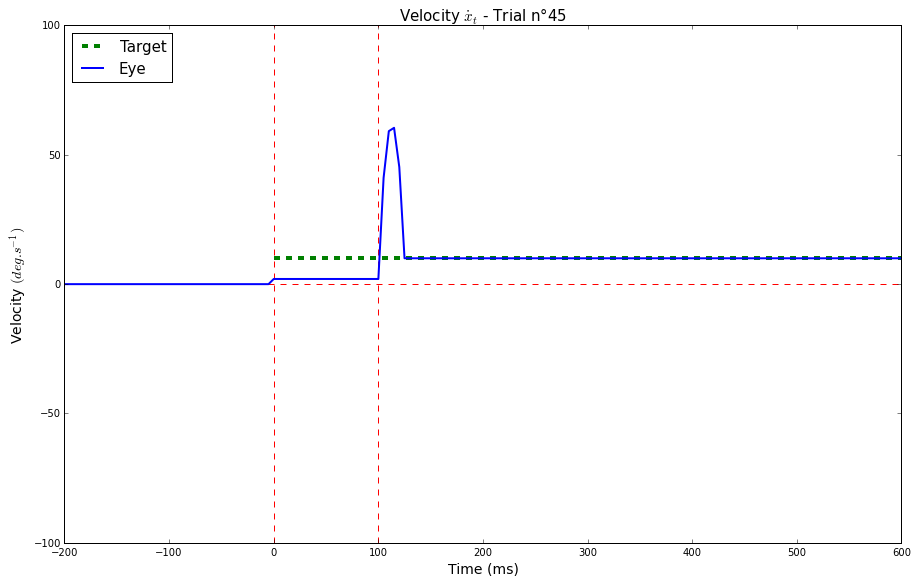

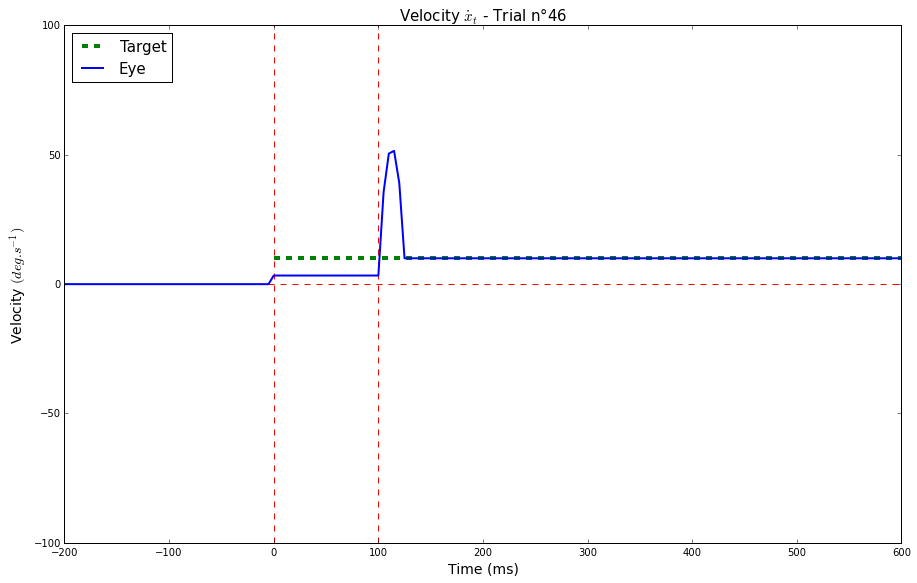

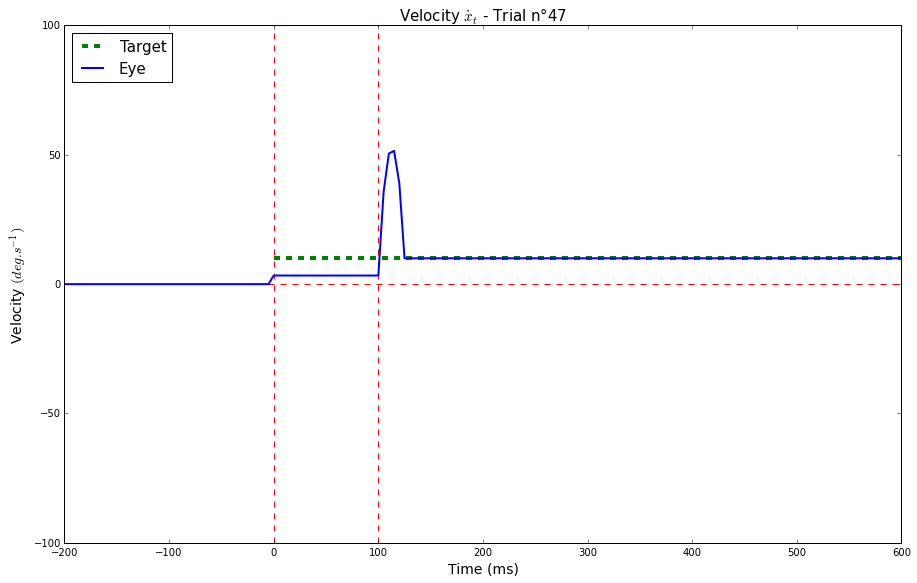

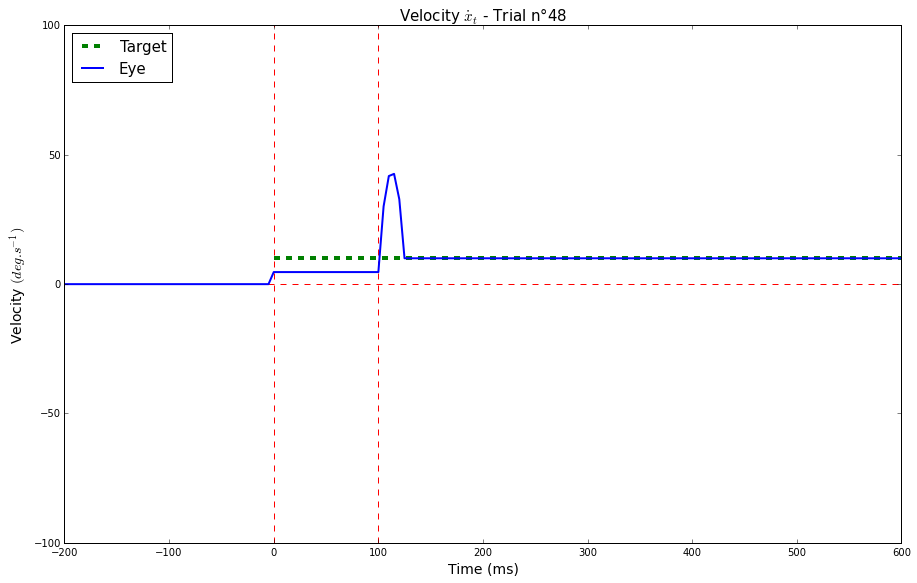

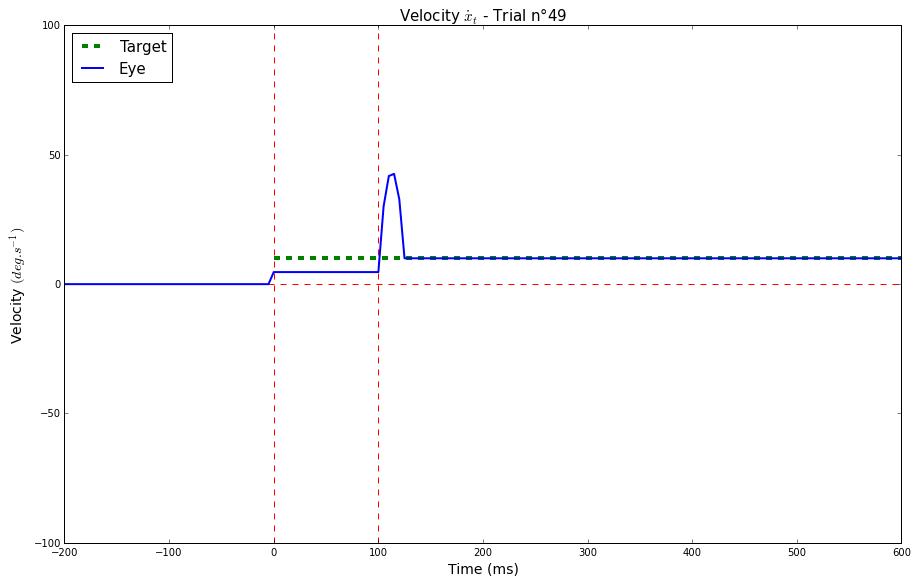

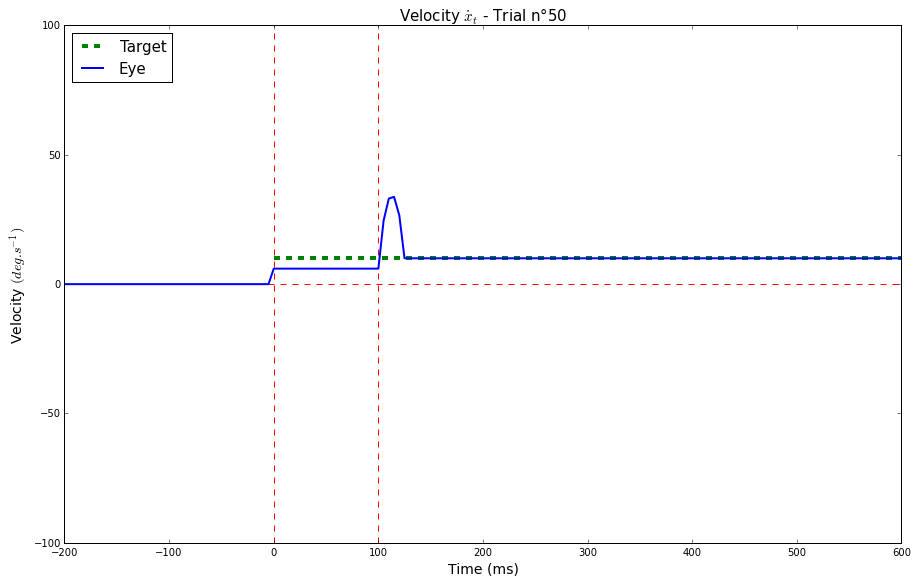

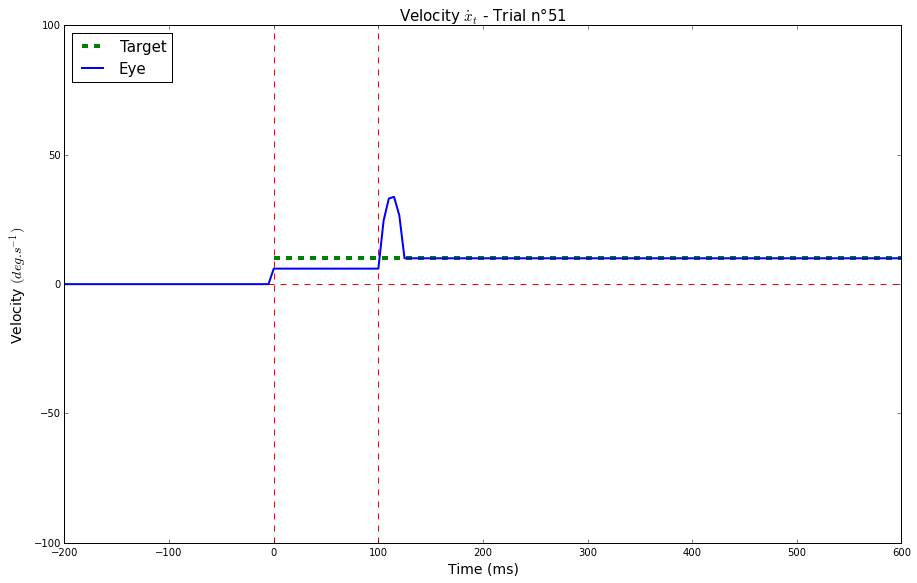

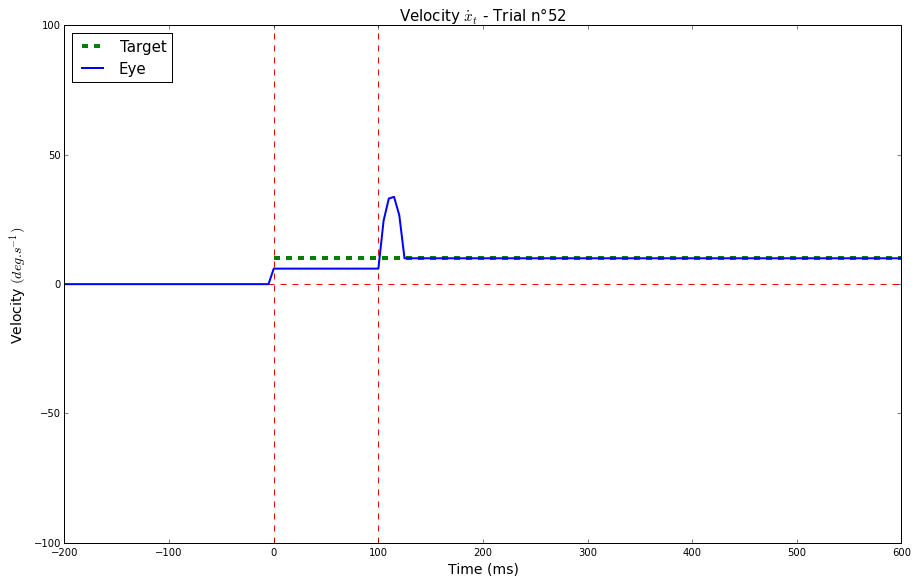

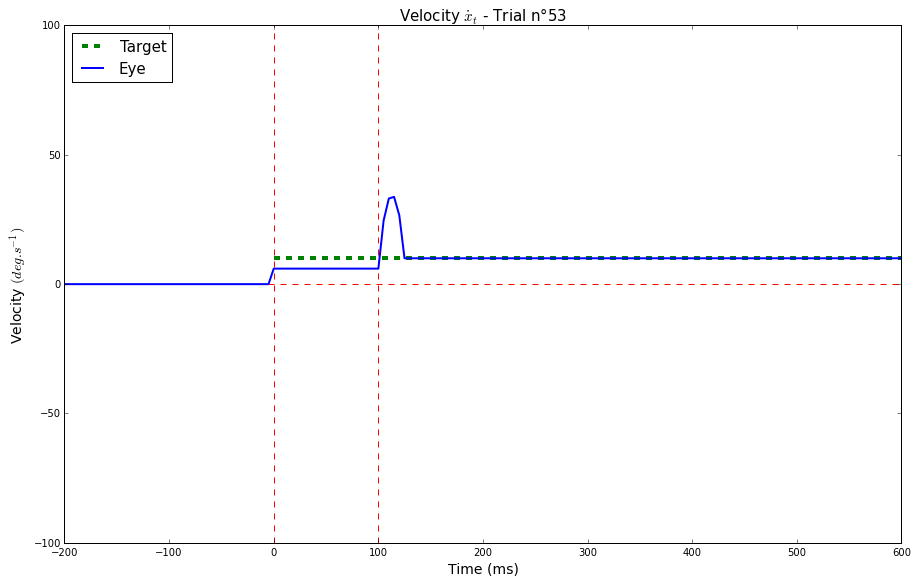

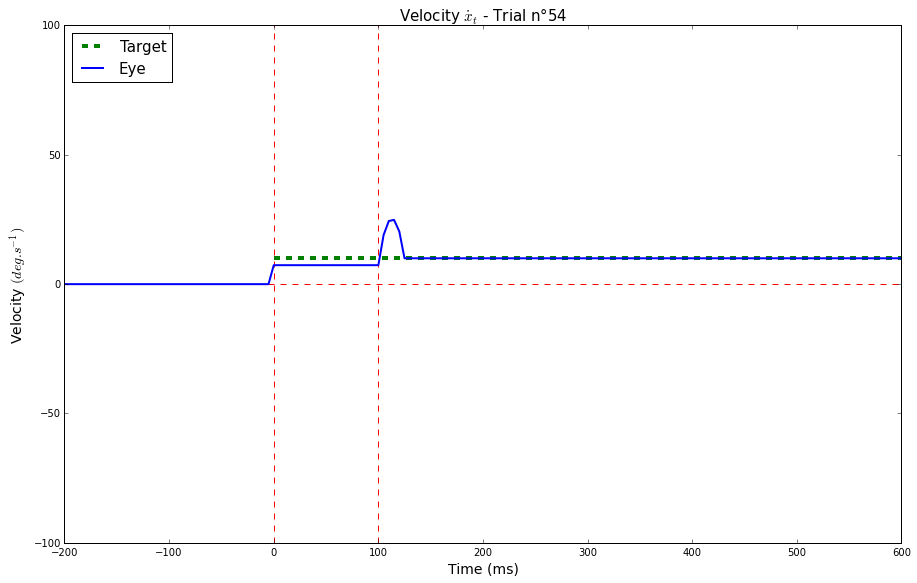

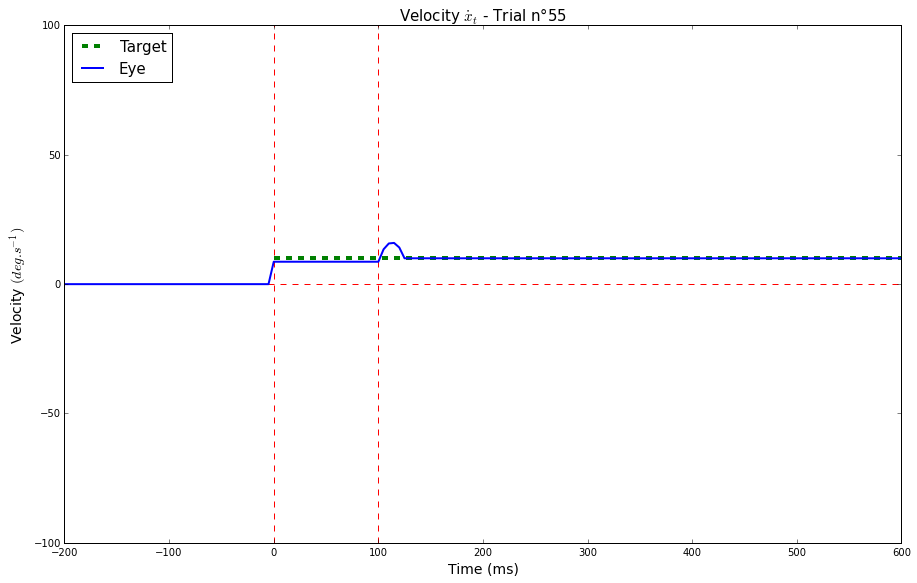

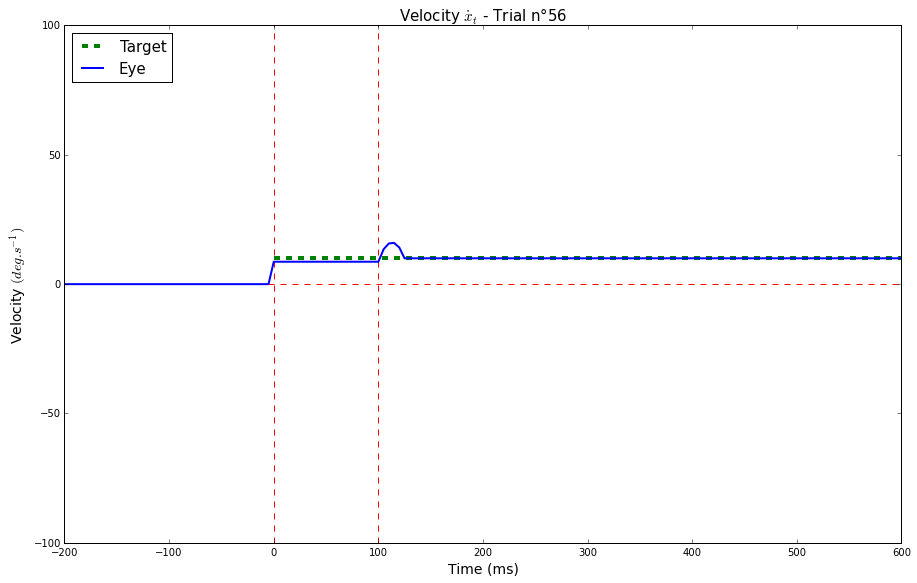

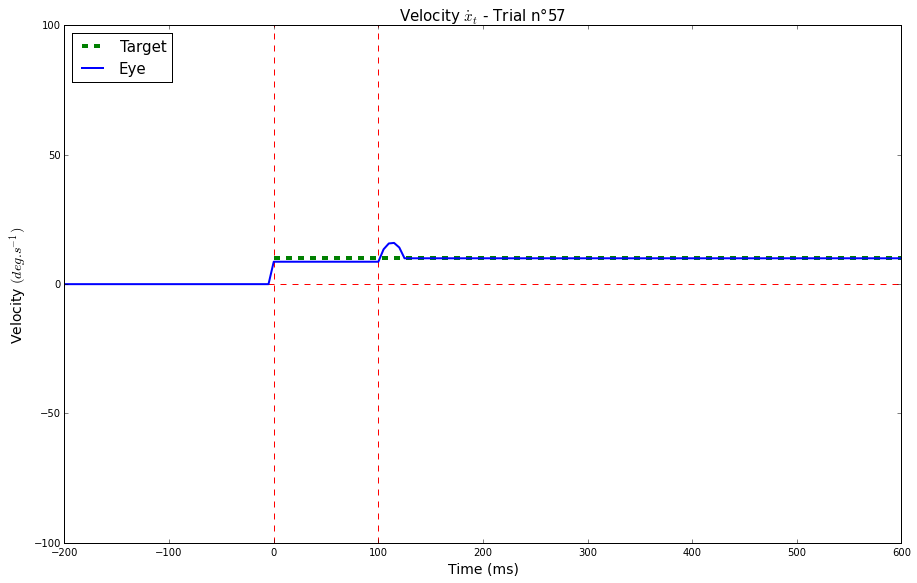

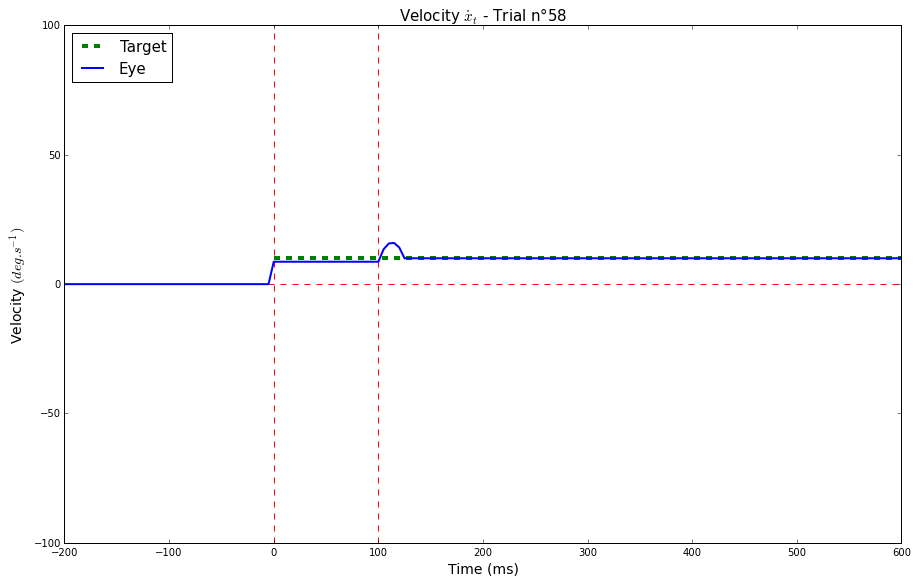

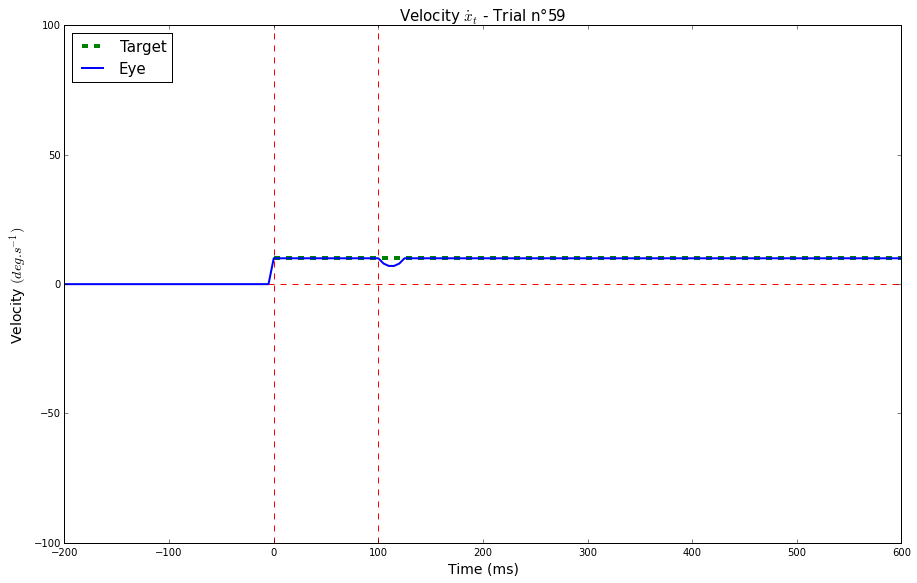

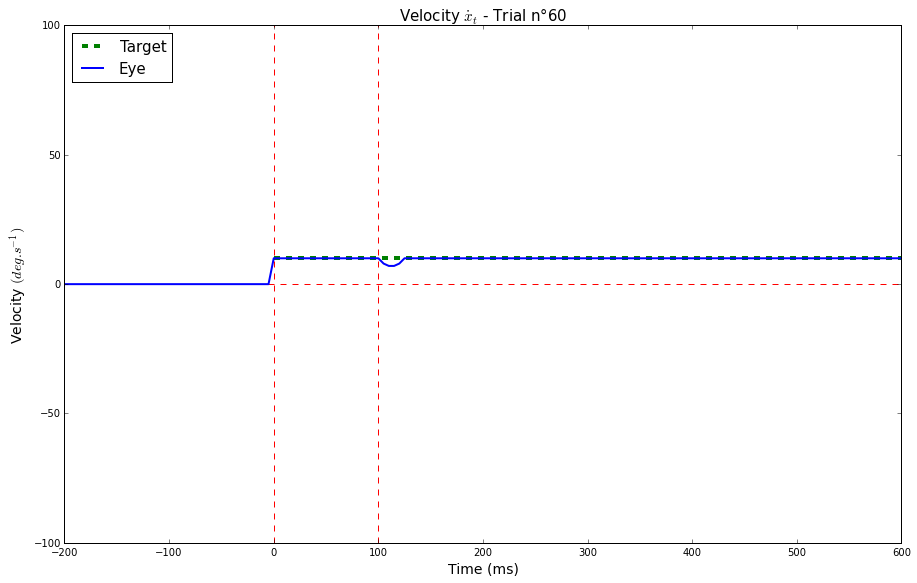

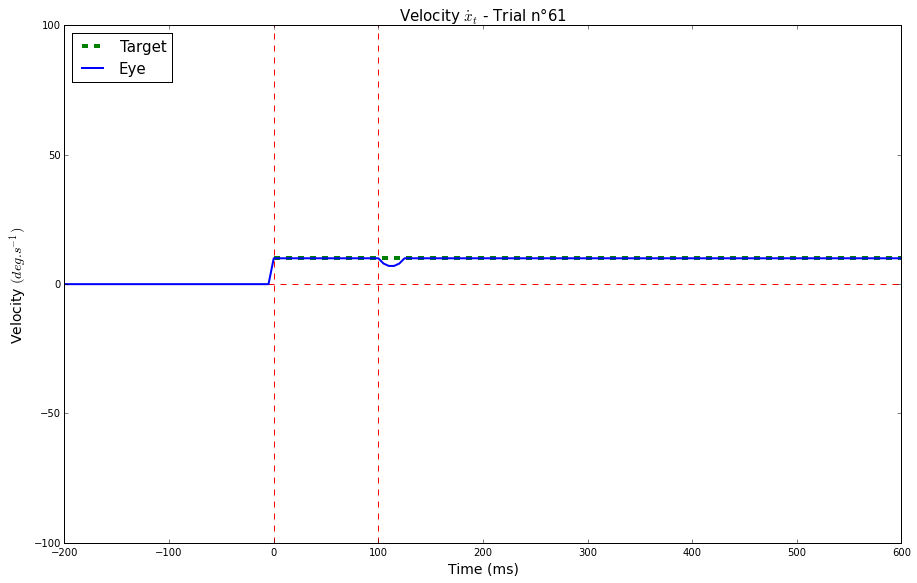

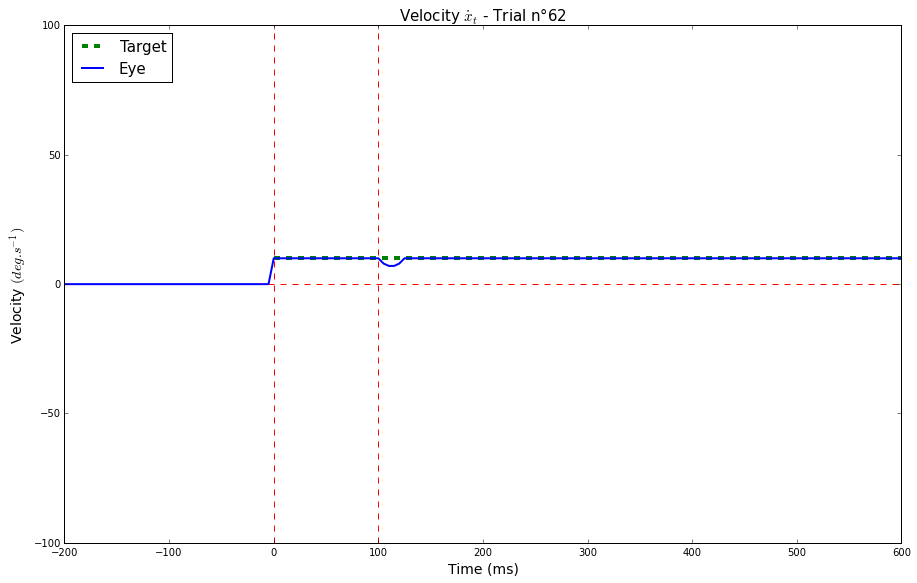

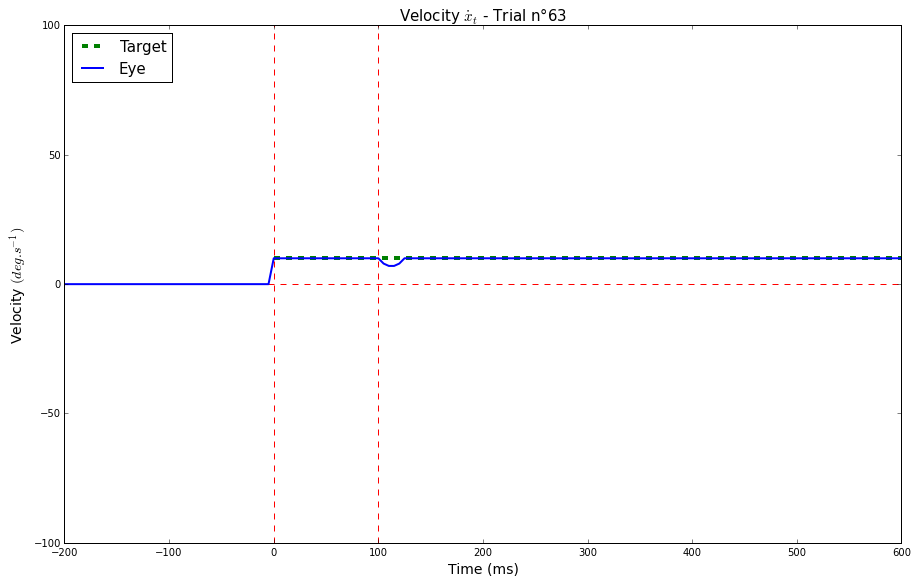

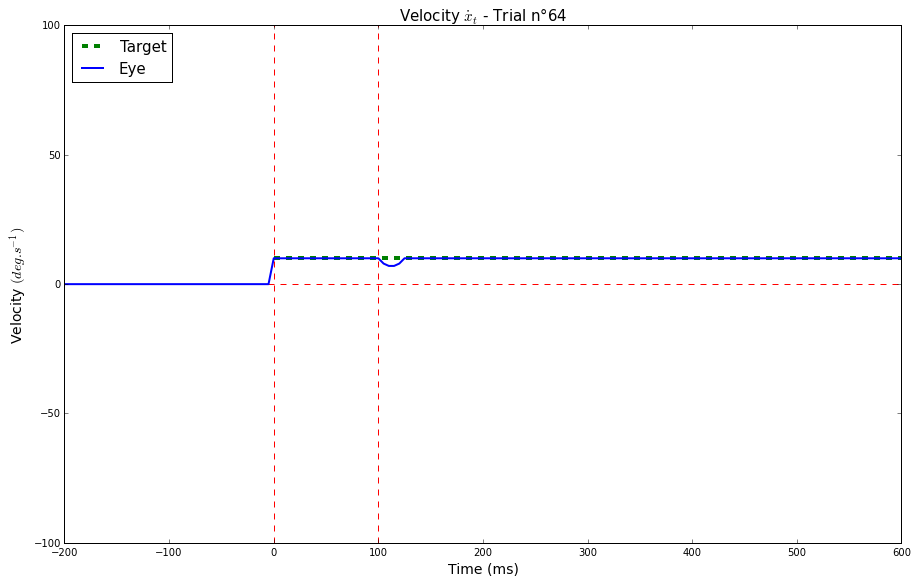

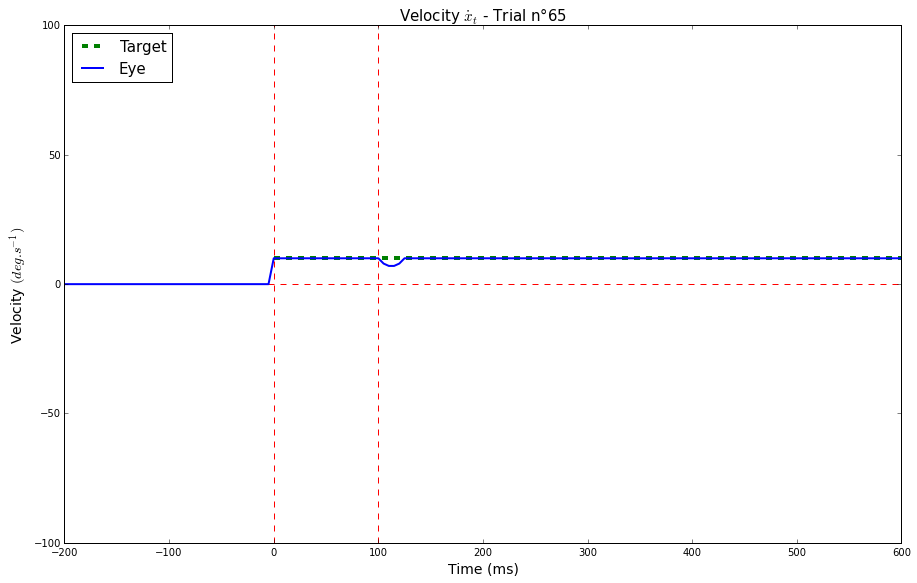

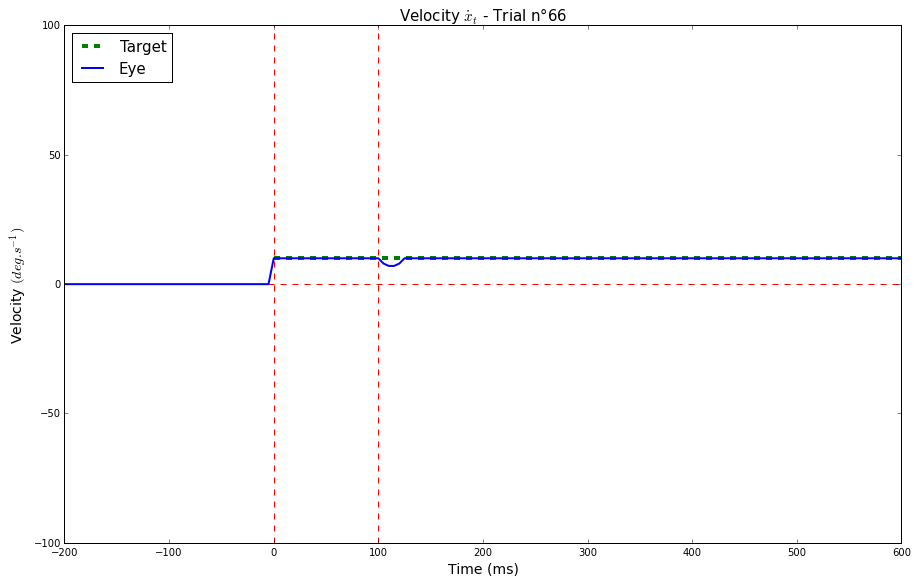

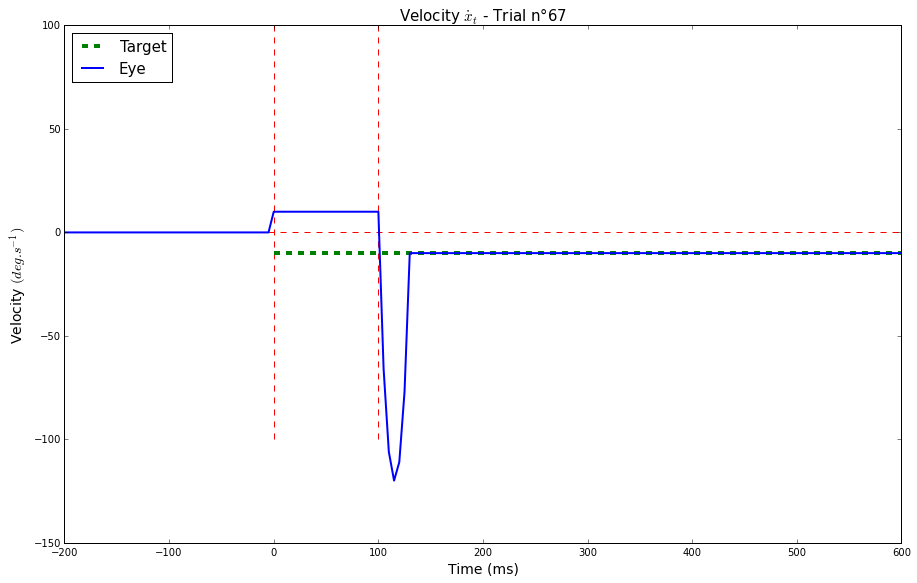

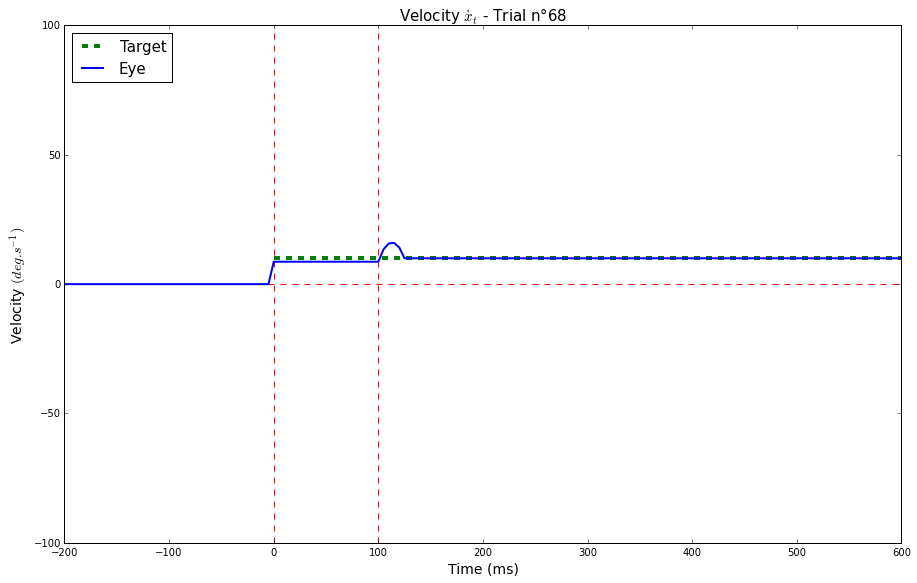

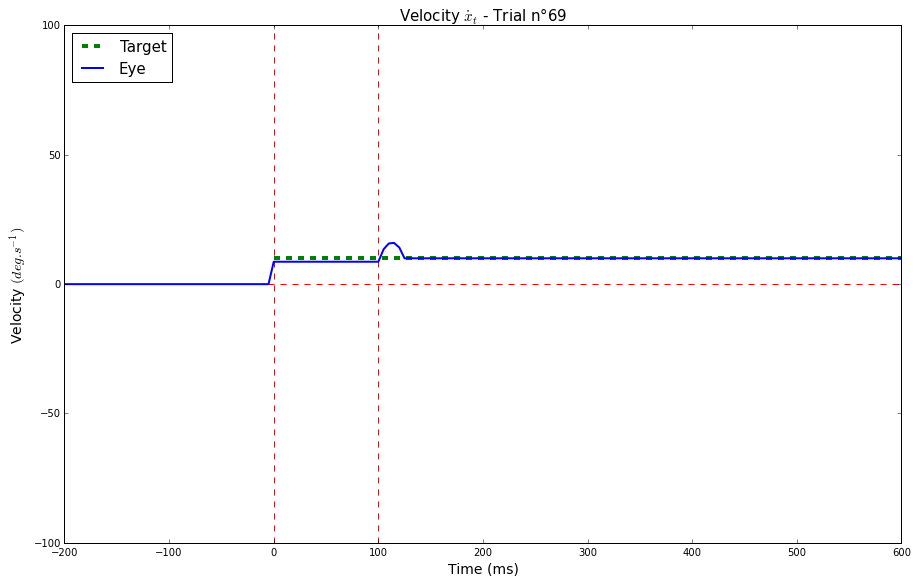

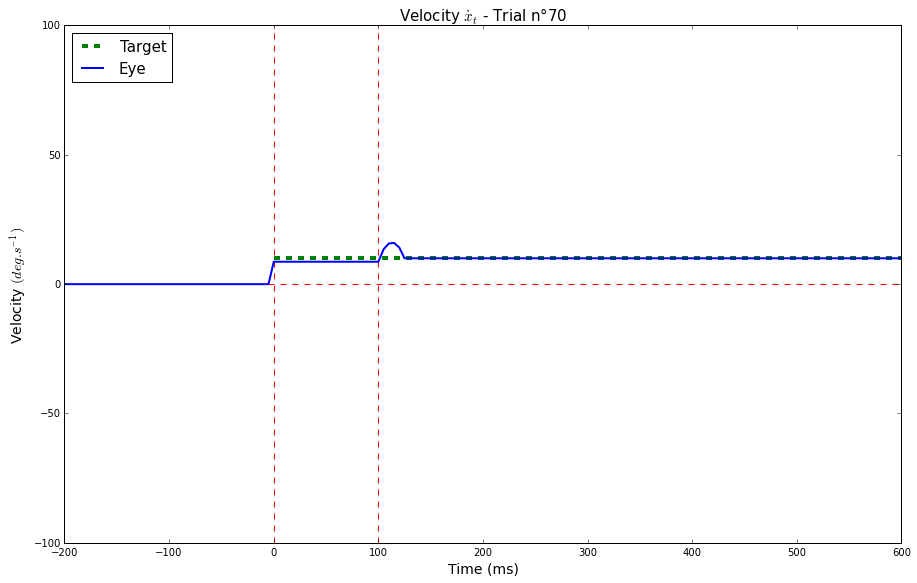

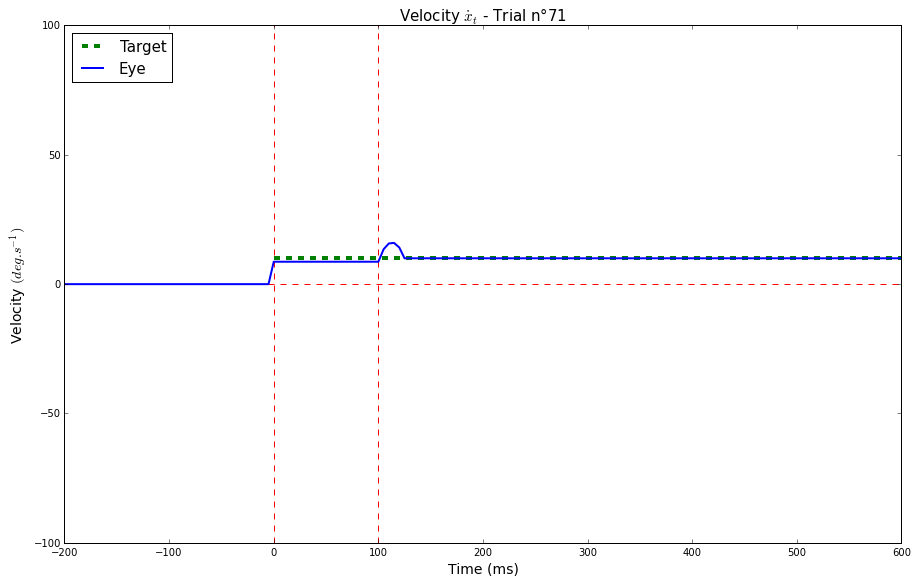

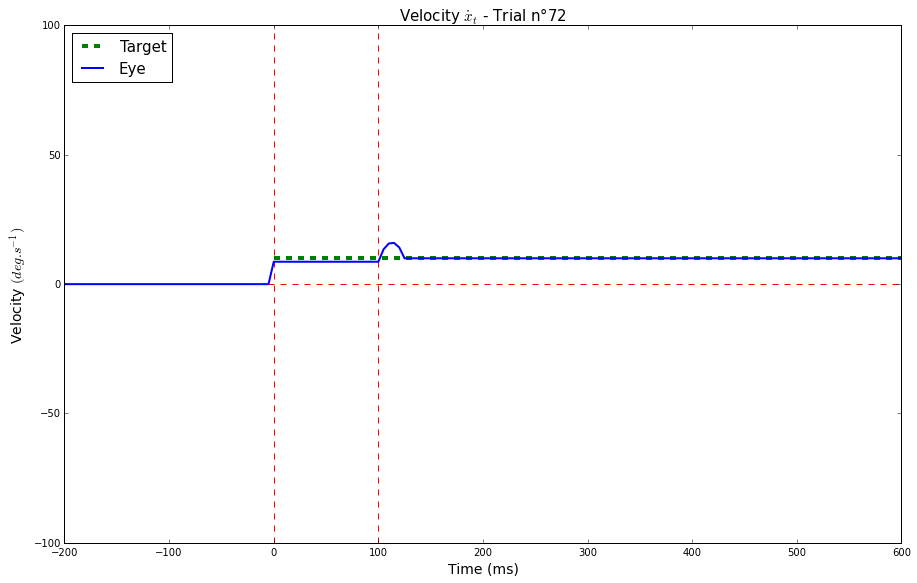

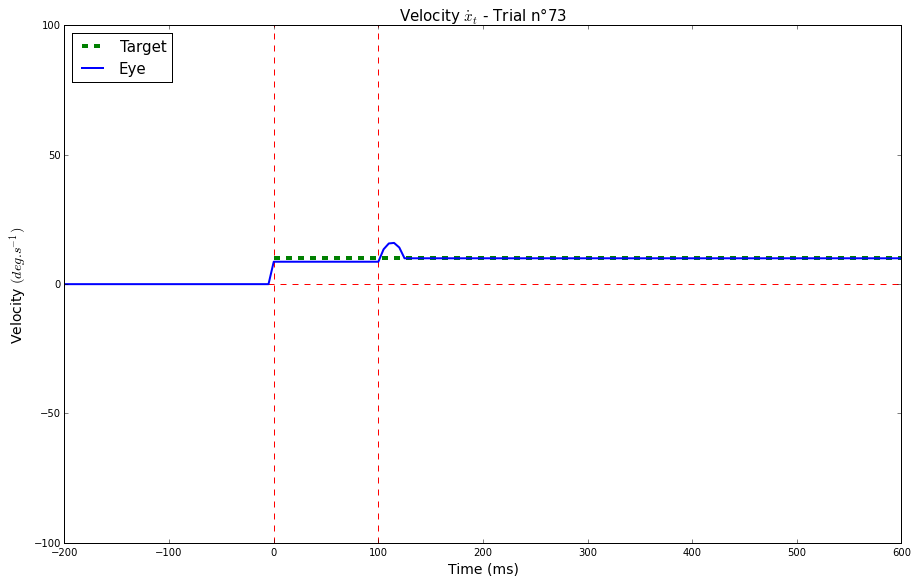

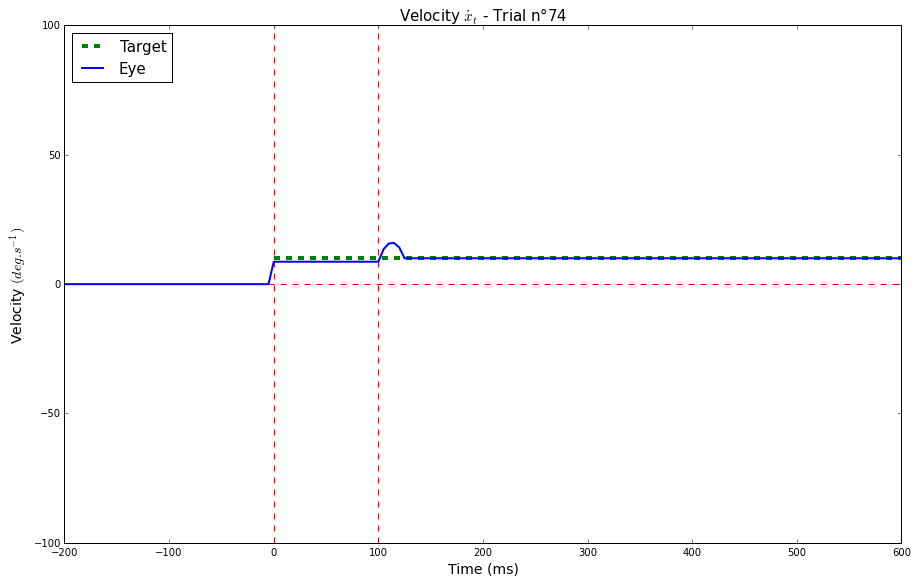

In [176]:
for i in np.arange(n_try):
    fig_width = 15
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
    plt.plot([-T_fix*5,(T_delay+T_mov)*5],[0,0],'r--')
    plt.plot([0,0],[-100,100],'r--')
    plt.plot([5*T_delay,5*T_delay],[-100,100],'r--')
    if distribution[i] > 0:
        plt.plot([0,5*(T_delay+T_mov)],[v,v],color='g', lw=4, ls ='--', label="Target")
    else:
        plt.plot([0,5*(T_delay+T_mov)],[-v,-v],color='g', lw=4, ls ='--', label="Target")
    plt.plot(time_ms, vel_rec[i, :], lw=2, label="Eye")
    ax.set_title(r'Velocity $\dot x_t$ - Trial n°'+str(i), fontsize = 15)
    ax.set_xlabel('Time (ms)', fontsize=14)
    ax.set_ylabel('Velocity $(deg.s^{-1})$', fontsize=14)
    ax.set_xlim(-T_fix*5,(T_delay+T_mov)*5)
    ax.legend(loc='upper left',prop={'size':15})

    plt.show()

In [177]:
import pickle
import pandas as pd
record = pd.DataFrame()
for i in np.arange(n_try):
    record_one = pd.DataFrame([{'position':pos_rec[i,:],'velocity':vel_rec[i,:]}],index=[i])
    record = pd.concat([record, record_one])
record.to_pickle('../2017_OptimalPrecision/DataRecording/ASPEM_n_try=75_p=0.8.pkl')

In [175]:
import pickle
import pandas as pd
record = pd.read_pickle('/home/baptiste/Documents/2017_OptimalPrecision/DataRecording/ASPEM_n_try=40_p=0.8.pkl')